In [12]:
%matplotlib inline
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import cv2, os, math, time
from datetime import timedelta
from sklearn.utils import shuffle

### Configuration

In [77]:
###Configuration
"""
Data Configurations/Paths
"""
img_dir_patch="./SD/patched_images"
img_dir_orig = "./SD/original_images"

model33k_original = 'SD/33k_original.ckpt'
model33k_patch = 'SD/33k_patch.ckpt'
img_type = "original"
# img_type = "patch"

##
# Convolutional Layer 1.
filter_size1 = 4          # Convolution filters are 4 x 4 pixels.
num_filters1 = 16         # There are 16 of these filters.

# Convolutional Layer 2.
filter_size2 = 2          # Convolution filters are 2 x 2 pixels.
num_filters2 = 32         # There are 32 of these filters.

# Convolutional Layer 3.
filter_size3 = 2          # Convolution filters are 2 x 2 pixels.
num_filters3 = 64         # There are 64 of these filters.

# Convolutional Layer 4.
filter_size4 = 2          # Convolution filters are 2 x 2 pixels.
num_filters4 = 128         # There are 128 of these filters.

# Fully-connected layer.
fc_size = 256             # Number of neurons in fully-connected layer.

### Load Data

In [78]:
def change_label_dimensions(labels):
    label_temp = np.zeros((len(labels), 2))
    
    for idx in range(0, len(labels)):
        if labels[idx] == 1:
            label_temp[idx][1] = 1
        else:
            label_temp[idx][0] = 1
    
    return label_temp

def load_data(img_dir, img_type="patch"):
        list_of_imgs = []
        list_same_diff = []
        for img_no in os.listdir(img_dir):
            if img_no == ".DS_Store":
                continue

            img_no_path = os.path.join(img_dir, img_no)
            for img_label in os.listdir(img_no_path):
                if img_label == ".DS_Store":
                    continue
                    
                list_same_diff.append(int(img_label))
                img_lbl_path = os.path.join(img_no_path, img_label)
                
                if img_type == "original":
                    img_lbl_path = img_lbl_path + "/img/"
                
                for img in os.listdir(img_lbl_path):
                    img_path = os.path.join(img_lbl_path, img)
                    list_of_imgs.append(img_path)

        data_imgs = np.array(list_of_imgs)
        data_same_diff = np.array(list_same_diff)

        return data_imgs, data_same_diff

# def load_data(img_dir):
#         list_of_imgs = []
#         list_same_diff = []
#         for img_no in os.listdir(img_dir):
#             if img_no == ".DS_Store":
#                 continue

#             img_no_path = os.path.join(img_dir, img_no)
#             for img_label in os.listdir(img_no_path):
#                 if img_label == ".DS_Store":
#                     continue
                    
#                 list_same_diff.append(int(img_label))
#                 img_lbl_path = os.path.join(img_no_path, img_label)
#                 for img in os.listdir(img_lbl_path):
#                     img_path = os.path.join(img_lbl_path, img)
#                     list_of_imgs.append(img_path)

#         data_imgs = np.array(list_of_imgs)
#         data_same_diff = np.array(list_same_diff)

#         return data_imgs, data_same_diff

    
def get_batch_images(data, same_diff, type_img = "patch"):
        list_of_imgs = []
        list_of_same_diff = []
        for img, img_type in zip(data, same_diff):
            orig_img = cv2.imread(img)
            #only first image as a label
            if orig_img is None:
                    print ("Unable to read image{}".format(img))
                    continue
            
            if type_img == "original":
                flattened_img = orig_img.flatten()
                list_of_imgs.append(np.asarray(flattened_img, dtype=np.float32))
                
                if img_type == 1: #0 is same and 1 is different
                    list_of_same_diff.append([0,1])
                else:
                    list_of_same_diff.append([1,0])
            else:            
                if orig_img.shape == (4, 2, 3):
                    flattened_img = orig_img.flatten()
                    list_of_imgs.append(np.asarray(flattened_img, dtype=np.float32))

                    if img_type == 1: #0 is same and 1 is different
                        list_of_same_diff.append([0,1])
                    else:
                        list_of_same_diff.append([1,0])
        
        data_imgs = np.array(list_of_imgs)
        data_img_type = np.array(list_of_same_diff)
        
        return data_imgs, data_img_type

### Next Batch Own Implementation

In [79]:
def next_batch(num, data, labels):
    '''
    Return a total of `num` random samples and labels. 
    '''
    idx = np.arange(0 , len(data))
    np.random.shuffle(idx)
    idx = idx[:num]
    data_shuffle = [data[ i] for i in idx]
    labels_shuffle = [labels[ i] for i in idx]

    return np.asarray(data_shuffle), np.asarray(labels_shuffle)

### Data Dimensions

In [80]:
# We know that images are 60 pixels in each dimension.
img_size = 10*10

# Images are stored in one-dimensional arrays of this length.
img_size_flat = 10 * 10

# Number of colour channels for the images: 3 channel for RGB.
num_channels = 3

# Tuple with height and width of images used to reshape arrays.
img_shape = (10, 10, num_channels)


# Number of classes, one class for same and one for different image
num_classes = 2

### Image Plot Functions

In [95]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(cv2.imread(images[i]).flatten().reshape((8,4, 3)), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()
    
    
def generate_size_graph(fig_no, training_size, accuracy, loss, patch_only,patch_conv, start_size, end_size):
    plt.figure(fig_no,figsize=(7,5))
    plt.plot(training_size,accuracy)
    plt.plot(training_size,loss)
    plt.plot(training_size, patch_only)
    plt.plot(training_size, patch_conv)
    plt.xlabel('Training Size')
    plt.ylabel('Accuracy')
    plt.title('Training Size vs Accuracy')
    plt.grid(True)
    plt.legend(['SD Original Accuracy','SR Accuracy', 'SD Patch Accuracy', 'SD Patch Conv'])
    plt.style.use(['classic'])
    plt.show()
    plt.savefig(path + '/batch_graphs/' +  str(start_size) + '_' + str(end_size) + '.jpg') 
        
def generate_graph(fig_no, epochs, train, val, label, train_title, val_title, train_size):
    plt.figure(fig_no,figsize=(7,5))
    plt.plot(epochs,train)
    plt.plot(epochs,val)
    plt.xlabel('num of Epochs')
    plt.ylabel(label)
    plt.title(train_title + ' vs ' + val_title + '( Samples:' + str(train_size) + ')')
    plt.grid(True)
    plt.legend(['Patch','SD'])
    plt.style.use(['classic'])
    plt.show()
#     plt.savefig(results_path + '/batch_graphs/' +  label + '_' + str(train_size) + '.jpg')     

### Helper Functions for TF Graph Initialization

In [82]:
def new_weights(shape):
    initializer = tf.contrib.layers.xavier_initializer()
    return tf.Variable(initializer(shape))
#     return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

def new_bias(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

### Helper Functions for Network

In [83]:
def new_conv_layer(input,
                   num_input_channels,
                   filter_size,
                   num_filters,
                   use_pooling=True):

    shape = [filter_size, filter_size, num_input_channels, num_filters]
    weights = new_weights(shape)
    biases = new_bias(length=num_filters)
    
    layer = tf.nn.conv2d(input=input,
                     filter=weights,
                     strides=[1, 1, 1, 1],
                     padding='SAME')
    layer += biases

    if use_pooling:
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 3, 3, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')
    layer = tf.nn.relu(layer)

    return layer, weights

def flatten_layer(layer):
    layer_shape = layer.get_shape()
    num_features = layer_shape[1:4].num_elements()
    layer_flat = tf.reshape(layer, [-1, num_features])
    
    return layer_flat, num_features

def new_fc_layer(input,
                num_inputs,
                num_outputs,
                use_relu=True):

    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_bias(length=num_outputs)
    layer = tf.matmul(input, weights) + biases
    
    if use_relu:
        layer = tf.nn.relu(layer)
    
    return layer

In [84]:
x = tf.placeholder(tf.float32, shape=[None, img_size_flat*num_channels], name='x')
x_image = tf.reshape(x, [-1, 10, 10, num_channels])
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
y_true_cls = tf.argmax(y_true, axis=1)
x_image.shape, y_true

(TensorShape([Dimension(None), Dimension(10), Dimension(10), Dimension(3)]),
 <tf.Tensor 'y_true_3:0' shape=(?, 2) dtype=float32>)

### Convolution Layers

In [85]:
layer1_conv1, weights_conv1 = new_conv_layer(input=x_image,
                                            num_input_channels=num_channels,
                                            filter_size=filter_size1,
                                            num_filters=num_filters1,
                                            use_pooling=True)

layer2_conv2, weights_conv2 =  new_conv_layer(input=layer1_conv1,
                                           num_input_channels=num_filters1,
                                           filter_size=filter_size2,
                                           num_filters=num_filters2,
                                           use_pooling=True)

layer3_conv3, weights_conv3 =  new_conv_layer(input=layer2_conv2,
                                           num_input_channels=num_filters2,
                                           filter_size=filter_size3,
                                           num_filters=num_filters3,
                                           use_pooling=True)

layer4_conv4, weights_conv4 =  new_conv_layer(input=layer3_conv3,
                                           num_input_channels=num_filters3,
                                           filter_size=filter_size4,
                                           num_filters=num_filters4,
                                           use_pooling=True)

In [86]:
layer_flat, num_features = flatten_layer(layer4_conv4)

### Fully Connected Layers

In [87]:
layer_fc1 = new_fc_layer(input=layer_flat,
                         num_inputs=num_features,
                         num_outputs=fc_size,
                         use_relu=True)


layer_fc2 = new_fc_layer(input=layer_fc1,
                         num_inputs=fc_size,
                         num_outputs=fc_size,
                         use_relu=False)

layer_fc3 = new_fc_layer(input=layer_fc2,
                         num_inputs=fc_size,
                         num_outputs=fc_size,
                         use_relu=False)

layer_fc4 = new_fc_layer(input=layer_fc3,
                         num_inputs=fc_size,
                         num_outputs=num_classes,
                         use_relu=False)

drop_out = tf.nn.dropout(layer_fc4, 0.5)

##Normalize the numbers(apply softmax!)

y_pred = tf.nn.softmax(drop_out)
y_pred_cls = tf.argmax(y_pred, axis=1)

### Cost Function

In [88]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=drop_out,
                                                        labels=y_true)
cost = tf.reduce_mean(cross_entropy)

### Optimization Method

In [89]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)

## some more performance measures
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

### Run Tensorflow on Defined Graph

In [90]:
session = tf.Session()
session.run(tf.global_variables_initializer())
train_data, train_labels = load_data(img_dir_orig, img_type)
total_imgs = len(train_data)
train_batch_size = 64

def optimize(num_epochs, save_model=True,save_name= "base_model",restore_model=False,restore_name=None):
    total_iterations = 0
    done_train_imgs = 0
    start_time = time.time()
    start_batch=0
    end_batch = train_batch_size
    plot_accuracy=[]
    plot_accuracy_epoch=[]
    plot_training_size=[]
    plot_training_size_epoch=[]
    saver = tf.train.Saver()
    sum_accuracy = 0.0
    n = 1
    
        #to save the model
    for i in range(0, num_epochs):   
        start_batch=0
        end_batch = train_batch_size
        
        print("Epoch:", i + 1)
        
        if restore_model==True:
            if restore_name==None:
                print("No model file specified")
                return
            else:
                saver.restore(session,restore_name)
        
        sum_accuracy = 0.0
        n = 1
        while end_batch < total_imgs:
            train = train_data[start_batch:end_batch]
            labels = train_labels[start_batch:end_batch]
            train, labels = get_batch_images(train, labels, img_type)
            if not len(train) and not len(labels):
                print("All images have been processed.")
                break;

            x_batch, y_true_batch = next_batch(len(train), train, labels)
            feed_dict_train = {x: x_batch,
                       y_true: y_true_batch}
            
            session.run(optimizer, feed_dict=feed_dict_train)
    
            acc,co = session.run([accuracy, cost], feed_dict=feed_dict_train)
            sum_accuracy += acc
            n+=1
            msg = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}, Loss: {2:>.4f}"
            print(msg.format(end_batch + 1, acc, co))
            if i == num_epochs - 1:
                plot_accuracy.append(acc)
                plot_training_size.append(end_batch + 1)

            start_batch += train_batch_size
            end_batch += train_batch_size
    
        if save_model==True:
            if save_name==None:
                print("No model specified, model not being saved")
                return
            else:
                save_path = saver.save(session, save_name)
                restore_model = True
                print("Model saved in file: %s" % save_name)
        plot_accuracy_epoch.append(sum_accuracy/n)
        plot_training_size_epoch.append(i + 1)
    
    end_time = time.time()
    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))  
    print(plot_accuracy)
    print(plot_training_size)
    print(plot_accuracy_epoch)
    print(plot_training_size_epoch)

### Performance/Optimization

In [91]:
save_model = True
save_name = model33k_original
restore_model=False
restore_name=model33k_original

optimize(num_epochs=30, save_model=True,save_name=model33k_original,restore_model=False,restore_name=model33k_original)

Epoch: 1
Optimization Iteration:     65, Training Accuracy:  48.4%, Loss: 6.4334
Optimization Iteration:    129, Training Accuracy:  46.9%, Loss: 2.0637
Optimization Iteration:    193, Training Accuracy:  46.9%, Loss: 4.0509
Optimization Iteration:    257, Training Accuracy:  50.0%, Loss: 4.5299
Optimization Iteration:    321, Training Accuracy:  40.6%, Loss: 3.3263
Optimization Iteration:    385, Training Accuracy:  46.9%, Loss: 2.5471
Optimization Iteration:    449, Training Accuracy:  46.9%, Loss: 2.3682
Optimization Iteration:    513, Training Accuracy:  50.0%, Loss: 2.5769
Optimization Iteration:    577, Training Accuracy:  51.6%, Loss: 2.4469
Optimization Iteration:    641, Training Accuracy:  50.0%, Loss: 2.1463
Optimization Iteration:    705, Training Accuracy:  46.9%, Loss: 2.5206
Optimization Iteration:    769, Training Accuracy:  54.7%, Loss: 1.6731
Optimization Iteration:    833, Training Accuracy:  53.1%, Loss: 2.1505
Optimization Iteration:    897, Training Accuracy:  57.

Optimization Iteration:   7361, Training Accuracy:  56.2%, Loss: 0.9502
Optimization Iteration:   7425, Training Accuracy:  56.2%, Loss: 0.8260
Optimization Iteration:   7489, Training Accuracy:  56.2%, Loss: 1.0835
Optimization Iteration:   7553, Training Accuracy:  42.2%, Loss: 1.2789
Optimization Iteration:   7617, Training Accuracy:  64.1%, Loss: 1.1404
Optimization Iteration:   7681, Training Accuracy:  54.7%, Loss: 0.9278
Optimization Iteration:   7745, Training Accuracy:  51.6%, Loss: 1.2478
Optimization Iteration:   7809, Training Accuracy:  53.1%, Loss: 1.0631
Optimization Iteration:   7873, Training Accuracy:  65.6%, Loss: 1.0276
Optimization Iteration:   7937, Training Accuracy:  56.2%, Loss: 0.9231
Optimization Iteration:   8001, Training Accuracy:  56.2%, Loss: 0.9498
Optimization Iteration:   8065, Training Accuracy:  50.0%, Loss: 0.9625
Optimization Iteration:   8129, Training Accuracy:  59.4%, Loss: 0.8788
Optimization Iteration:   8193, Training Accuracy:  42.2%, Loss:

Optimization Iteration:  14657, Training Accuracy:  51.6%, Loss: 0.8866
Optimization Iteration:  14721, Training Accuracy:  68.8%, Loss: 0.7024
Optimization Iteration:  14785, Training Accuracy:  54.7%, Loss: 0.8403
Optimization Iteration:  14849, Training Accuracy:  57.8%, Loss: 0.8530
Optimization Iteration:  14913, Training Accuracy:  46.9%, Loss: 1.0571
Optimization Iteration:  14977, Training Accuracy:  50.0%, Loss: 0.9205
Optimization Iteration:  15041, Training Accuracy:  48.4%, Loss: 0.9000
Optimization Iteration:  15105, Training Accuracy:  57.8%, Loss: 0.7767
Optimization Iteration:  15169, Training Accuracy:  46.9%, Loss: 0.9180
Optimization Iteration:  15233, Training Accuracy:  53.1%, Loss: 0.9276
Optimization Iteration:  15297, Training Accuracy:  45.3%, Loss: 0.7978
Optimization Iteration:  15361, Training Accuracy:  56.2%, Loss: 0.7440
Optimization Iteration:  15425, Training Accuracy:  45.3%, Loss: 0.9179
Optimization Iteration:  15489, Training Accuracy:  42.2%, Loss:

Optimization Iteration:  21953, Training Accuracy:  54.7%, Loss: 0.6784
Optimization Iteration:  22017, Training Accuracy:  50.0%, Loss: 0.8272
Optimization Iteration:  22081, Training Accuracy:  57.8%, Loss: 0.6593
Optimization Iteration:  22145, Training Accuracy:  54.7%, Loss: 0.7354
Optimization Iteration:  22209, Training Accuracy:  45.3%, Loss: 0.8291
Optimization Iteration:  22273, Training Accuracy:  50.0%, Loss: 0.7386
Optimization Iteration:  22337, Training Accuracy:  46.9%, Loss: 0.8663
Optimization Iteration:  22401, Training Accuracy:  46.9%, Loss: 0.9031
Optimization Iteration:  22465, Training Accuracy:  46.9%, Loss: 0.9621
Optimization Iteration:  22529, Training Accuracy:  59.4%, Loss: 0.7617
Optimization Iteration:  22593, Training Accuracy:  57.8%, Loss: 0.8934
Optimization Iteration:  22657, Training Accuracy:  51.6%, Loss: 0.7104
Optimization Iteration:  22721, Training Accuracy:  48.4%, Loss: 0.8224
Optimization Iteration:  22785, Training Accuracy:  53.1%, Loss:

Optimization Iteration:  29249, Training Accuracy:  59.4%, Loss: 0.8380
Optimization Iteration:  29313, Training Accuracy:  53.1%, Loss: 0.7457
Optimization Iteration:  29377, Training Accuracy:  64.1%, Loss: 0.7055
Optimization Iteration:  29441, Training Accuracy:  54.7%, Loss: 0.7304
Optimization Iteration:  29505, Training Accuracy:  45.3%, Loss: 0.8559
Optimization Iteration:  29569, Training Accuracy:  53.1%, Loss: 0.7478
Optimization Iteration:  29633, Training Accuracy:  45.3%, Loss: 0.8637
Optimization Iteration:  29697, Training Accuracy:  62.5%, Loss: 0.6812
Optimization Iteration:  29761, Training Accuracy:  51.6%, Loss: 0.6755
Optimization Iteration:  29825, Training Accuracy:  46.9%, Loss: 0.7983
Optimization Iteration:  29889, Training Accuracy:  50.0%, Loss: 0.8169
Optimization Iteration:  29953, Training Accuracy:  59.4%, Loss: 0.7217
Optimization Iteration:  30017, Training Accuracy:  56.2%, Loss: 0.6938
Optimization Iteration:  30081, Training Accuracy:  51.6%, Loss:

Optimization Iteration:   3393, Training Accuracy:  57.8%, Loss: 0.7755
Optimization Iteration:   3457, Training Accuracy:  54.7%, Loss: 0.7367
Optimization Iteration:   3521, Training Accuracy:  42.2%, Loss: 0.7793
Optimization Iteration:   3585, Training Accuracy:  54.7%, Loss: 0.7118
Optimization Iteration:   3649, Training Accuracy:  59.4%, Loss: 0.7394
Optimization Iteration:   3713, Training Accuracy:  60.9%, Loss: 0.7324
Optimization Iteration:   3777, Training Accuracy:  45.3%, Loss: 0.8306
Optimization Iteration:   3841, Training Accuracy:  48.4%, Loss: 0.7446
Optimization Iteration:   3905, Training Accuracy:  50.0%, Loss: 0.7059
Optimization Iteration:   3969, Training Accuracy:  54.7%, Loss: 0.7439
Optimization Iteration:   4033, Training Accuracy:  48.4%, Loss: 0.8795
Optimization Iteration:   4097, Training Accuracy:  46.9%, Loss: 0.8109
Optimization Iteration:   4161, Training Accuracy:  50.0%, Loss: 0.7950
Optimization Iteration:   4225, Training Accuracy:  46.9%, Loss:

Optimization Iteration:  10689, Training Accuracy:  50.0%, Loss: 0.7265
Optimization Iteration:  10753, Training Accuracy:  62.5%, Loss: 0.7326
Optimization Iteration:  10817, Training Accuracy:  59.4%, Loss: 0.6810
Optimization Iteration:  10881, Training Accuracy:  40.6%, Loss: 0.8306
Optimization Iteration:  10945, Training Accuracy:  57.8%, Loss: 0.6814
Optimization Iteration:  11009, Training Accuracy:  48.4%, Loss: 0.7311
Optimization Iteration:  11073, Training Accuracy:  48.4%, Loss: 0.7550
Optimization Iteration:  11137, Training Accuracy:  46.9%, Loss: 0.8003
Optimization Iteration:  11201, Training Accuracy:  57.8%, Loss: 0.7004
Optimization Iteration:  11265, Training Accuracy:  64.1%, Loss: 0.6873
Optimization Iteration:  11329, Training Accuracy:  50.0%, Loss: 0.7370
Optimization Iteration:  11393, Training Accuracy:  56.2%, Loss: 0.7466
Optimization Iteration:  11457, Training Accuracy:  60.9%, Loss: 0.7007
Optimization Iteration:  11521, Training Accuracy:  57.8%, Loss:

Optimization Iteration:  17985, Training Accuracy:  54.7%, Loss: 0.7236
Optimization Iteration:  18049, Training Accuracy:  50.0%, Loss: 0.7046
Optimization Iteration:  18113, Training Accuracy:  53.1%, Loss: 0.6885
Optimization Iteration:  18177, Training Accuracy:  48.4%, Loss: 0.7458
Optimization Iteration:  18241, Training Accuracy:  45.3%, Loss: 0.8510
Optimization Iteration:  18305, Training Accuracy:  54.7%, Loss: 0.7025
Optimization Iteration:  18369, Training Accuracy:  59.4%, Loss: 0.6978
Optimization Iteration:  18433, Training Accuracy:  43.8%, Loss: 0.7071
Optimization Iteration:  18497, Training Accuracy:  53.1%, Loss: 0.7603
Optimization Iteration:  18561, Training Accuracy:  50.0%, Loss: 0.7938
Optimization Iteration:  18625, Training Accuracy:  53.1%, Loss: 0.7251
Optimization Iteration:  18689, Training Accuracy:  48.4%, Loss: 0.7426
Optimization Iteration:  18753, Training Accuracy:  50.0%, Loss: 0.7195
Optimization Iteration:  18817, Training Accuracy:  46.9%, Loss:

Optimization Iteration:  25281, Training Accuracy:  48.4%, Loss: 0.7359
Optimization Iteration:  25345, Training Accuracy:  50.0%, Loss: 0.6969
Optimization Iteration:  25409, Training Accuracy:  51.6%, Loss: 0.7217
Optimization Iteration:  25473, Training Accuracy:  39.1%, Loss: 0.7870
Optimization Iteration:  25537, Training Accuracy:  40.6%, Loss: 0.7910
Optimization Iteration:  25601, Training Accuracy:  67.2%, Loss: 0.6940
Optimization Iteration:  25665, Training Accuracy:  43.8%, Loss: 0.7102
Optimization Iteration:  25729, Training Accuracy:  43.8%, Loss: 0.7631
Optimization Iteration:  25793, Training Accuracy:  50.0%, Loss: 0.7232
Optimization Iteration:  25857, Training Accuracy:  46.9%, Loss: 0.7122
Optimization Iteration:  25921, Training Accuracy:  46.9%, Loss: 0.7660
Optimization Iteration:  25985, Training Accuracy:  42.2%, Loss: 0.8696
Optimization Iteration:  26049, Training Accuracy:  57.8%, Loss: 0.7189
Optimization Iteration:  26113, Training Accuracy:  46.9%, Loss:

Optimization Iteration:  32577, Training Accuracy:  51.6%, Loss: 0.8081
Optimization Iteration:  32641, Training Accuracy:  56.2%, Loss: 0.7019
Optimization Iteration:  32705, Training Accuracy:  53.1%, Loss: 0.7917
Optimization Iteration:  32769, Training Accuracy:  48.4%, Loss: 0.7379
Optimization Iteration:  32833, Training Accuracy:  57.8%, Loss: 0.7069
Optimization Iteration:  32897, Training Accuracy:  50.0%, Loss: 0.7545
Optimization Iteration:  32961, Training Accuracy:  48.4%, Loss: 0.7306
Optimization Iteration:  33025, Training Accuracy:  53.1%, Loss: 0.6766
Optimization Iteration:  33089, Training Accuracy:  48.4%, Loss: 0.7635
Model saved in file: SD/33k_original.ckpt
Epoch: 3
INFO:tensorflow:Restoring parameters from SD/33k_original.ckpt
Optimization Iteration:     65, Training Accuracy:  45.3%, Loss: 0.7942
Optimization Iteration:    129, Training Accuracy:  54.7%, Loss: 0.7115
Optimization Iteration:    193, Training Accuracy:  48.4%, Loss: 0.6799
Optimization Iteration

Optimization Iteration:   6721, Training Accuracy:  57.8%, Loss: 0.7436
Optimization Iteration:   6785, Training Accuracy:  48.4%, Loss: 0.7072
Optimization Iteration:   6849, Training Accuracy:  59.4%, Loss: 0.6512
Optimization Iteration:   6913, Training Accuracy:  62.5%, Loss: 0.6621
Optimization Iteration:   6977, Training Accuracy:  57.8%, Loss: 0.6660
Optimization Iteration:   7041, Training Accuracy:  50.0%, Loss: 0.7864
Optimization Iteration:   7105, Training Accuracy:  56.2%, Loss: 0.7017
Optimization Iteration:   7169, Training Accuracy:  56.2%, Loss: 0.6765
Optimization Iteration:   7233, Training Accuracy:  65.6%, Loss: 0.6475
Optimization Iteration:   7297, Training Accuracy:  50.0%, Loss: 0.7794
Optimization Iteration:   7361, Training Accuracy:  45.3%, Loss: 0.7698
Optimization Iteration:   7425, Training Accuracy:  59.4%, Loss: 0.7201
Optimization Iteration:   7489, Training Accuracy:  71.9%, Loss: 0.6572
Optimization Iteration:   7553, Training Accuracy:  46.9%, Loss:

Optimization Iteration:  14017, Training Accuracy:  50.0%, Loss: 0.7125
Optimization Iteration:  14081, Training Accuracy:  54.7%, Loss: 0.7024
Optimization Iteration:  14145, Training Accuracy:  46.9%, Loss: 0.7387
Optimization Iteration:  14209, Training Accuracy:  51.6%, Loss: 0.6956
Optimization Iteration:  14273, Training Accuracy:  46.9%, Loss: 0.7322
Optimization Iteration:  14337, Training Accuracy:  62.5%, Loss: 0.6802
Optimization Iteration:  14401, Training Accuracy:  65.6%, Loss: 0.6424
Optimization Iteration:  14465, Training Accuracy:  53.1%, Loss: 0.7085
Optimization Iteration:  14529, Training Accuracy:  53.1%, Loss: 0.7172
Optimization Iteration:  14593, Training Accuracy:  51.6%, Loss: 0.7073
Optimization Iteration:  14657, Training Accuracy:  45.3%, Loss: 0.7673
Optimization Iteration:  14721, Training Accuracy:  65.6%, Loss: 0.6732
Optimization Iteration:  14785, Training Accuracy:  57.8%, Loss: 0.7060
Optimization Iteration:  14849, Training Accuracy:  46.9%, Loss:

Optimization Iteration:  21313, Training Accuracy:  54.7%, Loss: 0.6720
Optimization Iteration:  21377, Training Accuracy:  54.7%, Loss: 0.7512
Optimization Iteration:  21441, Training Accuracy:  56.2%, Loss: 0.6476
Optimization Iteration:  21505, Training Accuracy:  54.7%, Loss: 0.6615
Optimization Iteration:  21569, Training Accuracy:  62.5%, Loss: 0.6359
Optimization Iteration:  21633, Training Accuracy:  53.1%, Loss: 0.7388
Optimization Iteration:  21697, Training Accuracy:  46.9%, Loss: 0.7388
Optimization Iteration:  21761, Training Accuracy:  46.9%, Loss: 0.7430
Optimization Iteration:  21825, Training Accuracy:  59.4%, Loss: 0.6898
Optimization Iteration:  21889, Training Accuracy:  48.4%, Loss: 0.7424
Optimization Iteration:  21953, Training Accuracy:  50.0%, Loss: 0.7859
Optimization Iteration:  22017, Training Accuracy:  50.0%, Loss: 0.7732
Optimization Iteration:  22081, Training Accuracy:  46.9%, Loss: 0.7314
Optimization Iteration:  22145, Training Accuracy:  48.4%, Loss:

Optimization Iteration:  28609, Training Accuracy:  51.6%, Loss: 0.7647
Optimization Iteration:  28673, Training Accuracy:  64.1%, Loss: 0.6618
Optimization Iteration:  28737, Training Accuracy:  43.8%, Loss: 0.7288
Optimization Iteration:  28801, Training Accuracy:  53.1%, Loss: 0.7685
Optimization Iteration:  28865, Training Accuracy:  57.8%, Loss: 0.6686
Optimization Iteration:  28929, Training Accuracy:  54.7%, Loss: 0.7325
Optimization Iteration:  28993, Training Accuracy:  53.1%, Loss: 0.7195
Optimization Iteration:  29057, Training Accuracy:  56.2%, Loss: 0.6761
Optimization Iteration:  29121, Training Accuracy:  57.8%, Loss: 0.6777
Optimization Iteration:  29185, Training Accuracy:  40.6%, Loss: 0.7085
Optimization Iteration:  29249, Training Accuracy:  68.8%, Loss: 0.6422
Optimization Iteration:  29313, Training Accuracy:  57.8%, Loss: 0.6832
Optimization Iteration:  29377, Training Accuracy:  64.1%, Loss: 0.6841
Optimization Iteration:  29441, Training Accuracy:  56.2%, Loss:

Optimization Iteration:   2753, Training Accuracy:  43.8%, Loss: 0.8282
Optimization Iteration:   2817, Training Accuracy:  59.4%, Loss: 0.7092
Optimization Iteration:   2881, Training Accuracy:  60.9%, Loss: 0.6685
Optimization Iteration:   2945, Training Accuracy:  59.4%, Loss: 0.7055
Optimization Iteration:   3009, Training Accuracy:  45.3%, Loss: 0.7817
Optimization Iteration:   3073, Training Accuracy:  46.9%, Loss: 0.7232
Optimization Iteration:   3137, Training Accuracy:  57.8%, Loss: 0.7126
Optimization Iteration:   3201, Training Accuracy:  50.0%, Loss: 0.7748
Optimization Iteration:   3265, Training Accuracy:  53.1%, Loss: 0.7105
Optimization Iteration:   3329, Training Accuracy:  42.2%, Loss: 0.7931
Optimization Iteration:   3393, Training Accuracy:  46.9%, Loss: 0.7537
Optimization Iteration:   3457, Training Accuracy:  54.7%, Loss: 0.7347
Optimization Iteration:   3521, Training Accuracy:  54.7%, Loss: 0.7451
Optimization Iteration:   3585, Training Accuracy:  60.9%, Loss:

Optimization Iteration:  10049, Training Accuracy:  46.9%, Loss: 0.7429
Optimization Iteration:  10113, Training Accuracy:  54.7%, Loss: 0.7336
Optimization Iteration:  10177, Training Accuracy:  48.4%, Loss: 0.7733
Optimization Iteration:  10241, Training Accuracy:  43.8%, Loss: 0.7467
Optimization Iteration:  10305, Training Accuracy:  48.4%, Loss: 0.6876
Optimization Iteration:  10369, Training Accuracy:  53.1%, Loss: 0.7232
Optimization Iteration:  10433, Training Accuracy:  54.7%, Loss: 0.7005
Optimization Iteration:  10497, Training Accuracy:  51.6%, Loss: 0.7403
Optimization Iteration:  10561, Training Accuracy:  48.4%, Loss: 0.8736
Optimization Iteration:  10625, Training Accuracy:  46.9%, Loss: 0.8193
Optimization Iteration:  10689, Training Accuracy:  59.4%, Loss: 0.7155
Optimization Iteration:  10753, Training Accuracy:  62.5%, Loss: 0.6947
Optimization Iteration:  10817, Training Accuracy:  53.1%, Loss: 0.7112
Optimization Iteration:  10881, Training Accuracy:  54.7%, Loss:

Optimization Iteration:  17345, Training Accuracy:  64.1%, Loss: 0.6977
Optimization Iteration:  17409, Training Accuracy:  53.1%, Loss: 0.7067
Optimization Iteration:  17473, Training Accuracy:  64.1%, Loss: 0.6652
Optimization Iteration:  17537, Training Accuracy:  51.6%, Loss: 0.6882
Optimization Iteration:  17601, Training Accuracy:  56.2%, Loss: 0.6791
Optimization Iteration:  17665, Training Accuracy:  56.2%, Loss: 0.6745
Optimization Iteration:  17729, Training Accuracy:  60.9%, Loss: 0.6878
Optimization Iteration:  17793, Training Accuracy:  43.8%, Loss: 0.7220
Optimization Iteration:  17857, Training Accuracy:  53.1%, Loss: 0.6849
Optimization Iteration:  17921, Training Accuracy:  50.0%, Loss: 0.6976
Optimization Iteration:  17985, Training Accuracy:  51.6%, Loss: 0.7083
Optimization Iteration:  18049, Training Accuracy:  51.6%, Loss: 0.6892
Optimization Iteration:  18113, Training Accuracy:  43.8%, Loss: 0.7126
Optimization Iteration:  18177, Training Accuracy:  56.2%, Loss:

Optimization Iteration:  24641, Training Accuracy:  45.3%, Loss: 0.7295
Optimization Iteration:  24705, Training Accuracy:  50.0%, Loss: 0.7019
Optimization Iteration:  24769, Training Accuracy:  42.2%, Loss: 0.7129
Optimization Iteration:  24833, Training Accuracy:  42.2%, Loss: 0.7214
Optimization Iteration:  24897, Training Accuracy:  50.0%, Loss: 0.7129
Optimization Iteration:  24961, Training Accuracy:  48.4%, Loss: 0.7501
Optimization Iteration:  25025, Training Accuracy:  40.6%, Loss: 0.7731
Optimization Iteration:  25089, Training Accuracy:  59.4%, Loss: 0.7208
Optimization Iteration:  25153, Training Accuracy:  59.4%, Loss: 0.6651
Optimization Iteration:  25217, Training Accuracy:  48.4%, Loss: 0.7615
Optimization Iteration:  25281, Training Accuracy:  56.2%, Loss: 0.7812
Optimization Iteration:  25345, Training Accuracy:  53.1%, Loss: 0.7251
Optimization Iteration:  25409, Training Accuracy:  56.2%, Loss: 0.7621
Optimization Iteration:  25473, Training Accuracy:  62.5%, Loss:

Optimization Iteration:  31937, Training Accuracy:  56.2%, Loss: 0.6829
Optimization Iteration:  32001, Training Accuracy:  57.8%, Loss: 0.6791
Optimization Iteration:  32065, Training Accuracy:  65.6%, Loss: 0.6970
Optimization Iteration:  32129, Training Accuracy:  56.2%, Loss: 0.6807
Optimization Iteration:  32193, Training Accuracy:  60.9%, Loss: 0.6539
Optimization Iteration:  32257, Training Accuracy:  53.1%, Loss: 0.7116
Optimization Iteration:  32321, Training Accuracy:  57.8%, Loss: 0.6523
Optimization Iteration:  32385, Training Accuracy:  51.6%, Loss: 0.7215
Optimization Iteration:  32449, Training Accuracy:  60.9%, Loss: 0.6928
Optimization Iteration:  32513, Training Accuracy:  45.3%, Loss: 0.7357
Optimization Iteration:  32577, Training Accuracy:  51.6%, Loss: 0.6787
Optimization Iteration:  32641, Training Accuracy:  54.7%, Loss: 0.7034
Optimization Iteration:  32705, Training Accuracy:  48.4%, Loss: 0.7257
Optimization Iteration:  32769, Training Accuracy:  53.1%, Loss:

Optimization Iteration:   6081, Training Accuracy:  51.6%, Loss: 0.7028
Optimization Iteration:   6145, Training Accuracy:  57.8%, Loss: 0.6647
Optimization Iteration:   6209, Training Accuracy:  56.2%, Loss: 0.6795
Optimization Iteration:   6273, Training Accuracy:  48.4%, Loss: 0.6945
Optimization Iteration:   6337, Training Accuracy:  57.8%, Loss: 0.6829
Optimization Iteration:   6401, Training Accuracy:  53.1%, Loss: 0.7028
Optimization Iteration:   6465, Training Accuracy:  54.7%, Loss: 0.7045
Optimization Iteration:   6529, Training Accuracy:  65.6%, Loss: 0.6788
Optimization Iteration:   6593, Training Accuracy:  60.9%, Loss: 0.6654
Optimization Iteration:   6657, Training Accuracy:  59.4%, Loss: 0.6964
Optimization Iteration:   6721, Training Accuracy:  50.0%, Loss: 0.7049
Optimization Iteration:   6785, Training Accuracy:  45.3%, Loss: 0.6977
Optimization Iteration:   6849, Training Accuracy:  51.6%, Loss: 0.6972
Optimization Iteration:   6913, Training Accuracy:  45.3%, Loss:

Optimization Iteration:  13377, Training Accuracy:  45.3%, Loss: 0.6913
Optimization Iteration:  13441, Training Accuracy:  50.0%, Loss: 0.7495
Optimization Iteration:  13505, Training Accuracy:  68.8%, Loss: 0.6739
Optimization Iteration:  13569, Training Accuracy:  48.4%, Loss: 0.7039
Optimization Iteration:  13633, Training Accuracy:  50.0%, Loss: 0.7824
Optimization Iteration:  13697, Training Accuracy:  50.0%, Loss: 0.6995
Optimization Iteration:  13761, Training Accuracy:  40.6%, Loss: 0.6824
Optimization Iteration:  13825, Training Accuracy:  53.1%, Loss: 0.7010
Optimization Iteration:  13889, Training Accuracy:  53.1%, Loss: 0.6955
Optimization Iteration:  13953, Training Accuracy:  51.6%, Loss: 0.7045
Optimization Iteration:  14017, Training Accuracy:  54.7%, Loss: 0.7032
Optimization Iteration:  14081, Training Accuracy:  54.7%, Loss: 0.7193
Optimization Iteration:  14145, Training Accuracy:  64.1%, Loss: 0.6706
Optimization Iteration:  14209, Training Accuracy:  59.4%, Loss:

Optimization Iteration:  20737, Training Accuracy:  50.0%, Loss: 0.7130
Optimization Iteration:  20801, Training Accuracy:  53.1%, Loss: 0.7201
Optimization Iteration:  20865, Training Accuracy:  35.9%, Loss: 0.7717
Optimization Iteration:  20929, Training Accuracy:  54.7%, Loss: 0.7039
Optimization Iteration:  20993, Training Accuracy:  50.0%, Loss: 0.7590
Optimization Iteration:  21057, Training Accuracy:  56.2%, Loss: 0.6782
Optimization Iteration:  21121, Training Accuracy:  56.2%, Loss: 0.7017
Optimization Iteration:  21185, Training Accuracy:  65.6%, Loss: 0.6378
Optimization Iteration:  21249, Training Accuracy:  54.7%, Loss: 0.6950
Optimization Iteration:  21313, Training Accuracy:  54.7%, Loss: 0.6809
Optimization Iteration:  21377, Training Accuracy:  59.4%, Loss: 0.6741
Optimization Iteration:  21441, Training Accuracy:  56.2%, Loss: 0.6466
Optimization Iteration:  21505, Training Accuracy:  56.2%, Loss: 0.6755
Optimization Iteration:  21569, Training Accuracy:  65.6%, Loss:

Optimization Iteration:  28033, Training Accuracy:  53.1%, Loss: 0.6708
Optimization Iteration:  28097, Training Accuracy:  50.0%, Loss: 0.7066
Optimization Iteration:  28161, Training Accuracy:  50.0%, Loss: 0.6926
Optimization Iteration:  28225, Training Accuracy:  51.6%, Loss: 0.6800
Optimization Iteration:  28289, Training Accuracy:  56.2%, Loss: 0.7016
Optimization Iteration:  28353, Training Accuracy:  53.1%, Loss: 0.7191
Optimization Iteration:  28417, Training Accuracy:  50.0%, Loss: 0.6890
Optimization Iteration:  28481, Training Accuracy:  59.4%, Loss: 0.6923
Optimization Iteration:  28545, Training Accuracy:  51.6%, Loss: 0.7107
Optimization Iteration:  28609, Training Accuracy:  39.1%, Loss: 0.7349
Optimization Iteration:  28673, Training Accuracy:  60.9%, Loss: 0.6758
Optimization Iteration:  28737, Training Accuracy:  39.1%, Loss: 0.7331
Optimization Iteration:  28801, Training Accuracy:  43.8%, Loss: 0.7339
Optimization Iteration:  28865, Training Accuracy:  54.7%, Loss:

Optimization Iteration:   2177, Training Accuracy:  48.4%, Loss: 0.6996
Optimization Iteration:   2241, Training Accuracy:  56.2%, Loss: 0.6834
Optimization Iteration:   2305, Training Accuracy:  50.0%, Loss: 0.7255
Optimization Iteration:   2369, Training Accuracy:  50.0%, Loss: 0.6856
Optimization Iteration:   2433, Training Accuracy:  53.1%, Loss: 0.7201
Optimization Iteration:   2497, Training Accuracy:  54.7%, Loss: 0.6802
Optimization Iteration:   2561, Training Accuracy:  57.8%, Loss: 0.6764
Optimization Iteration:   2625, Training Accuracy:  57.8%, Loss: 0.6822
Optimization Iteration:   2689, Training Accuracy:  62.5%, Loss: 0.6624
Optimization Iteration:   2753, Training Accuracy:  50.0%, Loss: 0.6821
Optimization Iteration:   2817, Training Accuracy:  56.2%, Loss: 0.7322
Optimization Iteration:   2881, Training Accuracy:  56.2%, Loss: 0.7142
Optimization Iteration:   2945, Training Accuracy:  56.2%, Loss: 0.6597
Optimization Iteration:   3009, Training Accuracy:  64.1%, Loss:

Optimization Iteration:   9473, Training Accuracy:  57.8%, Loss: 0.7104
Optimization Iteration:   9537, Training Accuracy:  50.0%, Loss: 0.7160
Optimization Iteration:   9601, Training Accuracy:  64.1%, Loss: 0.6463
Optimization Iteration:   9665, Training Accuracy:  48.4%, Loss: 0.7772
Optimization Iteration:   9729, Training Accuracy:  62.5%, Loss: 0.6566
Optimization Iteration:   9793, Training Accuracy:  65.6%, Loss: 0.7318
Optimization Iteration:   9857, Training Accuracy:  46.9%, Loss: 0.7644
Optimization Iteration:   9921, Training Accuracy:  54.7%, Loss: 0.7493
Optimization Iteration:   9985, Training Accuracy:  48.4%, Loss: 0.7150
Optimization Iteration:  10049, Training Accuracy:  46.9%, Loss: 0.6966
Optimization Iteration:  10113, Training Accuracy:  53.1%, Loss: 0.6962
Optimization Iteration:  10177, Training Accuracy:  59.4%, Loss: 0.6747
Optimization Iteration:  10241, Training Accuracy:  57.8%, Loss: 0.6756
Optimization Iteration:  10305, Training Accuracy:  60.9%, Loss:

Optimization Iteration:  16769, Training Accuracy:  51.6%, Loss: 0.7111
Optimization Iteration:  16833, Training Accuracy:  59.4%, Loss: 0.6593
Optimization Iteration:  16897, Training Accuracy:  53.1%, Loss: 0.6984
Optimization Iteration:  16961, Training Accuracy:  53.1%, Loss: 0.7149
Optimization Iteration:  17025, Training Accuracy:  54.7%, Loss: 0.6692
Optimization Iteration:  17089, Training Accuracy:  54.7%, Loss: 0.7051
Optimization Iteration:  17153, Training Accuracy:  57.8%, Loss: 0.7033
Optimization Iteration:  17217, Training Accuracy:  53.1%, Loss: 0.6804
Optimization Iteration:  17281, Training Accuracy:  51.6%, Loss: 0.7110
Optimization Iteration:  17345, Training Accuracy:  57.8%, Loss: 0.6645
Optimization Iteration:  17409, Training Accuracy:  53.1%, Loss: 0.7306
Optimization Iteration:  17473, Training Accuracy:  54.7%, Loss: 0.7083
Optimization Iteration:  17537, Training Accuracy:  48.4%, Loss: 0.7524
Optimization Iteration:  17601, Training Accuracy:  51.6%, Loss:

Optimization Iteration:  24065, Training Accuracy:  46.9%, Loss: 0.7576
Optimization Iteration:  24129, Training Accuracy:  54.7%, Loss: 0.7426
Optimization Iteration:  24193, Training Accuracy:  43.8%, Loss: 0.7090
Optimization Iteration:  24257, Training Accuracy:  48.4%, Loss: 0.6898
Optimization Iteration:  24321, Training Accuracy:  59.4%, Loss: 0.7025
Optimization Iteration:  24385, Training Accuracy:  54.7%, Loss: 0.6693
Optimization Iteration:  24449, Training Accuracy:  53.1%, Loss: 0.7268
Optimization Iteration:  24513, Training Accuracy:  56.2%, Loss: 0.7354
Optimization Iteration:  24577, Training Accuracy:  45.3%, Loss: 0.8094
Optimization Iteration:  24641, Training Accuracy:  54.7%, Loss: 0.7214
Optimization Iteration:  24705, Training Accuracy:  59.4%, Loss: 0.7235
Optimization Iteration:  24769, Training Accuracy:  40.6%, Loss: 0.8023
Optimization Iteration:  24833, Training Accuracy:  53.1%, Loss: 0.7055
Optimization Iteration:  24897, Training Accuracy:  56.2%, Loss:

Optimization Iteration:  31361, Training Accuracy:  48.4%, Loss: 0.6932
Optimization Iteration:  31425, Training Accuracy:  48.4%, Loss: 0.6746
Optimization Iteration:  31489, Training Accuracy:  60.9%, Loss: 0.6541
Optimization Iteration:  31553, Training Accuracy:  54.7%, Loss: 0.6847
Optimization Iteration:  31617, Training Accuracy:  59.4%, Loss: 0.6836
Optimization Iteration:  31681, Training Accuracy:  48.4%, Loss: 0.7267
Optimization Iteration:  31745, Training Accuracy:  59.4%, Loss: 0.6785
Optimization Iteration:  31809, Training Accuracy:  51.6%, Loss: 0.6642
Optimization Iteration:  31873, Training Accuracy:  60.9%, Loss: 0.7001
Optimization Iteration:  31937, Training Accuracy:  56.2%, Loss: 0.6740
Optimization Iteration:  32001, Training Accuracy:  46.9%, Loss: 0.7255
Optimization Iteration:  32065, Training Accuracy:  50.0%, Loss: 0.6911
Optimization Iteration:  32129, Training Accuracy:  51.6%, Loss: 0.6881
Optimization Iteration:  32193, Training Accuracy:  59.4%, Loss:

Optimization Iteration:   5505, Training Accuracy:  54.7%, Loss: 0.6776
Optimization Iteration:   5569, Training Accuracy:  64.1%, Loss: 0.6581
Optimization Iteration:   5633, Training Accuracy:  65.6%, Loss: 0.6551
Optimization Iteration:   5697, Training Accuracy:  65.6%, Loss: 0.6715
Optimization Iteration:   5761, Training Accuracy:  62.5%, Loss: 0.6549
Optimization Iteration:   5825, Training Accuracy:  59.4%, Loss: 0.6389
Optimization Iteration:   5889, Training Accuracy:  57.8%, Loss: 0.6960
Optimization Iteration:   5953, Training Accuracy:  53.1%, Loss: 0.6703
Optimization Iteration:   6017, Training Accuracy:  51.6%, Loss: 0.6767
Optimization Iteration:   6081, Training Accuracy:  46.9%, Loss: 0.6890
Optimization Iteration:   6145, Training Accuracy:  60.9%, Loss: 0.6732
Optimization Iteration:   6209, Training Accuracy:  54.7%, Loss: 0.6769
Optimization Iteration:   6273, Training Accuracy:  43.8%, Loss: 0.7124
Optimization Iteration:   6337, Training Accuracy:  46.9%, Loss:

Optimization Iteration:  12801, Training Accuracy:  67.2%, Loss: 0.6680
Optimization Iteration:  12865, Training Accuracy:  60.9%, Loss: 0.6723
Optimization Iteration:  12929, Training Accuracy:  62.5%, Loss: 0.6624
Optimization Iteration:  12993, Training Accuracy:  54.7%, Loss: 0.6837
Optimization Iteration:  13057, Training Accuracy:  56.2%, Loss: 0.6585
Optimization Iteration:  13121, Training Accuracy:  59.4%, Loss: 0.6332
Optimization Iteration:  13185, Training Accuracy:  59.4%, Loss: 0.6692
Optimization Iteration:  13249, Training Accuracy:  57.8%, Loss: 0.6659
Optimization Iteration:  13313, Training Accuracy:  53.1%, Loss: 0.6804
Optimization Iteration:  13377, Training Accuracy:  65.6%, Loss: 0.6531
Optimization Iteration:  13441, Training Accuracy:  57.8%, Loss: 0.7027
Optimization Iteration:  13505, Training Accuracy:  42.2%, Loss: 0.7354
Optimization Iteration:  13569, Training Accuracy:  67.2%, Loss: 0.6457
Optimization Iteration:  13633, Training Accuracy:  51.6%, Loss:

Optimization Iteration:  20097, Training Accuracy:  54.7%, Loss: 0.6600
Optimization Iteration:  20161, Training Accuracy:  59.4%, Loss: 0.6403
Optimization Iteration:  20225, Training Accuracy:  54.7%, Loss: 0.7364
Optimization Iteration:  20289, Training Accuracy:  54.7%, Loss: 0.7555
Optimization Iteration:  20353, Training Accuracy:  53.1%, Loss: 0.7133
Optimization Iteration:  20417, Training Accuracy:  65.6%, Loss: 0.6755
Optimization Iteration:  20481, Training Accuracy:  57.8%, Loss: 0.6652
Optimization Iteration:  20545, Training Accuracy:  59.4%, Loss: 0.6691
Optimization Iteration:  20609, Training Accuracy:  67.2%, Loss: 0.6392
Optimization Iteration:  20673, Training Accuracy:  60.9%, Loss: 0.6347
Optimization Iteration:  20737, Training Accuracy:  54.7%, Loss: 0.7315
Optimization Iteration:  20801, Training Accuracy:  56.2%, Loss: 0.6725
Optimization Iteration:  20865, Training Accuracy:  51.6%, Loss: 0.6890
Optimization Iteration:  20929, Training Accuracy:  60.9%, Loss:

Optimization Iteration:  27393, Training Accuracy:  48.4%, Loss: 0.6980
Optimization Iteration:  27457, Training Accuracy:  54.7%, Loss: 0.6505
Optimization Iteration:  27521, Training Accuracy:  54.7%, Loss: 0.6760
Optimization Iteration:  27585, Training Accuracy:  48.4%, Loss: 0.7011
Optimization Iteration:  27649, Training Accuracy:  53.1%, Loss: 0.6824
Optimization Iteration:  27713, Training Accuracy:  57.8%, Loss: 0.6655
Optimization Iteration:  27777, Training Accuracy:  60.9%, Loss: 0.6968
Optimization Iteration:  27841, Training Accuracy:  45.3%, Loss: 0.6833
Optimization Iteration:  27905, Training Accuracy:  42.2%, Loss: 0.7110
Optimization Iteration:  27969, Training Accuracy:  56.2%, Loss: 0.6765
Optimization Iteration:  28033, Training Accuracy:  60.9%, Loss: 0.6779
Optimization Iteration:  28097, Training Accuracy:  54.7%, Loss: 0.6873
Optimization Iteration:  28161, Training Accuracy:  54.7%, Loss: 0.6624
Optimization Iteration:  28225, Training Accuracy:  65.6%, Loss:

Optimization Iteration:   1537, Training Accuracy:  57.8%, Loss: 0.6809
Optimization Iteration:   1601, Training Accuracy:  51.6%, Loss: 0.6867
Optimization Iteration:   1665, Training Accuracy:  45.3%, Loss: 0.6820
Optimization Iteration:   1729, Training Accuracy:  59.4%, Loss: 0.6875
Optimization Iteration:   1793, Training Accuracy:  64.1%, Loss: 0.6650
Optimization Iteration:   1857, Training Accuracy:  62.5%, Loss: 0.6655
Optimization Iteration:   1921, Training Accuracy:  50.0%, Loss: 0.6937
Optimization Iteration:   1985, Training Accuracy:  60.9%, Loss: 0.6540
Optimization Iteration:   2049, Training Accuracy:  39.1%, Loss: 0.7284
Optimization Iteration:   2113, Training Accuracy:  57.8%, Loss: 0.7070
Optimization Iteration:   2177, Training Accuracy:  50.0%, Loss: 0.6883
Optimization Iteration:   2241, Training Accuracy:  65.6%, Loss: 0.6485
Optimization Iteration:   2305, Training Accuracy:  53.1%, Loss: 0.7448
Optimization Iteration:   2369, Training Accuracy:  46.9%, Loss:

Optimization Iteration:   8833, Training Accuracy:  48.4%, Loss: 0.6853
Optimization Iteration:   8897, Training Accuracy:  50.0%, Loss: 0.7280
Optimization Iteration:   8961, Training Accuracy:  50.0%, Loss: 0.7211
Optimization Iteration:   9025, Training Accuracy:  54.7%, Loss: 0.6923
Optimization Iteration:   9089, Training Accuracy:  56.2%, Loss: 0.7275
Optimization Iteration:   9153, Training Accuracy:  53.1%, Loss: 0.7275
Optimization Iteration:   9217, Training Accuracy:  62.5%, Loss: 0.6536
Optimization Iteration:   9281, Training Accuracy:  53.1%, Loss: 0.7204
Optimization Iteration:   9345, Training Accuracy:  51.6%, Loss: 0.7525
Optimization Iteration:   9409, Training Accuracy:  60.9%, Loss: 0.6697
Optimization Iteration:   9473, Training Accuracy:  60.9%, Loss: 0.7070
Optimization Iteration:   9537, Training Accuracy:  51.6%, Loss: 0.7257
Optimization Iteration:   9601, Training Accuracy:  51.6%, Loss: 0.6722
Optimization Iteration:   9665, Training Accuracy:  54.7%, Loss:

Optimization Iteration:  16129, Training Accuracy:  54.7%, Loss: 0.6778
Optimization Iteration:  16193, Training Accuracy:  45.3%, Loss: 0.7013
Optimization Iteration:  16257, Training Accuracy:  60.9%, Loss: 0.6673
Optimization Iteration:  16321, Training Accuracy:  56.2%, Loss: 0.6912
Optimization Iteration:  16385, Training Accuracy:  46.9%, Loss: 0.7296
Optimization Iteration:  16449, Training Accuracy:  71.9%, Loss: 0.6568
Optimization Iteration:  16513, Training Accuracy:  56.2%, Loss: 0.6658
Optimization Iteration:  16577, Training Accuracy:  64.1%, Loss: 0.6784
Optimization Iteration:  16641, Training Accuracy:  56.2%, Loss: 0.6689
Optimization Iteration:  16705, Training Accuracy:  56.2%, Loss: 0.6809
Optimization Iteration:  16769, Training Accuracy:  59.4%, Loss: 0.6696
Optimization Iteration:  16833, Training Accuracy:  56.2%, Loss: 0.6709
Optimization Iteration:  16897, Training Accuracy:  54.7%, Loss: 0.6843
Optimization Iteration:  16961, Training Accuracy:  65.6%, Loss:

Optimization Iteration:  23425, Training Accuracy:  48.4%, Loss: 0.7324
Optimization Iteration:  23489, Training Accuracy:  54.7%, Loss: 0.7016
Optimization Iteration:  23553, Training Accuracy:  54.7%, Loss: 0.6605
Optimization Iteration:  23617, Training Accuracy:  50.0%, Loss: 0.6922
Optimization Iteration:  23681, Training Accuracy:  42.2%, Loss: 0.7198
Optimization Iteration:  23745, Training Accuracy:  51.6%, Loss: 0.6917
Optimization Iteration:  23809, Training Accuracy:  54.7%, Loss: 0.6574
Optimization Iteration:  23873, Training Accuracy:  59.4%, Loss: 0.6520
Optimization Iteration:  23937, Training Accuracy:  62.5%, Loss: 0.6929
Optimization Iteration:  24001, Training Accuracy:  64.1%, Loss: 0.6243
Optimization Iteration:  24065, Training Accuracy:  60.9%, Loss: 0.6857
Optimization Iteration:  24129, Training Accuracy:  65.6%, Loss: 0.6758
Optimization Iteration:  24193, Training Accuracy:  51.6%, Loss: 0.6748
Optimization Iteration:  24257, Training Accuracy:  53.1%, Loss:

Optimization Iteration:  30721, Training Accuracy:  48.4%, Loss: 0.7066
Optimization Iteration:  30785, Training Accuracy:  62.5%, Loss: 0.6246
Optimization Iteration:  30849, Training Accuracy:  60.9%, Loss: 0.6673
Optimization Iteration:  30913, Training Accuracy:  59.4%, Loss: 0.6539
Optimization Iteration:  30977, Training Accuracy:  57.8%, Loss: 0.6498
Optimization Iteration:  31041, Training Accuracy:  57.8%, Loss: 0.6607
Optimization Iteration:  31105, Training Accuracy:  50.0%, Loss: 0.6953
Optimization Iteration:  31169, Training Accuracy:  51.6%, Loss: 0.6956
Optimization Iteration:  31233, Training Accuracy:  54.7%, Loss: 0.6813
Optimization Iteration:  31297, Training Accuracy:  56.2%, Loss: 0.6788
Optimization Iteration:  31361, Training Accuracy:  57.8%, Loss: 0.6784
Optimization Iteration:  31425, Training Accuracy:  60.9%, Loss: 0.6649
Optimization Iteration:  31489, Training Accuracy:  60.9%, Loss: 0.6423
Optimization Iteration:  31553, Training Accuracy:  53.1%, Loss:

Optimization Iteration:   4865, Training Accuracy:  56.2%, Loss: 0.6275
Optimization Iteration:   4929, Training Accuracy:  57.8%, Loss: 0.6809
Optimization Iteration:   4993, Training Accuracy:  65.6%, Loss: 0.6783
Optimization Iteration:   5057, Training Accuracy:  62.5%, Loss: 0.6386
Optimization Iteration:   5121, Training Accuracy:  60.9%, Loss: 0.7011
Optimization Iteration:   5185, Training Accuracy:  51.6%, Loss: 0.7016
Optimization Iteration:   5249, Training Accuracy:  59.4%, Loss: 0.6524
Optimization Iteration:   5313, Training Accuracy:  57.8%, Loss: 0.6744
Optimization Iteration:   5377, Training Accuracy:  56.2%, Loss: 0.6626
Optimization Iteration:   5441, Training Accuracy:  57.8%, Loss: 0.6338
Optimization Iteration:   5505, Training Accuracy:  60.9%, Loss: 0.6391
Optimization Iteration:   5569, Training Accuracy:  56.2%, Loss: 0.6853
Optimization Iteration:   5633, Training Accuracy:  65.6%, Loss: 0.6325
Optimization Iteration:   5697, Training Accuracy:  56.2%, Loss:

Optimization Iteration:  12225, Training Accuracy:  71.9%, Loss: 0.6771
Optimization Iteration:  12289, Training Accuracy:  53.1%, Loss: 0.6828
Optimization Iteration:  12353, Training Accuracy:  76.6%, Loss: 0.6147
Optimization Iteration:  12417, Training Accuracy:  50.0%, Loss: 0.7084
Optimization Iteration:  12481, Training Accuracy:  68.8%, Loss: 0.5934
Optimization Iteration:  12545, Training Accuracy:  56.2%, Loss: 0.6743
Optimization Iteration:  12609, Training Accuracy:  53.1%, Loss: 0.7007
Optimization Iteration:  12673, Training Accuracy:  50.0%, Loss: 0.7277
Optimization Iteration:  12737, Training Accuracy:  59.4%, Loss: 0.6647
Optimization Iteration:  12801, Training Accuracy:  54.7%, Loss: 0.6905
Optimization Iteration:  12865, Training Accuracy:  64.1%, Loss: 0.6415
Optimization Iteration:  12929, Training Accuracy:  56.2%, Loss: 0.6699
Optimization Iteration:  12993, Training Accuracy:  59.4%, Loss: 0.6752
Optimization Iteration:  13057, Training Accuracy:  60.9%, Loss:

Optimization Iteration:  19521, Training Accuracy:  56.2%, Loss: 0.6522
Optimization Iteration:  19585, Training Accuracy:  68.8%, Loss: 0.6186
Optimization Iteration:  19649, Training Accuracy:  51.6%, Loss: 0.7223
Optimization Iteration:  19713, Training Accuracy:  65.6%, Loss: 0.6793
Optimization Iteration:  19777, Training Accuracy:  64.1%, Loss: 0.6511
Optimization Iteration:  19841, Training Accuracy:  56.2%, Loss: 0.6877
Optimization Iteration:  19905, Training Accuracy:  39.1%, Loss: 0.7006
Optimization Iteration:  19969, Training Accuracy:  59.4%, Loss: 0.6721
Optimization Iteration:  20033, Training Accuracy:  68.8%, Loss: 0.6751
Optimization Iteration:  20097, Training Accuracy:  67.2%, Loss: 0.6324
Optimization Iteration:  20161, Training Accuracy:  62.5%, Loss: 0.6779
Optimization Iteration:  20225, Training Accuracy:  45.3%, Loss: 0.7236
Optimization Iteration:  20289, Training Accuracy:  62.5%, Loss: 0.7070
Optimization Iteration:  20353, Training Accuracy:  51.6%, Loss:

Optimization Iteration:  26817, Training Accuracy:  54.7%, Loss: 0.6449
Optimization Iteration:  26881, Training Accuracy:  50.0%, Loss: 0.7013
Optimization Iteration:  26945, Training Accuracy:  64.1%, Loss: 0.6267
Optimization Iteration:  27009, Training Accuracy:  62.5%, Loss: 0.6373
Optimization Iteration:  27073, Training Accuracy:  50.0%, Loss: 0.6728
Optimization Iteration:  27137, Training Accuracy:  57.8%, Loss: 0.6544
Optimization Iteration:  27201, Training Accuracy:  57.8%, Loss: 0.7013
Optimization Iteration:  27265, Training Accuracy:  57.8%, Loss: 0.6886
Optimization Iteration:  27329, Training Accuracy:  60.9%, Loss: 0.6113
Optimization Iteration:  27393, Training Accuracy:  64.1%, Loss: 0.6271
Optimization Iteration:  27457, Training Accuracy:  57.8%, Loss: 0.6338
Optimization Iteration:  27521, Training Accuracy:  73.4%, Loss: 0.5946
Optimization Iteration:  27585, Training Accuracy:  54.7%, Loss: 0.6469
Optimization Iteration:  27649, Training Accuracy:  54.7%, Loss:

Optimization Iteration:    961, Training Accuracy:  50.0%, Loss: 0.6846
Optimization Iteration:   1025, Training Accuracy:  65.6%, Loss: 0.6306
Optimization Iteration:   1089, Training Accuracy:  57.8%, Loss: 0.6789
Optimization Iteration:   1153, Training Accuracy:  56.2%, Loss: 0.7273
Optimization Iteration:   1217, Training Accuracy:  56.2%, Loss: 0.6585
Optimization Iteration:   1281, Training Accuracy:  46.9%, Loss: 0.6967
Optimization Iteration:   1345, Training Accuracy:  60.9%, Loss: 0.6565
Optimization Iteration:   1409, Training Accuracy:  57.8%, Loss: 0.6351
Optimization Iteration:   1473, Training Accuracy:  60.9%, Loss: 0.6667
Optimization Iteration:   1537, Training Accuracy:  53.1%, Loss: 0.7199
Optimization Iteration:   1601, Training Accuracy:  59.4%, Loss: 0.6529
Optimization Iteration:   1665, Training Accuracy:  62.5%, Loss: 0.6548
Optimization Iteration:   1729, Training Accuracy:  56.2%, Loss: 0.6588
Optimization Iteration:   1793, Training Accuracy:  57.8%, Loss:

Optimization Iteration:   8257, Training Accuracy:  64.1%, Loss: 0.6660
Optimization Iteration:   8321, Training Accuracy:  59.4%, Loss: 0.6400
Optimization Iteration:   8385, Training Accuracy:  48.4%, Loss: 0.6932
Optimization Iteration:   8449, Training Accuracy:  64.1%, Loss: 0.6343
Optimization Iteration:   8513, Training Accuracy:  60.9%, Loss: 0.6139
Optimization Iteration:   8577, Training Accuracy:  71.9%, Loss: 0.6358
Optimization Iteration:   8641, Training Accuracy:  75.0%, Loss: 0.6355
Optimization Iteration:   8705, Training Accuracy:  62.5%, Loss: 0.6681
Optimization Iteration:   8769, Training Accuracy:  65.6%, Loss: 0.6828
Optimization Iteration:   8833, Training Accuracy:  57.8%, Loss: 0.6303
Optimization Iteration:   8897, Training Accuracy:  54.7%, Loss: 0.6608
Optimization Iteration:   8961, Training Accuracy:  59.4%, Loss: 0.6682
Optimization Iteration:   9025, Training Accuracy:  64.1%, Loss: 0.6264
Optimization Iteration:   9089, Training Accuracy:  51.6%, Loss:

Optimization Iteration:  15553, Training Accuracy:  51.6%, Loss: 0.6731
Optimization Iteration:  15617, Training Accuracy:  43.8%, Loss: 0.7140
Optimization Iteration:  15681, Training Accuracy:  62.5%, Loss: 0.6143
Optimization Iteration:  15745, Training Accuracy:  50.0%, Loss: 0.6968
Optimization Iteration:  15809, Training Accuracy:  62.5%, Loss: 0.6543
Optimization Iteration:  15873, Training Accuracy:  46.9%, Loss: 0.7021
Optimization Iteration:  15937, Training Accuracy:  48.4%, Loss: 0.6898
Optimization Iteration:  16001, Training Accuracy:  73.4%, Loss: 0.6113
Optimization Iteration:  16065, Training Accuracy:  65.6%, Loss: 0.6416
Optimization Iteration:  16129, Training Accuracy:  68.8%, Loss: 0.6408
Optimization Iteration:  16193, Training Accuracy:  51.6%, Loss: 0.6978
Optimization Iteration:  16257, Training Accuracy:  59.4%, Loss: 0.6342
Optimization Iteration:  16321, Training Accuracy:  64.1%, Loss: 0.5927
Optimization Iteration:  16385, Training Accuracy:  56.2%, Loss:

Optimization Iteration:  22849, Training Accuracy:  71.9%, Loss: 0.5968
Optimization Iteration:  22913, Training Accuracy:  60.9%, Loss: 0.6735
Optimization Iteration:  22977, Training Accuracy:  62.5%, Loss: 0.5961
Optimization Iteration:  23041, Training Accuracy:  67.2%, Loss: 0.6409
Optimization Iteration:  23105, Training Accuracy:  59.4%, Loss: 0.6282
Optimization Iteration:  23169, Training Accuracy:  62.5%, Loss: 0.6289
Optimization Iteration:  23233, Training Accuracy:  56.2%, Loss: 0.6854
Optimization Iteration:  23297, Training Accuracy:  57.8%, Loss: 0.6627
Optimization Iteration:  23361, Training Accuracy:  54.7%, Loss: 0.6790
Optimization Iteration:  23425, Training Accuracy:  57.8%, Loss: 0.7401
Optimization Iteration:  23489, Training Accuracy:  54.7%, Loss: 0.6466
Optimization Iteration:  23553, Training Accuracy:  56.2%, Loss: 0.6420
Optimization Iteration:  23617, Training Accuracy:  53.1%, Loss: 0.6914
Optimization Iteration:  23681, Training Accuracy:  53.1%, Loss:

Optimization Iteration:  30145, Training Accuracy:  57.8%, Loss: 0.6624
Optimization Iteration:  30209, Training Accuracy:  67.2%, Loss: 0.6064
Optimization Iteration:  30273, Training Accuracy:  62.5%, Loss: 0.6925
Optimization Iteration:  30337, Training Accuracy:  53.1%, Loss: 0.6832
Optimization Iteration:  30401, Training Accuracy:  68.8%, Loss: 0.6053
Optimization Iteration:  30465, Training Accuracy:  57.8%, Loss: 0.6286
Optimization Iteration:  30529, Training Accuracy:  62.5%, Loss: 0.6161
Optimization Iteration:  30593, Training Accuracy:  75.0%, Loss: 0.5650
Optimization Iteration:  30657, Training Accuracy:  60.9%, Loss: 0.6715
Optimization Iteration:  30721, Training Accuracy:  59.4%, Loss: 0.7484
Optimization Iteration:  30785, Training Accuracy:  65.6%, Loss: 0.6495
Optimization Iteration:  30849, Training Accuracy:  65.6%, Loss: 0.6114
Optimization Iteration:  30913, Training Accuracy:  57.8%, Loss: 0.6349
Optimization Iteration:  30977, Training Accuracy:  62.5%, Loss:

Optimization Iteration:   4289, Training Accuracy:  60.9%, Loss: 0.6406
Optimization Iteration:   4353, Training Accuracy:  59.4%, Loss: 0.7081
Optimization Iteration:   4417, Training Accuracy:  65.6%, Loss: 0.6028
Optimization Iteration:   4481, Training Accuracy:  67.2%, Loss: 0.6016
Optimization Iteration:   4545, Training Accuracy:  64.1%, Loss: 0.6755
Optimization Iteration:   4609, Training Accuracy:  57.8%, Loss: 0.6213
Optimization Iteration:   4673, Training Accuracy:  62.5%, Loss: 0.6506
Optimization Iteration:   4737, Training Accuracy:  60.9%, Loss: 0.6774
Optimization Iteration:   4801, Training Accuracy:  67.2%, Loss: 0.6082
Optimization Iteration:   4865, Training Accuracy:  54.7%, Loss: 0.6104
Optimization Iteration:   4929, Training Accuracy:  59.4%, Loss: 0.6216
Optimization Iteration:   4993, Training Accuracy:  71.9%, Loss: 0.6096
Optimization Iteration:   5057, Training Accuracy:  60.9%, Loss: 0.6366
Optimization Iteration:   5121, Training Accuracy:  54.7%, Loss:

Optimization Iteration:  11585, Training Accuracy:  67.2%, Loss: 0.6091
Optimization Iteration:  11649, Training Accuracy:  64.1%, Loss: 0.6805
Optimization Iteration:  11713, Training Accuracy:  64.1%, Loss: 0.6633
Optimization Iteration:  11777, Training Accuracy:  65.6%, Loss: 0.6450
Optimization Iteration:  11841, Training Accuracy:  62.5%, Loss: 0.6474
Optimization Iteration:  11905, Training Accuracy:  48.4%, Loss: 0.6983
Optimization Iteration:  11969, Training Accuracy:  68.8%, Loss: 0.6231
Optimization Iteration:  12033, Training Accuracy:  57.8%, Loss: 0.6568
Optimization Iteration:  12097, Training Accuracy:  62.5%, Loss: 0.6208
Optimization Iteration:  12161, Training Accuracy:  67.2%, Loss: 0.6215
Optimization Iteration:  12225, Training Accuracy:  65.6%, Loss: 0.6875
Optimization Iteration:  12289, Training Accuracy:  57.8%, Loss: 0.6666
Optimization Iteration:  12353, Training Accuracy:  62.5%, Loss: 0.6066
Optimization Iteration:  12417, Training Accuracy:  62.5%, Loss:

Optimization Iteration:  18881, Training Accuracy:  71.9%, Loss: 0.5897
Optimization Iteration:  18945, Training Accuracy:  76.6%, Loss: 0.5509
Optimization Iteration:  19009, Training Accuracy:  60.9%, Loss: 0.6191
Optimization Iteration:  19073, Training Accuracy:  75.0%, Loss: 0.5534
Optimization Iteration:  19137, Training Accuracy:  60.9%, Loss: 0.6455
Optimization Iteration:  19201, Training Accuracy:  57.8%, Loss: 0.6988
Optimization Iteration:  19265, Training Accuracy:  64.1%, Loss: 0.6365
Optimization Iteration:  19329, Training Accuracy:  64.1%, Loss: 0.6031
Optimization Iteration:  19393, Training Accuracy:  62.5%, Loss: 0.6046
Optimization Iteration:  19457, Training Accuracy:  56.2%, Loss: 0.6960
Optimization Iteration:  19521, Training Accuracy:  60.9%, Loss: 0.6813
Optimization Iteration:  19585, Training Accuracy:  67.2%, Loss: 0.5974
Optimization Iteration:  19649, Training Accuracy:  48.4%, Loss: 0.6233
Optimization Iteration:  19713, Training Accuracy:  64.1%, Loss:

Optimization Iteration:  26177, Training Accuracy:  57.8%, Loss: 0.6258
Optimization Iteration:  26241, Training Accuracy:  75.0%, Loss: 0.5380
Optimization Iteration:  26305, Training Accuracy:  64.1%, Loss: 0.6149
Optimization Iteration:  26369, Training Accuracy:  64.1%, Loss: 0.5937
Optimization Iteration:  26433, Training Accuracy:  60.9%, Loss: 0.7165
Optimization Iteration:  26497, Training Accuracy:  68.8%, Loss: 0.6013
Optimization Iteration:  26561, Training Accuracy:  64.1%, Loss: 0.6537
Optimization Iteration:  26625, Training Accuracy:  68.8%, Loss: 0.6689
Optimization Iteration:  26689, Training Accuracy:  59.4%, Loss: 0.6411
Optimization Iteration:  26753, Training Accuracy:  65.6%, Loss: 0.6163
Optimization Iteration:  26817, Training Accuracy:  64.1%, Loss: 0.6025
Optimization Iteration:  26881, Training Accuracy:  59.4%, Loss: 0.6805
Optimization Iteration:  26945, Training Accuracy:  60.9%, Loss: 0.6023
Optimization Iteration:  27009, Training Accuracy:  59.4%, Loss:

Optimization Iteration:    321, Training Accuracy:  59.4%, Loss: 0.6373
Optimization Iteration:    385, Training Accuracy:  68.8%, Loss: 0.5639
Optimization Iteration:    449, Training Accuracy:  53.1%, Loss: 0.6917
Optimization Iteration:    513, Training Accuracy:  64.1%, Loss: 0.6257
Optimization Iteration:    577, Training Accuracy:  68.8%, Loss: 0.6775
Optimization Iteration:    641, Training Accuracy:  62.5%, Loss: 0.6015
Optimization Iteration:    705, Training Accuracy:  62.5%, Loss: 0.6504
Optimization Iteration:    769, Training Accuracy:  53.1%, Loss: 0.6970
Optimization Iteration:    833, Training Accuracy:  65.6%, Loss: 0.6544
Optimization Iteration:    897, Training Accuracy:  60.9%, Loss: 0.6667
Optimization Iteration:    961, Training Accuracy:  59.4%, Loss: 0.6366
Optimization Iteration:   1025, Training Accuracy:  65.6%, Loss: 0.5791
Optimization Iteration:   1089, Training Accuracy:  54.7%, Loss: 0.6461
Optimization Iteration:   1153, Training Accuracy:  56.2%, Loss:

Optimization Iteration:   7617, Training Accuracy:  60.9%, Loss: 0.7293
Optimization Iteration:   7681, Training Accuracy:  64.1%, Loss: 0.6198
Optimization Iteration:   7745, Training Accuracy:  57.8%, Loss: 0.6777
Optimization Iteration:   7809, Training Accuracy:  60.9%, Loss: 0.6297
Optimization Iteration:   7873, Training Accuracy:  79.7%, Loss: 0.5072
Optimization Iteration:   7937, Training Accuracy:  53.1%, Loss: 0.6454
Optimization Iteration:   8001, Training Accuracy:  67.2%, Loss: 0.5887
Optimization Iteration:   8065, Training Accuracy:  64.1%, Loss: 0.6247
Optimization Iteration:   8129, Training Accuracy:  60.9%, Loss: 0.6320
Optimization Iteration:   8193, Training Accuracy:  57.8%, Loss: 0.6577
Optimization Iteration:   8257, Training Accuracy:  68.8%, Loss: 0.5880
Optimization Iteration:   8321, Training Accuracy:  54.7%, Loss: 0.6648
Optimization Iteration:   8385, Training Accuracy:  64.1%, Loss: 0.6242
Optimization Iteration:   8449, Training Accuracy:  67.2%, Loss:

Optimization Iteration:  14913, Training Accuracy:  70.3%, Loss: 0.5263
Optimization Iteration:  14977, Training Accuracy:  65.6%, Loss: 0.6030
Optimization Iteration:  15041, Training Accuracy:  68.8%, Loss: 0.6287
Optimization Iteration:  15105, Training Accuracy:  60.9%, Loss: 0.6196
Optimization Iteration:  15169, Training Accuracy:  62.5%, Loss: 0.7081
Optimization Iteration:  15233, Training Accuracy:  71.9%, Loss: 0.5691
Optimization Iteration:  15297, Training Accuracy:  56.2%, Loss: 0.7295
Optimization Iteration:  15361, Training Accuracy:  62.5%, Loss: 0.5962
Optimization Iteration:  15425, Training Accuracy:  62.5%, Loss: 0.6223
Optimization Iteration:  15489, Training Accuracy:  62.5%, Loss: 0.5782
Optimization Iteration:  15553, Training Accuracy:  59.4%, Loss: 0.6192
Optimization Iteration:  15617, Training Accuracy:  56.2%, Loss: 0.7460
Optimization Iteration:  15681, Training Accuracy:  64.1%, Loss: 0.5748
Optimization Iteration:  15745, Training Accuracy:  51.6%, Loss:

Optimization Iteration:  22209, Training Accuracy:  57.8%, Loss: 0.7142
Optimization Iteration:  22273, Training Accuracy:  67.2%, Loss: 0.5741
Optimization Iteration:  22337, Training Accuracy:  73.4%, Loss: 0.5364
Optimization Iteration:  22401, Training Accuracy:  60.9%, Loss: 0.6097
Optimization Iteration:  22465, Training Accuracy:  64.1%, Loss: 0.6139
Optimization Iteration:  22529, Training Accuracy:  62.5%, Loss: 0.6707
Optimization Iteration:  22593, Training Accuracy:  64.1%, Loss: 0.6100
Optimization Iteration:  22657, Training Accuracy:  60.9%, Loss: 0.6303
Optimization Iteration:  22721, Training Accuracy:  70.3%, Loss: 0.5813
Optimization Iteration:  22785, Training Accuracy:  70.3%, Loss: 0.5710
Optimization Iteration:  22849, Training Accuracy:  76.6%, Loss: 0.6212
Optimization Iteration:  22913, Training Accuracy:  59.4%, Loss: 0.6207
Optimization Iteration:  22977, Training Accuracy:  67.2%, Loss: 0.5930
Optimization Iteration:  23041, Training Accuracy:  56.2%, Loss:

Optimization Iteration:  29505, Training Accuracy:  70.3%, Loss: 0.5189
Optimization Iteration:  29569, Training Accuracy:  70.3%, Loss: 0.5752
Optimization Iteration:  29633, Training Accuracy:  64.1%, Loss: 0.6235
Optimization Iteration:  29697, Training Accuracy:  62.5%, Loss: 0.6331
Optimization Iteration:  29761, Training Accuracy:  73.4%, Loss: 0.5687
Optimization Iteration:  29825, Training Accuracy:  64.1%, Loss: 0.7005
Optimization Iteration:  29889, Training Accuracy:  65.6%, Loss: 0.6037
Optimization Iteration:  29953, Training Accuracy:  70.3%, Loss: 0.6423
Optimization Iteration:  30017, Training Accuracy:  67.2%, Loss: 0.6316
Optimization Iteration:  30081, Training Accuracy:  68.8%, Loss: 0.5669
Optimization Iteration:  30145, Training Accuracy:  67.2%, Loss: 0.5867
Optimization Iteration:  30209, Training Accuracy:  78.1%, Loss: 0.5270
Optimization Iteration:  30273, Training Accuracy:  68.8%, Loss: 0.6309
Optimization Iteration:  30337, Training Accuracy:  51.6%, Loss:

Optimization Iteration:   3649, Training Accuracy:  65.6%, Loss: 0.6600
Optimization Iteration:   3713, Training Accuracy:  57.8%, Loss: 0.6684
Optimization Iteration:   3777, Training Accuracy:  64.1%, Loss: 0.6051
Optimization Iteration:   3841, Training Accuracy:  62.5%, Loss: 0.6465
Optimization Iteration:   3905, Training Accuracy:  68.8%, Loss: 0.6464
Optimization Iteration:   3969, Training Accuracy:  67.2%, Loss: 0.5632
Optimization Iteration:   4033, Training Accuracy:  59.4%, Loss: 0.6666
Optimization Iteration:   4097, Training Accuracy:  59.4%, Loss: 0.6123
Optimization Iteration:   4161, Training Accuracy:  79.7%, Loss: 0.5696
Optimization Iteration:   4225, Training Accuracy:  64.1%, Loss: 0.5823
Optimization Iteration:   4289, Training Accuracy:  57.8%, Loss: 0.6459
Optimization Iteration:   4353, Training Accuracy:  59.4%, Loss: 0.5909
Optimization Iteration:   4417, Training Accuracy:  71.9%, Loss: 0.5483
Optimization Iteration:   4481, Training Accuracy:  71.9%, Loss:

Optimization Iteration:  10945, Training Accuracy:  60.9%, Loss: 0.6068
Optimization Iteration:  11009, Training Accuracy:  62.5%, Loss: 0.5931
Optimization Iteration:  11073, Training Accuracy:  70.3%, Loss: 0.6328
Optimization Iteration:  11137, Training Accuracy:  64.1%, Loss: 0.5980
Optimization Iteration:  11201, Training Accuracy:  65.6%, Loss: 0.6265
Optimization Iteration:  11265, Training Accuracy:  71.9%, Loss: 0.5151
Optimization Iteration:  11329, Training Accuracy:  71.9%, Loss: 0.5692
Optimization Iteration:  11393, Training Accuracy:  59.4%, Loss: 0.6539
Optimization Iteration:  11457, Training Accuracy:  71.9%, Loss: 0.5681
Optimization Iteration:  11521, Training Accuracy:  62.5%, Loss: 0.6038
Optimization Iteration:  11585, Training Accuracy:  71.9%, Loss: 0.5515
Optimization Iteration:  11649, Training Accuracy:  62.5%, Loss: 0.6025
Optimization Iteration:  11713, Training Accuracy:  67.2%, Loss: 0.6062
Optimization Iteration:  11777, Training Accuracy:  67.2%, Loss:

Optimization Iteration:  18241, Training Accuracy:  70.3%, Loss: 0.5839
Optimization Iteration:  18305, Training Accuracy:  65.6%, Loss: 0.6213
Optimization Iteration:  18369, Training Accuracy:  64.1%, Loss: 0.6261
Optimization Iteration:  18433, Training Accuracy:  59.4%, Loss: 0.6395
Optimization Iteration:  18497, Training Accuracy:  70.3%, Loss: 0.6087
Optimization Iteration:  18561, Training Accuracy:  75.0%, Loss: 0.5850
Optimization Iteration:  18625, Training Accuracy:  62.5%, Loss: 0.6264
Optimization Iteration:  18689, Training Accuracy:  62.5%, Loss: 0.5906
Optimization Iteration:  18753, Training Accuracy:  62.5%, Loss: 0.6296
Optimization Iteration:  18817, Training Accuracy:  67.2%, Loss: 0.5814
Optimization Iteration:  18881, Training Accuracy:  64.1%, Loss: 0.5830
Optimization Iteration:  18945, Training Accuracy:  79.7%, Loss: 0.5248
Optimization Iteration:  19009, Training Accuracy:  64.1%, Loss: 0.6984
Optimization Iteration:  19073, Training Accuracy:  73.4%, Loss:

Optimization Iteration:  25537, Training Accuracy:  70.3%, Loss: 0.5773
Optimization Iteration:  25601, Training Accuracy:  68.8%, Loss: 0.6082
Optimization Iteration:  25665, Training Accuracy:  62.5%, Loss: 0.5788
Optimization Iteration:  25729, Training Accuracy:  67.2%, Loss: 0.5689
Optimization Iteration:  25793, Training Accuracy:  62.5%, Loss: 0.6004
Optimization Iteration:  25857, Training Accuracy:  70.3%, Loss: 0.6100
Optimization Iteration:  25921, Training Accuracy:  59.4%, Loss: 0.5614
Optimization Iteration:  25985, Training Accuracy:  71.9%, Loss: 0.5450
Optimization Iteration:  26049, Training Accuracy:  65.6%, Loss: 0.6253
Optimization Iteration:  26113, Training Accuracy:  70.3%, Loss: 0.6002
Optimization Iteration:  26177, Training Accuracy:  57.8%, Loss: 0.6549
Optimization Iteration:  26241, Training Accuracy:  81.2%, Loss: 0.4905
Optimization Iteration:  26305, Training Accuracy:  67.2%, Loss: 0.5864
Optimization Iteration:  26369, Training Accuracy:  67.2%, Loss:

Optimization Iteration:  32833, Training Accuracy:  70.3%, Loss: 0.5790
Optimization Iteration:  32897, Training Accuracy:  62.5%, Loss: 0.6146
Optimization Iteration:  32961, Training Accuracy:  67.2%, Loss: 0.6925
Optimization Iteration:  33025, Training Accuracy:  64.1%, Loss: 0.6088
Optimization Iteration:  33089, Training Accuracy:  64.1%, Loss: 0.5909
Model saved in file: SD/33k_original.ckpt
Epoch: 14
INFO:tensorflow:Restoring parameters from SD/33k_original.ckpt
Optimization Iteration:     65, Training Accuracy:  54.7%, Loss: 0.5965
Optimization Iteration:    129, Training Accuracy:  70.3%, Loss: 0.5885
Optimization Iteration:    193, Training Accuracy:  71.9%, Loss: 0.5779
Optimization Iteration:    257, Training Accuracy:  65.6%, Loss: 0.6551
Optimization Iteration:    321, Training Accuracy:  64.1%, Loss: 0.6644
Optimization Iteration:    385, Training Accuracy:  68.8%, Loss: 0.6015
Optimization Iteration:    449, Training Accuracy:  71.9%, Loss: 0.5352
Optimization Iteratio

Optimization Iteration:   6977, Training Accuracy:  62.5%, Loss: 0.5813
Optimization Iteration:   7041, Training Accuracy:  76.6%, Loss: 0.5311
Optimization Iteration:   7105, Training Accuracy:  70.3%, Loss: 0.4990
Optimization Iteration:   7169, Training Accuracy:  75.0%, Loss: 0.5653
Optimization Iteration:   7233, Training Accuracy:  71.9%, Loss: 0.5093
Optimization Iteration:   7297, Training Accuracy:  60.9%, Loss: 0.5939
Optimization Iteration:   7361, Training Accuracy:  68.8%, Loss: 0.5597
Optimization Iteration:   7425, Training Accuracy:  67.2%, Loss: 0.5825
Optimization Iteration:   7489, Training Accuracy:  67.2%, Loss: 0.5854
Optimization Iteration:   7553, Training Accuracy:  70.3%, Loss: 0.5576
Optimization Iteration:   7617, Training Accuracy:  78.1%, Loss: 0.5285
Optimization Iteration:   7681, Training Accuracy:  67.2%, Loss: 0.5603
Optimization Iteration:   7745, Training Accuracy:  71.9%, Loss: 0.5971
Optimization Iteration:   7809, Training Accuracy:  73.4%, Loss:

Optimization Iteration:  14273, Training Accuracy:  60.9%, Loss: 0.6206
Optimization Iteration:  14337, Training Accuracy:  67.2%, Loss: 0.5414
Optimization Iteration:  14401, Training Accuracy:  70.3%, Loss: 0.5575
Optimization Iteration:  14465, Training Accuracy:  68.8%, Loss: 0.5698
Optimization Iteration:  14529, Training Accuracy:  65.6%, Loss: 0.5722
Optimization Iteration:  14593, Training Accuracy:  73.4%, Loss: 0.4931
Optimization Iteration:  14657, Training Accuracy:  68.8%, Loss: 0.6298
Optimization Iteration:  14721, Training Accuracy:  73.4%, Loss: 0.5684
Optimization Iteration:  14785, Training Accuracy:  75.0%, Loss: 0.5455
Optimization Iteration:  14849, Training Accuracy:  65.6%, Loss: 0.5517
Optimization Iteration:  14913, Training Accuracy:  76.6%, Loss: 0.5494
Optimization Iteration:  14977, Training Accuracy:  71.9%, Loss: 0.5483
Optimization Iteration:  15041, Training Accuracy:  70.3%, Loss: 0.6231
Optimization Iteration:  15105, Training Accuracy:  68.8%, Loss:

Optimization Iteration:  21569, Training Accuracy:  70.3%, Loss: 0.5522
Optimization Iteration:  21633, Training Accuracy:  57.8%, Loss: 0.7011
Optimization Iteration:  21697, Training Accuracy:  60.9%, Loss: 0.6318
Optimization Iteration:  21761, Training Accuracy:  59.4%, Loss: 0.6161
Optimization Iteration:  21825, Training Accuracy:  67.2%, Loss: 0.5480
Optimization Iteration:  21889, Training Accuracy:  71.9%, Loss: 0.5307
Optimization Iteration:  21953, Training Accuracy:  75.0%, Loss: 0.5355
Optimization Iteration:  22017, Training Accuracy:  67.2%, Loss: 0.5860
Optimization Iteration:  22081, Training Accuracy:  73.4%, Loss: 0.5433
Optimization Iteration:  22145, Training Accuracy:  65.6%, Loss: 0.5475
Optimization Iteration:  22209, Training Accuracy:  56.2%, Loss: 0.6812
Optimization Iteration:  22273, Training Accuracy:  73.4%, Loss: 0.5531
Optimization Iteration:  22337, Training Accuracy:  71.9%, Loss: 0.5185
Optimization Iteration:  22401, Training Accuracy:  68.8%, Loss:

Optimization Iteration:  28865, Training Accuracy:  73.4%, Loss: 0.5098
Optimization Iteration:  28929, Training Accuracy:  70.3%, Loss: 0.5590
Optimization Iteration:  28993, Training Accuracy:  73.4%, Loss: 0.5487
Optimization Iteration:  29057, Training Accuracy:  73.4%, Loss: 0.5637
Optimization Iteration:  29121, Training Accuracy:  71.9%, Loss: 0.5675
Optimization Iteration:  29185, Training Accuracy:  64.1%, Loss: 0.6650
Optimization Iteration:  29249, Training Accuracy:  68.8%, Loss: 0.5295
Optimization Iteration:  29313, Training Accuracy:  71.9%, Loss: 0.5514
Optimization Iteration:  29377, Training Accuracy:  68.8%, Loss: 0.5080
Optimization Iteration:  29441, Training Accuracy:  81.2%, Loss: 0.4727
Optimization Iteration:  29505, Training Accuracy:  71.9%, Loss: 0.5541
Optimization Iteration:  29569, Training Accuracy:  71.9%, Loss: 0.5288
Optimization Iteration:  29633, Training Accuracy:  64.1%, Loss: 0.5974
Optimization Iteration:  29697, Training Accuracy:  56.2%, Loss:

Optimization Iteration:   3009, Training Accuracy:  73.4%, Loss: 0.5343
Optimization Iteration:   3073, Training Accuracy:  60.9%, Loss: 0.6780
Optimization Iteration:   3137, Training Accuracy:  64.1%, Loss: 0.6037
Optimization Iteration:   3201, Training Accuracy:  71.9%, Loss: 0.5499
Optimization Iteration:   3265, Training Accuracy:  76.6%, Loss: 0.5175
Optimization Iteration:   3329, Training Accuracy:  65.6%, Loss: 0.5280
Optimization Iteration:   3393, Training Accuracy:  79.7%, Loss: 0.4764
Optimization Iteration:   3457, Training Accuracy:  75.0%, Loss: 0.4560
Optimization Iteration:   3521, Training Accuracy:  56.2%, Loss: 0.6708
Optimization Iteration:   3585, Training Accuracy:  65.6%, Loss: 0.6161
Optimization Iteration:   3649, Training Accuracy:  65.6%, Loss: 0.6291
Optimization Iteration:   3713, Training Accuracy:  71.9%, Loss: 0.5845
Optimization Iteration:   3777, Training Accuracy:  73.4%, Loss: 0.5259
Optimization Iteration:   3841, Training Accuracy:  67.2%, Loss:

Optimization Iteration:  10305, Training Accuracy:  68.8%, Loss: 0.5803
Optimization Iteration:  10369, Training Accuracy:  62.5%, Loss: 0.6617
Optimization Iteration:  10433, Training Accuracy:  64.1%, Loss: 0.5931
Optimization Iteration:  10497, Training Accuracy:  62.5%, Loss: 0.6135
Optimization Iteration:  10561, Training Accuracy:  62.5%, Loss: 0.6936
Optimization Iteration:  10625, Training Accuracy:  70.3%, Loss: 0.4972
Optimization Iteration:  10689, Training Accuracy:  68.8%, Loss: 0.6920
Optimization Iteration:  10753, Training Accuracy:  76.6%, Loss: 0.6255
Optimization Iteration:  10817, Training Accuracy:  65.6%, Loss: 0.5996
Optimization Iteration:  10881, Training Accuracy:  64.1%, Loss: 0.4939
Optimization Iteration:  10945, Training Accuracy:  67.2%, Loss: 0.6117
Optimization Iteration:  11009, Training Accuracy:  68.8%, Loss: 0.5853
Optimization Iteration:  11073, Training Accuracy:  68.8%, Loss: 0.6150
Optimization Iteration:  11137, Training Accuracy:  67.2%, Loss:

Optimization Iteration:  17601, Training Accuracy:  70.3%, Loss: 0.5077
Optimization Iteration:  17665, Training Accuracy:  68.8%, Loss: 0.5777
Optimization Iteration:  17729, Training Accuracy:  78.1%, Loss: 0.5363
Optimization Iteration:  17793, Training Accuracy:  68.8%, Loss: 0.5855
Optimization Iteration:  17857, Training Accuracy:  68.8%, Loss: 0.5524
Optimization Iteration:  17921, Training Accuracy:  60.9%, Loss: 0.5827
Optimization Iteration:  17985, Training Accuracy:  70.3%, Loss: 0.5603
Optimization Iteration:  18049, Training Accuracy:  65.6%, Loss: 0.5225
Optimization Iteration:  18113, Training Accuracy:  60.9%, Loss: 0.6070
Optimization Iteration:  18177, Training Accuracy:  70.3%, Loss: 0.5750
Optimization Iteration:  18241, Training Accuracy:  65.6%, Loss: 0.5478
Optimization Iteration:  18305, Training Accuracy:  71.9%, Loss: 0.5465
Optimization Iteration:  18369, Training Accuracy:  75.0%, Loss: 0.4943
Optimization Iteration:  18433, Training Accuracy:  65.6%, Loss:

Optimization Iteration:  24897, Training Accuracy:  60.9%, Loss: 0.5607
Optimization Iteration:  24961, Training Accuracy:  78.1%, Loss: 0.5533
Optimization Iteration:  25025, Training Accuracy:  70.3%, Loss: 0.6141
Optimization Iteration:  25089, Training Accuracy:  71.9%, Loss: 0.4898
Optimization Iteration:  25153, Training Accuracy:  71.9%, Loss: 0.4429
Optimization Iteration:  25217, Training Accuracy:  70.3%, Loss: 0.5681
Optimization Iteration:  25281, Training Accuracy:  75.0%, Loss: 0.5262
Optimization Iteration:  25345, Training Accuracy:  73.4%, Loss: 0.4907
Optimization Iteration:  25409, Training Accuracy:  68.8%, Loss: 0.5850
Optimization Iteration:  25473, Training Accuracy:  73.4%, Loss: 0.5109
Optimization Iteration:  25537, Training Accuracy:  64.1%, Loss: 0.5873
Optimization Iteration:  25601, Training Accuracy:  68.8%, Loss: 0.5329
Optimization Iteration:  25665, Training Accuracy:  64.1%, Loss: 0.6060
Optimization Iteration:  25729, Training Accuracy:  76.6%, Loss:

Optimization Iteration:  32193, Training Accuracy:  65.6%, Loss: 0.5771
Optimization Iteration:  32257, Training Accuracy:  73.4%, Loss: 0.5364
Optimization Iteration:  32321, Training Accuracy:  67.2%, Loss: 0.5353
Optimization Iteration:  32385, Training Accuracy:  71.9%, Loss: 0.5347
Optimization Iteration:  32449, Training Accuracy:  75.0%, Loss: 0.5496
Optimization Iteration:  32513, Training Accuracy:  59.4%, Loss: 0.5845
Optimization Iteration:  32577, Training Accuracy:  59.4%, Loss: 0.5058
Optimization Iteration:  32641, Training Accuracy:  71.9%, Loss: 0.5477
Optimization Iteration:  32705, Training Accuracy:  71.9%, Loss: 0.5491
Optimization Iteration:  32769, Training Accuracy:  79.7%, Loss: 0.5298
Optimization Iteration:  32833, Training Accuracy:  75.0%, Loss: 0.5399
Optimization Iteration:  32897, Training Accuracy:  71.9%, Loss: 0.5103
Optimization Iteration:  32961, Training Accuracy:  64.1%, Loss: 0.6047
Optimization Iteration:  33025, Training Accuracy:  62.5%, Loss:

Optimization Iteration:   6337, Training Accuracy:  79.7%, Loss: 0.4465
Optimization Iteration:   6401, Training Accuracy:  71.9%, Loss: 0.4906
Optimization Iteration:   6465, Training Accuracy:  67.2%, Loss: 0.6264
Optimization Iteration:   6529, Training Accuracy:  73.4%, Loss: 0.5871
Optimization Iteration:   6593, Training Accuracy:  81.2%, Loss: 0.4297
Optimization Iteration:   6657, Training Accuracy:  56.2%, Loss: 0.6251
Optimization Iteration:   6721, Training Accuracy:  68.8%, Loss: 0.6166
Optimization Iteration:   6785, Training Accuracy:  65.6%, Loss: 0.6322
Optimization Iteration:   6849, Training Accuracy:  71.9%, Loss: 0.5114
Optimization Iteration:   6913, Training Accuracy:  67.2%, Loss: 0.5385
Optimization Iteration:   6977, Training Accuracy:  76.6%, Loss: 0.5155
Optimization Iteration:   7041, Training Accuracy:  73.4%, Loss: 0.5117
Optimization Iteration:   7105, Training Accuracy:  64.1%, Loss: 0.5927
Optimization Iteration:   7169, Training Accuracy:  73.4%, Loss:

Optimization Iteration:  13633, Training Accuracy:  70.3%, Loss: 0.5610
Optimization Iteration:  13697, Training Accuracy:  75.0%, Loss: 0.5166
Optimization Iteration:  13761, Training Accuracy:  64.1%, Loss: 0.5805
Optimization Iteration:  13825, Training Accuracy:  70.3%, Loss: 0.5070
Optimization Iteration:  13889, Training Accuracy:  64.1%, Loss: 0.6444
Optimization Iteration:  13953, Training Accuracy:  68.8%, Loss: 0.4992
Optimization Iteration:  14017, Training Accuracy:  65.6%, Loss: 0.5103
Optimization Iteration:  14081, Training Accuracy:  65.6%, Loss: 0.6350
Optimization Iteration:  14145, Training Accuracy:  67.2%, Loss: 0.6462
Optimization Iteration:  14209, Training Accuracy:  71.9%, Loss: 0.4601
Optimization Iteration:  14273, Training Accuracy:  65.6%, Loss: 0.6129
Optimization Iteration:  14337, Training Accuracy:  82.8%, Loss: 0.4690
Optimization Iteration:  14401, Training Accuracy:  82.8%, Loss: 0.4185
Optimization Iteration:  14465, Training Accuracy:  70.3%, Loss:

Optimization Iteration:  20929, Training Accuracy:  76.6%, Loss: 0.5356
Optimization Iteration:  20993, Training Accuracy:  64.1%, Loss: 0.5560
Optimization Iteration:  21057, Training Accuracy:  70.3%, Loss: 0.5117
Optimization Iteration:  21121, Training Accuracy:  68.8%, Loss: 0.5567
Optimization Iteration:  21185, Training Accuracy:  65.6%, Loss: 0.5923
Optimization Iteration:  21249, Training Accuracy:  75.0%, Loss: 0.4212
Optimization Iteration:  21313, Training Accuracy:  60.9%, Loss: 0.6207
Optimization Iteration:  21377, Training Accuracy:  67.2%, Loss: 0.6227
Optimization Iteration:  21441, Training Accuracy:  70.3%, Loss: 0.4986
Optimization Iteration:  21505, Training Accuracy:  70.3%, Loss: 0.5865
Optimization Iteration:  21569, Training Accuracy:  73.4%, Loss: 0.5368
Optimization Iteration:  21633, Training Accuracy:  57.8%, Loss: 0.6734
Optimization Iteration:  21697, Training Accuracy:  73.4%, Loss: 0.5105
Optimization Iteration:  21761, Training Accuracy:  57.8%, Loss:

Optimization Iteration:  28225, Training Accuracy:  85.9%, Loss: 0.3901
Optimization Iteration:  28289, Training Accuracy:  68.8%, Loss: 0.4999
Optimization Iteration:  28353, Training Accuracy:  60.9%, Loss: 0.5858
Optimization Iteration:  28417, Training Accuracy:  78.1%, Loss: 0.4604
Optimization Iteration:  28481, Training Accuracy:  84.4%, Loss: 0.4331
Optimization Iteration:  28545, Training Accuracy:  75.0%, Loss: 0.5740
Optimization Iteration:  28609, Training Accuracy:  68.8%, Loss: 0.6615
Optimization Iteration:  28673, Training Accuracy:  81.2%, Loss: 0.4397
Optimization Iteration:  28737, Training Accuracy:  73.4%, Loss: 0.4102
Optimization Iteration:  28801, Training Accuracy:  68.8%, Loss: 0.5414
Optimization Iteration:  28865, Training Accuracy:  78.1%, Loss: 0.4286
Optimization Iteration:  28929, Training Accuracy:  73.4%, Loss: 0.5647
Optimization Iteration:  28993, Training Accuracy:  73.4%, Loss: 0.5595
Optimization Iteration:  29057, Training Accuracy:  73.4%, Loss:

Optimization Iteration:   2369, Training Accuracy:  70.3%, Loss: 0.4687
Optimization Iteration:   2433, Training Accuracy:  75.0%, Loss: 0.5217
Optimization Iteration:   2497, Training Accuracy:  84.4%, Loss: 0.4530
Optimization Iteration:   2561, Training Accuracy:  79.7%, Loss: 0.5116
Optimization Iteration:   2625, Training Accuracy:  81.2%, Loss: 0.4772
Optimization Iteration:   2689, Training Accuracy:  75.0%, Loss: 0.5492
Optimization Iteration:   2753, Training Accuracy:  60.9%, Loss: 0.5150
Optimization Iteration:   2817, Training Accuracy:  75.0%, Loss: 0.4833
Optimization Iteration:   2881, Training Accuracy:  70.3%, Loss: 0.5188
Optimization Iteration:   2945, Training Accuracy:  78.1%, Loss: 0.4835
Optimization Iteration:   3009, Training Accuracy:  82.8%, Loss: 0.4740
Optimization Iteration:   3073, Training Accuracy:  65.6%, Loss: 0.5990
Optimization Iteration:   3137, Training Accuracy:  76.6%, Loss: 0.5495
Optimization Iteration:   3201, Training Accuracy:  75.0%, Loss:

Optimization Iteration:   9665, Training Accuracy:  73.4%, Loss: 0.5118
Optimization Iteration:   9729, Training Accuracy:  76.6%, Loss: 0.4696
Optimization Iteration:   9793, Training Accuracy:  76.6%, Loss: 0.4229
Optimization Iteration:   9857, Training Accuracy:  57.8%, Loss: 0.6103
Optimization Iteration:   9921, Training Accuracy:  73.4%, Loss: 0.4665
Optimization Iteration:   9985, Training Accuracy:  70.3%, Loss: 0.5620
Optimization Iteration:  10049, Training Accuracy:  73.4%, Loss: 0.4460
Optimization Iteration:  10113, Training Accuracy:  60.9%, Loss: 0.5935
Optimization Iteration:  10177, Training Accuracy:  70.3%, Loss: 0.5291
Optimization Iteration:  10241, Training Accuracy:  78.1%, Loss: 0.4476
Optimization Iteration:  10305, Training Accuracy:  75.0%, Loss: 0.4863
Optimization Iteration:  10369, Training Accuracy:  64.1%, Loss: 0.6160
Optimization Iteration:  10433, Training Accuracy:  68.8%, Loss: 0.6228
Optimization Iteration:  10497, Training Accuracy:  62.5%, Loss:

Optimization Iteration:  16961, Training Accuracy:  78.1%, Loss: 0.4738
Optimization Iteration:  17025, Training Accuracy:  76.6%, Loss: 0.5227
Optimization Iteration:  17089, Training Accuracy:  70.3%, Loss: 0.5615
Optimization Iteration:  17153, Training Accuracy:  76.6%, Loss: 0.5304
Optimization Iteration:  17217, Training Accuracy:  65.6%, Loss: 0.5693
Optimization Iteration:  17281, Training Accuracy:  62.5%, Loss: 0.5562
Optimization Iteration:  17345, Training Accuracy:  65.6%, Loss: 0.5644
Optimization Iteration:  17409, Training Accuracy:  76.6%, Loss: 0.4536
Optimization Iteration:  17473, Training Accuracy:  68.8%, Loss: 0.5670
Optimization Iteration:  17537, Training Accuracy:  75.0%, Loss: 0.4915
Optimization Iteration:  17601, Training Accuracy:  75.0%, Loss: 0.4438
Optimization Iteration:  17665, Training Accuracy:  78.1%, Loss: 0.4921
Optimization Iteration:  17729, Training Accuracy:  76.6%, Loss: 0.4974
Optimization Iteration:  17793, Training Accuracy:  67.2%, Loss:

Optimization Iteration:  24257, Training Accuracy:  76.6%, Loss: 0.4348
Optimization Iteration:  24321, Training Accuracy:  68.8%, Loss: 0.6302
Optimization Iteration:  24385, Training Accuracy:  71.9%, Loss: 0.5576
Optimization Iteration:  24449, Training Accuracy:  68.8%, Loss: 0.5246
Optimization Iteration:  24513, Training Accuracy:  84.4%, Loss: 0.4686
Optimization Iteration:  24577, Training Accuracy:  62.5%, Loss: 0.5425
Optimization Iteration:  24641, Training Accuracy:  65.6%, Loss: 0.5759
Optimization Iteration:  24705, Training Accuracy:  76.6%, Loss: 0.4611
Optimization Iteration:  24769, Training Accuracy:  57.8%, Loss: 0.6203
Optimization Iteration:  24833, Training Accuracy:  62.5%, Loss: 0.5556
Optimization Iteration:  24897, Training Accuracy:  67.2%, Loss: 0.5324
Optimization Iteration:  24961, Training Accuracy:  75.0%, Loss: 0.5481
Optimization Iteration:  25025, Training Accuracy:  70.3%, Loss: 0.5864
Optimization Iteration:  25089, Training Accuracy:  76.6%, Loss:

Optimization Iteration:  31553, Training Accuracy:  78.1%, Loss: 0.4679
Optimization Iteration:  31617, Training Accuracy:  70.3%, Loss: 0.5297
Optimization Iteration:  31681, Training Accuracy:  67.2%, Loss: 0.6045
Optimization Iteration:  31745, Training Accuracy:  75.0%, Loss: 0.4562
Optimization Iteration:  31809, Training Accuracy:  70.3%, Loss: 0.5436
Optimization Iteration:  31873, Training Accuracy:  70.3%, Loss: 0.5417
Optimization Iteration:  31937, Training Accuracy:  75.0%, Loss: 0.4715
Optimization Iteration:  32001, Training Accuracy:  82.8%, Loss: 0.3992
Optimization Iteration:  32065, Training Accuracy:  76.6%, Loss: 0.5386
Optimization Iteration:  32129, Training Accuracy:  75.0%, Loss: 0.5340
Optimization Iteration:  32193, Training Accuracy:  76.6%, Loss: 0.4658
Optimization Iteration:  32257, Training Accuracy:  68.8%, Loss: 0.5376
Optimization Iteration:  32321, Training Accuracy:  78.1%, Loss: 0.4602
Optimization Iteration:  32385, Training Accuracy:  90.6%, Loss:

Optimization Iteration:   5697, Training Accuracy:  70.3%, Loss: 0.5151
Optimization Iteration:   5761, Training Accuracy:  76.6%, Loss: 0.4895
Optimization Iteration:   5825, Training Accuracy:  70.3%, Loss: 0.4504
Optimization Iteration:   5889, Training Accuracy:  78.1%, Loss: 0.5759
Optimization Iteration:   5953, Training Accuracy:  70.3%, Loss: 0.5124
Optimization Iteration:   6017, Training Accuracy:  76.6%, Loss: 0.4889
Optimization Iteration:   6081, Training Accuracy:  67.2%, Loss: 0.5333
Optimization Iteration:   6145, Training Accuracy:  73.4%, Loss: 0.4703
Optimization Iteration:   6209, Training Accuracy:  76.6%, Loss: 0.4970
Optimization Iteration:   6273, Training Accuracy:  68.8%, Loss: 0.4801
Optimization Iteration:   6337, Training Accuracy:  75.0%, Loss: 0.4741
Optimization Iteration:   6401, Training Accuracy:  71.9%, Loss: 0.4854
Optimization Iteration:   6465, Training Accuracy:  68.8%, Loss: 0.4962
Optimization Iteration:   6529, Training Accuracy:  76.6%, Loss:

Optimization Iteration:  12993, Training Accuracy:  78.1%, Loss: 0.4896
Optimization Iteration:  13057, Training Accuracy:  71.9%, Loss: 0.4358
Optimization Iteration:  13121, Training Accuracy:  82.8%, Loss: 0.4505
Optimization Iteration:  13185, Training Accuracy:  62.5%, Loss: 0.5068
Optimization Iteration:  13249, Training Accuracy:  82.8%, Loss: 0.3989
Optimization Iteration:  13313, Training Accuracy:  71.9%, Loss: 0.5702
Optimization Iteration:  13377, Training Accuracy:  75.0%, Loss: 0.3920
Optimization Iteration:  13441, Training Accuracy:  65.6%, Loss: 0.6149
Optimization Iteration:  13505, Training Accuracy:  73.4%, Loss: 0.5723
Optimization Iteration:  13569, Training Accuracy:  73.4%, Loss: 0.4565
Optimization Iteration:  13633, Training Accuracy:  73.4%, Loss: 0.5196
Optimization Iteration:  13697, Training Accuracy:  76.6%, Loss: 0.4301
Optimization Iteration:  13761, Training Accuracy:  71.9%, Loss: 0.5068
Optimization Iteration:  13825, Training Accuracy:  65.6%, Loss:

Optimization Iteration:  20289, Training Accuracy:  62.5%, Loss: 0.6030
Optimization Iteration:  20353, Training Accuracy:  70.3%, Loss: 0.4468
Optimization Iteration:  20417, Training Accuracy:  67.2%, Loss: 0.5087
Optimization Iteration:  20481, Training Accuracy:  60.9%, Loss: 0.6124
Optimization Iteration:  20545, Training Accuracy:  78.1%, Loss: 0.4651
Optimization Iteration:  20609, Training Accuracy:  67.2%, Loss: 0.5303
Optimization Iteration:  20673, Training Accuracy:  78.1%, Loss: 0.4562
Optimization Iteration:  20737, Training Accuracy:  70.3%, Loss: 0.5290
Optimization Iteration:  20801, Training Accuracy:  76.6%, Loss: 0.4597
Optimization Iteration:  20865, Training Accuracy:  68.8%, Loss: 0.5444
Optimization Iteration:  20929, Training Accuracy:  73.4%, Loss: 0.6229
Optimization Iteration:  20993, Training Accuracy:  75.0%, Loss: 0.4777
Optimization Iteration:  21057, Training Accuracy:  70.3%, Loss: 0.5460
Optimization Iteration:  21121, Training Accuracy:  75.0%, Loss:

Optimization Iteration:  27585, Training Accuracy:  70.3%, Loss: 0.5611
Optimization Iteration:  27649, Training Accuracy:  65.6%, Loss: 0.5929
Optimization Iteration:  27713, Training Accuracy:  76.6%, Loss: 0.4755
Optimization Iteration:  27777, Training Accuracy:  78.1%, Loss: 0.5193
Optimization Iteration:  27841, Training Accuracy:  76.6%, Loss: 0.4816
Optimization Iteration:  27905, Training Accuracy:  71.9%, Loss: 0.5547
Optimization Iteration:  27969, Training Accuracy:  65.6%, Loss: 0.5934
Optimization Iteration:  28033, Training Accuracy:  70.3%, Loss: 0.4846
Optimization Iteration:  28097, Training Accuracy:  75.0%, Loss: 0.4789
Optimization Iteration:  28161, Training Accuracy:  76.6%, Loss: 0.4413
Optimization Iteration:  28225, Training Accuracy:  82.8%, Loss: 0.4447
Optimization Iteration:  28289, Training Accuracy:  67.2%, Loss: 0.5181
Optimization Iteration:  28353, Training Accuracy:  65.6%, Loss: 0.5645
Optimization Iteration:  28417, Training Accuracy:  75.0%, Loss:

Optimization Iteration:   1729, Training Accuracy:  81.2%, Loss: 0.4097
Optimization Iteration:   1793, Training Accuracy:  76.6%, Loss: 0.5141
Optimization Iteration:   1857, Training Accuracy:  71.9%, Loss: 0.5743
Optimization Iteration:   1921, Training Accuracy:  75.0%, Loss: 0.6622
Optimization Iteration:   1985, Training Accuracy:  73.4%, Loss: 0.4879
Optimization Iteration:   2049, Training Accuracy:  75.0%, Loss: 0.4296
Optimization Iteration:   2113, Training Accuracy:  68.8%, Loss: 0.5186
Optimization Iteration:   2177, Training Accuracy:  75.0%, Loss: 0.4241
Optimization Iteration:   2241, Training Accuracy:  71.9%, Loss: 0.5014
Optimization Iteration:   2305, Training Accuracy:  79.7%, Loss: 0.4538
Optimization Iteration:   2369, Training Accuracy:  68.8%, Loss: 0.5185
Optimization Iteration:   2433, Training Accuracy:  79.7%, Loss: 0.4863
Optimization Iteration:   2497, Training Accuracy:  75.0%, Loss: 0.5249
Optimization Iteration:   2561, Training Accuracy:  76.6%, Loss:

Optimization Iteration:   9025, Training Accuracy:  71.9%, Loss: 0.4933
Optimization Iteration:   9089, Training Accuracy:  68.8%, Loss: 0.4775
Optimization Iteration:   9153, Training Accuracy:  65.6%, Loss: 0.5442
Optimization Iteration:   9217, Training Accuracy:  75.0%, Loss: 0.4539
Optimization Iteration:   9281, Training Accuracy:  79.7%, Loss: 0.4924
Optimization Iteration:   9345, Training Accuracy:  75.0%, Loss: 0.4610
Optimization Iteration:   9409, Training Accuracy:  76.6%, Loss: 0.5519
Optimization Iteration:   9473, Training Accuracy:  79.7%, Loss: 0.4490
Optimization Iteration:   9537, Training Accuracy:  79.7%, Loss: 0.4036
Optimization Iteration:   9601, Training Accuracy:  82.8%, Loss: 0.4107
Optimization Iteration:   9665, Training Accuracy:  71.9%, Loss: 0.5680
Optimization Iteration:   9729, Training Accuracy:  73.4%, Loss: 0.5103
Optimization Iteration:   9793, Training Accuracy:  67.2%, Loss: 0.4978
Optimization Iteration:   9857, Training Accuracy:  71.9%, Loss:

Optimization Iteration:  16321, Training Accuracy:  73.4%, Loss: 0.4408
Optimization Iteration:  16385, Training Accuracy:  67.2%, Loss: 0.5645
Optimization Iteration:  16449, Training Accuracy:  81.2%, Loss: 0.4785
Optimization Iteration:  16513, Training Accuracy:  76.6%, Loss: 0.4326
Optimization Iteration:  16577, Training Accuracy:  70.3%, Loss: 0.5197
Optimization Iteration:  16641, Training Accuracy:  68.8%, Loss: 0.5532
Optimization Iteration:  16705, Training Accuracy:  76.6%, Loss: 0.4438
Optimization Iteration:  16769, Training Accuracy:  79.7%, Loss: 0.4013
Optimization Iteration:  16833, Training Accuracy:  71.9%, Loss: 0.4019
Optimization Iteration:  16897, Training Accuracy:  70.3%, Loss: 0.4247
Optimization Iteration:  16961, Training Accuracy:  81.2%, Loss: 0.4183
Optimization Iteration:  17025, Training Accuracy:  68.8%, Loss: 0.5047
Optimization Iteration:  17089, Training Accuracy:  75.0%, Loss: 0.6759
Optimization Iteration:  17153, Training Accuracy:  75.0%, Loss:

Optimization Iteration:  23617, Training Accuracy:  71.9%, Loss: 0.4498
Optimization Iteration:  23681, Training Accuracy:  70.3%, Loss: 0.5093
Optimization Iteration:  23745, Training Accuracy:  67.2%, Loss: 0.5467
Optimization Iteration:  23809, Training Accuracy:  67.2%, Loss: 0.5529
Optimization Iteration:  23873, Training Accuracy:  78.1%, Loss: 0.4100
Optimization Iteration:  23937, Training Accuracy:  84.4%, Loss: 0.3964
Optimization Iteration:  24001, Training Accuracy:  78.1%, Loss: 0.4387
Optimization Iteration:  24065, Training Accuracy:  81.2%, Loss: 0.5356
Optimization Iteration:  24129, Training Accuracy:  81.2%, Loss: 0.4212
Optimization Iteration:  24193, Training Accuracy:  78.1%, Loss: 0.4462
Optimization Iteration:  24257, Training Accuracy:  78.1%, Loss: 0.3821
Optimization Iteration:  24321, Training Accuracy:  75.0%, Loss: 0.5203
Optimization Iteration:  24385, Training Accuracy:  73.4%, Loss: 0.4904
Optimization Iteration:  24449, Training Accuracy:  70.3%, Loss:

Optimization Iteration:  30913, Training Accuracy:  79.7%, Loss: 0.3953
Optimization Iteration:  30977, Training Accuracy:  75.0%, Loss: 0.5411
Optimization Iteration:  31041, Training Accuracy:  62.5%, Loss: 0.5732
Optimization Iteration:  31105, Training Accuracy:  68.8%, Loss: 0.6120
Optimization Iteration:  31169, Training Accuracy:  73.4%, Loss: 0.5342
Optimization Iteration:  31233, Training Accuracy:  70.3%, Loss: 0.4745
Optimization Iteration:  31297, Training Accuracy:  75.0%, Loss: 0.5075
Optimization Iteration:  31361, Training Accuracy:  78.1%, Loss: 0.4765
Optimization Iteration:  31425, Training Accuracy:  67.2%, Loss: 0.5211
Optimization Iteration:  31489, Training Accuracy:  64.1%, Loss: 0.5246
Optimization Iteration:  31553, Training Accuracy:  84.4%, Loss: 0.3294
Optimization Iteration:  31617, Training Accuracy:  68.8%, Loss: 0.5041
Optimization Iteration:  31681, Training Accuracy:  67.2%, Loss: 0.5523
Optimization Iteration:  31745, Training Accuracy:  81.2%, Loss:

Optimization Iteration:   5057, Training Accuracy:  73.4%, Loss: 0.4720
Optimization Iteration:   5121, Training Accuracy:  79.7%, Loss: 0.4449
Optimization Iteration:   5185, Training Accuracy:  73.4%, Loss: 0.5192
Optimization Iteration:   5249, Training Accuracy:  76.6%, Loss: 0.5190
Optimization Iteration:   5313, Training Accuracy:  75.0%, Loss: 0.3952
Optimization Iteration:   5377, Training Accuracy:  75.0%, Loss: 0.5543
Optimization Iteration:   5441, Training Accuracy:  68.8%, Loss: 0.4775
Optimization Iteration:   5505, Training Accuracy:  70.3%, Loss: 0.6236
Optimization Iteration:   5569, Training Accuracy:  75.0%, Loss: 0.4317
Optimization Iteration:   5633, Training Accuracy:  84.4%, Loss: 0.3351
Optimization Iteration:   5697, Training Accuracy:  75.0%, Loss: 0.5391
Optimization Iteration:   5761, Training Accuracy:  75.0%, Loss: 0.4488
Optimization Iteration:   5825, Training Accuracy:  75.0%, Loss: 0.3599
Optimization Iteration:   5889, Training Accuracy:  75.0%, Loss:

Optimization Iteration:  12353, Training Accuracy:  82.8%, Loss: 0.4029
Optimization Iteration:  12417, Training Accuracy:  67.2%, Loss: 0.6005
Optimization Iteration:  12481, Training Accuracy:  76.6%, Loss: 0.4706
Optimization Iteration:  12545, Training Accuracy:  76.6%, Loss: 0.5333
Optimization Iteration:  12609, Training Accuracy:  65.6%, Loss: 0.5564
Optimization Iteration:  12673, Training Accuracy:  62.5%, Loss: 0.5758
Optimization Iteration:  12737, Training Accuracy:  76.6%, Loss: 0.4257
Optimization Iteration:  12801, Training Accuracy:  76.6%, Loss: 0.3838
Optimization Iteration:  12865, Training Accuracy:  76.6%, Loss: 0.4332
Optimization Iteration:  12929, Training Accuracy:  64.1%, Loss: 0.5568
Optimization Iteration:  12993, Training Accuracy:  75.0%, Loss: 0.4324
Optimization Iteration:  13057, Training Accuracy:  79.7%, Loss: 0.3685
Optimization Iteration:  13121, Training Accuracy:  75.0%, Loss: 0.4580
Optimization Iteration:  13185, Training Accuracy:  78.1%, Loss:

Optimization Iteration:  19649, Training Accuracy:  71.9%, Loss: 0.4595
Optimization Iteration:  19713, Training Accuracy:  81.2%, Loss: 0.4998
Optimization Iteration:  19777, Training Accuracy:  78.1%, Loss: 0.4464
Optimization Iteration:  19841, Training Accuracy:  68.8%, Loss: 0.5334
Optimization Iteration:  19905, Training Accuracy:  64.1%, Loss: 0.5643
Optimization Iteration:  19969, Training Accuracy:  64.1%, Loss: 0.5704
Optimization Iteration:  20033, Training Accuracy:  73.4%, Loss: 0.4556
Optimization Iteration:  20097, Training Accuracy:  84.4%, Loss: 0.4143
Optimization Iteration:  20161, Training Accuracy:  70.3%, Loss: 0.6317
Optimization Iteration:  20225, Training Accuracy:  71.9%, Loss: 0.4132
Optimization Iteration:  20289, Training Accuracy:  73.4%, Loss: 0.5141
Optimization Iteration:  20353, Training Accuracy:  71.9%, Loss: 0.4082
Optimization Iteration:  20417, Training Accuracy:  71.9%, Loss: 0.4816
Optimization Iteration:  20481, Training Accuracy:  75.0%, Loss:

Optimization Iteration:  26945, Training Accuracy:  75.0%, Loss: 0.5064
Optimization Iteration:  27009, Training Accuracy:  64.1%, Loss: 0.5858
Optimization Iteration:  27073, Training Accuracy:  73.4%, Loss: 0.5632
Optimization Iteration:  27137, Training Accuracy:  70.3%, Loss: 0.5327
Optimization Iteration:  27201, Training Accuracy:  76.6%, Loss: 0.5105
Optimization Iteration:  27265, Training Accuracy:  67.2%, Loss: 0.5448
Optimization Iteration:  27329, Training Accuracy:  75.0%, Loss: 0.4617
Optimization Iteration:  27393, Training Accuracy:  78.1%, Loss: 0.4243
Optimization Iteration:  27457, Training Accuracy:  71.9%, Loss: 0.4722
Optimization Iteration:  27521, Training Accuracy:  73.4%, Loss: 0.4797
Optimization Iteration:  27585, Training Accuracy:  60.9%, Loss: 0.5290
Optimization Iteration:  27649, Training Accuracy:  67.2%, Loss: 0.4600
Optimization Iteration:  27713, Training Accuracy:  75.0%, Loss: 0.4857
Optimization Iteration:  27777, Training Accuracy:  78.1%, Loss:

Optimization Iteration:   1089, Training Accuracy:  71.9%, Loss: 0.4948
Optimization Iteration:   1153, Training Accuracy:  71.9%, Loss: 0.4683
Optimization Iteration:   1217, Training Accuracy:  75.0%, Loss: 0.4174
Optimization Iteration:   1281, Training Accuracy:  75.0%, Loss: 0.4631
Optimization Iteration:   1345, Training Accuracy:  71.9%, Loss: 0.3992
Optimization Iteration:   1409, Training Accuracy:  78.1%, Loss: 0.3933
Optimization Iteration:   1473, Training Accuracy:  76.6%, Loss: 0.4626
Optimization Iteration:   1537, Training Accuracy:  70.3%, Loss: 0.5157
Optimization Iteration:   1601, Training Accuracy:  76.6%, Loss: 0.3965
Optimization Iteration:   1665, Training Accuracy:  78.1%, Loss: 0.4136
Optimization Iteration:   1729, Training Accuracy:  78.1%, Loss: 0.3956
Optimization Iteration:   1793, Training Accuracy:  79.7%, Loss: 0.4724
Optimization Iteration:   1857, Training Accuracy:  79.7%, Loss: 0.5167
Optimization Iteration:   1921, Training Accuracy:  64.1%, Loss:

Optimization Iteration:   8385, Training Accuracy:  76.6%, Loss: 0.4373
Optimization Iteration:   8449, Training Accuracy:  75.0%, Loss: 0.4397
Optimization Iteration:   8513, Training Accuracy:  68.8%, Loss: 0.5641
Optimization Iteration:   8577, Training Accuracy:  76.6%, Loss: 0.4858
Optimization Iteration:   8641, Training Accuracy:  78.1%, Loss: 0.4060
Optimization Iteration:   8705, Training Accuracy:  76.6%, Loss: 0.3929
Optimization Iteration:   8769, Training Accuracy:  81.2%, Loss: 0.4600
Optimization Iteration:   8833, Training Accuracy:  71.9%, Loss: 0.4698
Optimization Iteration:   8897, Training Accuracy:  73.4%, Loss: 0.4713
Optimization Iteration:   8961, Training Accuracy:  79.7%, Loss: 0.4884
Optimization Iteration:   9025, Training Accuracy:  70.3%, Loss: 0.5103
Optimization Iteration:   9089, Training Accuracy:  78.1%, Loss: 0.4389
Optimization Iteration:   9153, Training Accuracy:  71.9%, Loss: 0.5023
Optimization Iteration:   9217, Training Accuracy:  84.4%, Loss:

Optimization Iteration:  15681, Training Accuracy:  76.6%, Loss: 0.4713
Optimization Iteration:  15745, Training Accuracy:  75.0%, Loss: 0.5208
Optimization Iteration:  15809, Training Accuracy:  79.7%, Loss: 0.4152
Optimization Iteration:  15873, Training Accuracy:  70.3%, Loss: 0.4862
Optimization Iteration:  15937, Training Accuracy:  76.6%, Loss: 0.4880
Optimization Iteration:  16001, Training Accuracy:  67.2%, Loss: 0.4949
Optimization Iteration:  16065, Training Accuracy:  81.2%, Loss: 0.4093
Optimization Iteration:  16129, Training Accuracy:  78.1%, Loss: 0.4626
Optimization Iteration:  16193, Training Accuracy:  79.7%, Loss: 0.4183
Optimization Iteration:  16257, Training Accuracy:  81.2%, Loss: 0.4384
Optimization Iteration:  16321, Training Accuracy:  73.4%, Loss: 0.4930
Optimization Iteration:  16385, Training Accuracy:  70.3%, Loss: 0.5483
Optimization Iteration:  16449, Training Accuracy:  70.3%, Loss: 0.5864
Optimization Iteration:  16513, Training Accuracy:  73.4%, Loss:

Optimization Iteration:  22977, Training Accuracy:  76.6%, Loss: 0.4509
Optimization Iteration:  23041, Training Accuracy:  73.4%, Loss: 0.5072
Optimization Iteration:  23105, Training Accuracy:  70.3%, Loss: 0.5367
Optimization Iteration:  23169, Training Accuracy:  75.0%, Loss: 0.5339
Optimization Iteration:  23233, Training Accuracy:  71.9%, Loss: 0.4885
Optimization Iteration:  23297, Training Accuracy:  73.4%, Loss: 0.5492
Optimization Iteration:  23361, Training Accuracy:  76.6%, Loss: 0.4649
Optimization Iteration:  23425, Training Accuracy:  73.4%, Loss: 0.5236
Optimization Iteration:  23489, Training Accuracy:  79.7%, Loss: 0.3636
Optimization Iteration:  23553, Training Accuracy:  81.2%, Loss: 0.3382
Optimization Iteration:  23617, Training Accuracy:  78.1%, Loss: 0.4137
Optimization Iteration:  23681, Training Accuracy:  68.8%, Loss: 0.4157
Optimization Iteration:  23745, Training Accuracy:  71.9%, Loss: 0.4800
Optimization Iteration:  23809, Training Accuracy:  71.9%, Loss:

Optimization Iteration:  30273, Training Accuracy:  79.7%, Loss: 0.4132
Optimization Iteration:  30337, Training Accuracy:  76.6%, Loss: 0.5169
Optimization Iteration:  30401, Training Accuracy:  79.7%, Loss: 0.4784
Optimization Iteration:  30465, Training Accuracy:  79.7%, Loss: 0.4924
Optimization Iteration:  30529, Training Accuracy:  75.0%, Loss: 0.4709
Optimization Iteration:  30593, Training Accuracy:  82.8%, Loss: 0.3446
Optimization Iteration:  30657, Training Accuracy:  78.1%, Loss: 0.3853
Optimization Iteration:  30721, Training Accuracy:  73.4%, Loss: 0.5446
Optimization Iteration:  30785, Training Accuracy:  73.4%, Loss: 0.4812
Optimization Iteration:  30849, Training Accuracy:  73.4%, Loss: 0.4098
Optimization Iteration:  30913, Training Accuracy:  70.3%, Loss: 0.4234
Optimization Iteration:  30977, Training Accuracy:  79.7%, Loss: 0.4552
Optimization Iteration:  31041, Training Accuracy:  81.2%, Loss: 0.4493
Optimization Iteration:  31105, Training Accuracy:  71.9%, Loss:

Optimization Iteration:   4417, Training Accuracy:  70.3%, Loss: 0.4873
Optimization Iteration:   4481, Training Accuracy:  79.7%, Loss: 0.4578
Optimization Iteration:   4545, Training Accuracy:  82.8%, Loss: 0.3700
Optimization Iteration:   4609, Training Accuracy:  73.4%, Loss: 0.4473
Optimization Iteration:   4673, Training Accuracy:  78.1%, Loss: 0.5333
Optimization Iteration:   4737, Training Accuracy:  71.9%, Loss: 0.4684
Optimization Iteration:   4801, Training Accuracy:  73.4%, Loss: 0.4561
Optimization Iteration:   4865, Training Accuracy:  67.2%, Loss: 0.5321
Optimization Iteration:   4929, Training Accuracy:  78.1%, Loss: 0.4683
Optimization Iteration:   4993, Training Accuracy:  81.2%, Loss: 0.3512
Optimization Iteration:   5057, Training Accuracy:  79.7%, Loss: 0.3940
Optimization Iteration:   5121, Training Accuracy:  73.4%, Loss: 0.4022
Optimization Iteration:   5185, Training Accuracy:  67.2%, Loss: 0.5389
Optimization Iteration:   5249, Training Accuracy:  81.2%, Loss:

Optimization Iteration:  11713, Training Accuracy:  75.0%, Loss: 0.5017
Optimization Iteration:  11777, Training Accuracy:  78.1%, Loss: 0.4239
Optimization Iteration:  11841, Training Accuracy:  82.8%, Loss: 0.4314
Optimization Iteration:  11905, Training Accuracy:  64.1%, Loss: 0.4941
Optimization Iteration:  11969, Training Accuracy:  78.1%, Loss: 0.4873
Optimization Iteration:  12033, Training Accuracy:  76.6%, Loss: 0.4213
Optimization Iteration:  12097, Training Accuracy:  89.1%, Loss: 0.3482
Optimization Iteration:  12161, Training Accuracy:  84.4%, Loss: 0.3751
Optimization Iteration:  12225, Training Accuracy:  82.8%, Loss: 0.3216
Optimization Iteration:  12289, Training Accuracy:  65.6%, Loss: 0.6126
Optimization Iteration:  12353, Training Accuracy:  89.1%, Loss: 0.3783
Optimization Iteration:  12417, Training Accuracy:  57.8%, Loss: 0.6480
Optimization Iteration:  12481, Training Accuracy:  76.6%, Loss: 0.4630
Optimization Iteration:  12545, Training Accuracy:  76.6%, Loss:

Optimization Iteration:  19009, Training Accuracy:  65.6%, Loss: 0.5465
Optimization Iteration:  19073, Training Accuracy:  75.0%, Loss: 0.4862
Optimization Iteration:  19137, Training Accuracy:  59.4%, Loss: 0.5477
Optimization Iteration:  19201, Training Accuracy:  68.8%, Loss: 0.5672
Optimization Iteration:  19265, Training Accuracy:  78.1%, Loss: 0.3807
Optimization Iteration:  19329, Training Accuracy:  76.6%, Loss: 0.4948
Optimization Iteration:  19393, Training Accuracy:  81.2%, Loss: 0.3350
Optimization Iteration:  19457, Training Accuracy:  76.6%, Loss: 0.4470
Optimization Iteration:  19521, Training Accuracy:  67.2%, Loss: 0.5267
Optimization Iteration:  19585, Training Accuracy:  73.4%, Loss: 0.4870
Optimization Iteration:  19649, Training Accuracy:  75.0%, Loss: 0.4750
Optimization Iteration:  19713, Training Accuracy:  84.4%, Loss: 0.3481
Optimization Iteration:  19777, Training Accuracy:  82.8%, Loss: 0.4213
Optimization Iteration:  19841, Training Accuracy:  70.3%, Loss:

Optimization Iteration:  26305, Training Accuracy:  81.2%, Loss: 0.4206
Optimization Iteration:  26369, Training Accuracy:  81.2%, Loss: 0.3659
Optimization Iteration:  26433, Training Accuracy:  68.8%, Loss: 0.5489
Optimization Iteration:  26497, Training Accuracy:  82.8%, Loss: 0.3744
Optimization Iteration:  26561, Training Accuracy:  81.2%, Loss: 0.3954
Optimization Iteration:  26625, Training Accuracy:  76.6%, Loss: 0.4670
Optimization Iteration:  26689, Training Accuracy:  78.1%, Loss: 0.4793
Optimization Iteration:  26753, Training Accuracy:  87.5%, Loss: 0.3755
Optimization Iteration:  26817, Training Accuracy:  78.1%, Loss: 0.4402
Optimization Iteration:  26881, Training Accuracy:  60.9%, Loss: 0.4962
Optimization Iteration:  26945, Training Accuracy:  79.7%, Loss: 0.3962
Optimization Iteration:  27009, Training Accuracy:  73.4%, Loss: 0.5056
Optimization Iteration:  27073, Training Accuracy:  71.9%, Loss: 0.4749
Optimization Iteration:  27137, Training Accuracy:  73.4%, Loss:

Optimization Iteration:    449, Training Accuracy:  79.7%, Loss: 0.4998
Optimization Iteration:    513, Training Accuracy:  76.6%, Loss: 0.5344
Optimization Iteration:    577, Training Accuracy:  75.0%, Loss: 0.5218
Optimization Iteration:    641, Training Accuracy:  73.4%, Loss: 0.4705
Optimization Iteration:    705, Training Accuracy:  71.9%, Loss: 0.4942
Optimization Iteration:    769, Training Accuracy:  65.6%, Loss: 0.4645
Optimization Iteration:    833, Training Accuracy:  68.8%, Loss: 0.5635
Optimization Iteration:    897, Training Accuracy:  65.6%, Loss: 0.5048
Optimization Iteration:    961, Training Accuracy:  70.3%, Loss: 0.5187
Optimization Iteration:   1025, Training Accuracy:  79.7%, Loss: 0.3831
Optimization Iteration:   1089, Training Accuracy:  73.4%, Loss: 0.4449
Optimization Iteration:   1153, Training Accuracy:  76.6%, Loss: 0.4378
Optimization Iteration:   1217, Training Accuracy:  71.9%, Loss: 0.4525
Optimization Iteration:   1281, Training Accuracy:  79.7%, Loss:

Optimization Iteration:   7745, Training Accuracy:  78.1%, Loss: 0.3990
Optimization Iteration:   7809, Training Accuracy:  84.4%, Loss: 0.3737
Optimization Iteration:   7873, Training Accuracy:  81.2%, Loss: 0.3842
Optimization Iteration:   7937, Training Accuracy:  75.0%, Loss: 0.3979
Optimization Iteration:   8001, Training Accuracy:  76.6%, Loss: 0.4105
Optimization Iteration:   8065, Training Accuracy:  79.7%, Loss: 0.3470
Optimization Iteration:   8129, Training Accuracy:  65.6%, Loss: 0.5771
Optimization Iteration:   8193, Training Accuracy:  81.2%, Loss: 0.3466
Optimization Iteration:   8257, Training Accuracy:  79.7%, Loss: 0.4141
Optimization Iteration:   8321, Training Accuracy:  70.3%, Loss: 0.5329
Optimization Iteration:   8385, Training Accuracy:  81.2%, Loss: 0.3781
Optimization Iteration:   8449, Training Accuracy:  76.6%, Loss: 0.4619
Optimization Iteration:   8513, Training Accuracy:  75.0%, Loss: 0.4400
Optimization Iteration:   8577, Training Accuracy:  71.9%, Loss:

Optimization Iteration:  15041, Training Accuracy:  78.1%, Loss: 0.4285
Optimization Iteration:  15105, Training Accuracy:  75.0%, Loss: 0.3993
Optimization Iteration:  15169, Training Accuracy:  75.0%, Loss: 0.4483
Optimization Iteration:  15233, Training Accuracy:  82.8%, Loss: 0.3085
Optimization Iteration:  15297, Training Accuracy:  81.2%, Loss: 0.4154
Optimization Iteration:  15361, Training Accuracy:  76.6%, Loss: 0.3564
Optimization Iteration:  15425, Training Accuracy:  73.4%, Loss: 0.3871
Optimization Iteration:  15489, Training Accuracy:  79.7%, Loss: 0.3515
Optimization Iteration:  15553, Training Accuracy:  79.7%, Loss: 0.4274
Optimization Iteration:  15617, Training Accuracy:  75.0%, Loss: 0.5282
Optimization Iteration:  15681, Training Accuracy:  79.7%, Loss: 0.4751
Optimization Iteration:  15745, Training Accuracy:  54.7%, Loss: 0.5555
Optimization Iteration:  15809, Training Accuracy:  71.9%, Loss: 0.4750
Optimization Iteration:  15873, Training Accuracy:  76.6%, Loss:

Optimization Iteration:  22337, Training Accuracy:  84.4%, Loss: 0.3628
Optimization Iteration:  22401, Training Accuracy:  76.6%, Loss: 0.4557
Optimization Iteration:  22465, Training Accuracy:  70.3%, Loss: 0.4578
Optimization Iteration:  22529, Training Accuracy:  78.1%, Loss: 0.4108
Optimization Iteration:  22593, Training Accuracy:  71.9%, Loss: 0.5607
Optimization Iteration:  22657, Training Accuracy:  78.1%, Loss: 0.3922
Optimization Iteration:  22721, Training Accuracy:  73.4%, Loss: 0.4991
Optimization Iteration:  22785, Training Accuracy:  85.9%, Loss: 0.4097
Optimization Iteration:  22849, Training Accuracy:  76.6%, Loss: 0.4497
Optimization Iteration:  22913, Training Accuracy:  71.9%, Loss: 0.4455
Optimization Iteration:  22977, Training Accuracy:  81.2%, Loss: 0.3695
Optimization Iteration:  23041, Training Accuracy:  79.7%, Loss: 0.4499
Optimization Iteration:  23105, Training Accuracy:  79.7%, Loss: 0.4076
Optimization Iteration:  23169, Training Accuracy:  73.4%, Loss:

Optimization Iteration:  29633, Training Accuracy:  79.7%, Loss: 0.4420
Optimization Iteration:  29697, Training Accuracy:  71.9%, Loss: 0.5509
Optimization Iteration:  29761, Training Accuracy:  85.9%, Loss: 0.3177
Optimization Iteration:  29825, Training Accuracy:  68.8%, Loss: 0.5025
Optimization Iteration:  29889, Training Accuracy:  75.0%, Loss: 0.4153
Optimization Iteration:  29953, Training Accuracy:  81.2%, Loss: 0.4355
Optimization Iteration:  30017, Training Accuracy:  76.6%, Loss: 0.3304
Optimization Iteration:  30081, Training Accuracy:  81.2%, Loss: 0.3978
Optimization Iteration:  30145, Training Accuracy:  71.9%, Loss: 0.5092
Optimization Iteration:  30209, Training Accuracy:  75.0%, Loss: 0.4313
Optimization Iteration:  30273, Training Accuracy:  75.0%, Loss: 0.4025
Optimization Iteration:  30337, Training Accuracy:  71.9%, Loss: 0.6556
Optimization Iteration:  30401, Training Accuracy:  78.1%, Loss: 0.4533
Optimization Iteration:  30465, Training Accuracy:  70.3%, Loss:

Optimization Iteration:   3777, Training Accuracy:  73.4%, Loss: 0.4328
Optimization Iteration:   3841, Training Accuracy:  62.5%, Loss: 0.6116
Optimization Iteration:   3905, Training Accuracy:  68.8%, Loss: 0.5122
Optimization Iteration:   3969, Training Accuracy:  76.6%, Loss: 0.3696
Optimization Iteration:   4033, Training Accuracy:  71.9%, Loss: 0.4620
Optimization Iteration:   4097, Training Accuracy:  84.4%, Loss: 0.3459
Optimization Iteration:   4161, Training Accuracy:  78.1%, Loss: 0.4123
Optimization Iteration:   4225, Training Accuracy:  78.1%, Loss: 0.3858
Optimization Iteration:   4289, Training Accuracy:  79.7%, Loss: 0.4826
Optimization Iteration:   4353, Training Accuracy:  71.9%, Loss: 0.4751
Optimization Iteration:   4417, Training Accuracy:  87.5%, Loss: 0.3901
Optimization Iteration:   4481, Training Accuracy:  76.6%, Loss: 0.4565
Optimization Iteration:   4545, Training Accuracy:  85.9%, Loss: 0.3477
Optimization Iteration:   4609, Training Accuracy:  78.1%, Loss:

Optimization Iteration:  11073, Training Accuracy:  68.8%, Loss: 0.5173
Optimization Iteration:  11137, Training Accuracy:  76.6%, Loss: 0.5254
Optimization Iteration:  11201, Training Accuracy:  68.8%, Loss: 0.4449
Optimization Iteration:  11265, Training Accuracy:  79.7%, Loss: 0.3688
Optimization Iteration:  11329, Training Accuracy:  76.6%, Loss: 0.4982
Optimization Iteration:  11393, Training Accuracy:  62.5%, Loss: 0.5778
Optimization Iteration:  11457, Training Accuracy:  82.8%, Loss: 0.4048
Optimization Iteration:  11521, Training Accuracy:  75.0%, Loss: 0.3681
Optimization Iteration:  11585, Training Accuracy:  87.5%, Loss: 0.3303
Optimization Iteration:  11649, Training Accuracy:  73.4%, Loss: 0.4634
Optimization Iteration:  11713, Training Accuracy:  79.7%, Loss: 0.5173
Optimization Iteration:  11777, Training Accuracy:  76.6%, Loss: 0.3778
Optimization Iteration:  11841, Training Accuracy:  76.6%, Loss: 0.4081
Optimization Iteration:  11905, Training Accuracy:  68.8%, Loss:

Optimization Iteration:  18369, Training Accuracy:  70.3%, Loss: 0.5401
Optimization Iteration:  18433, Training Accuracy:  79.7%, Loss: 0.3643
Optimization Iteration:  18497, Training Accuracy:  81.2%, Loss: 0.4728
Optimization Iteration:  18561, Training Accuracy:  75.0%, Loss: 0.4350
Optimization Iteration:  18625, Training Accuracy:  78.1%, Loss: 0.4478
Optimization Iteration:  18689, Training Accuracy:  78.1%, Loss: 0.4019
Optimization Iteration:  18753, Training Accuracy:  70.3%, Loss: 0.4856
Optimization Iteration:  18817, Training Accuracy:  71.9%, Loss: 0.5267
Optimization Iteration:  18881, Training Accuracy:  78.1%, Loss: 0.4717
Optimization Iteration:  18945, Training Accuracy:  76.6%, Loss: 0.4191
Optimization Iteration:  19009, Training Accuracy:  81.2%, Loss: 0.5116
Optimization Iteration:  19073, Training Accuracy:  76.6%, Loss: 0.4542
Optimization Iteration:  19137, Training Accuracy:  73.4%, Loss: 0.4681
Optimization Iteration:  19201, Training Accuracy:  75.0%, Loss:

Optimization Iteration:  25665, Training Accuracy:  60.9%, Loss: 0.6911
Optimization Iteration:  25729, Training Accuracy:  78.1%, Loss: 0.3978
Optimization Iteration:  25793, Training Accuracy:  81.2%, Loss: 0.3678
Optimization Iteration:  25857, Training Accuracy:  78.1%, Loss: 0.3856
Optimization Iteration:  25921, Training Accuracy:  76.6%, Loss: 0.3440
Optimization Iteration:  25985, Training Accuracy:  70.3%, Loss: 0.5779
Optimization Iteration:  26049, Training Accuracy:  79.7%, Loss: 0.4345
Optimization Iteration:  26113, Training Accuracy:  75.0%, Loss: 0.4238
Optimization Iteration:  26177, Training Accuracy:  82.8%, Loss: 0.4754
Optimization Iteration:  26241, Training Accuracy:  79.7%, Loss: 0.4372
Optimization Iteration:  26305, Training Accuracy:  71.9%, Loss: 0.4138
Optimization Iteration:  26369, Training Accuracy:  75.0%, Loss: 0.4170
Optimization Iteration:  26433, Training Accuracy:  71.9%, Loss: 0.5584
Optimization Iteration:  26497, Training Accuracy:  84.4%, Loss:

Optimization Iteration:  32961, Training Accuracy:  78.1%, Loss: 0.3842
Optimization Iteration:  33025, Training Accuracy:  78.1%, Loss: 0.3621
Optimization Iteration:  33089, Training Accuracy:  79.7%, Loss: 0.3647
Model saved in file: SD/33k_original.ckpt
Epoch: 25
INFO:tensorflow:Restoring parameters from SD/33k_original.ckpt
Optimization Iteration:     65, Training Accuracy:  75.0%, Loss: 0.4935
Optimization Iteration:    129, Training Accuracy:  79.7%, Loss: 0.3209
Optimization Iteration:    193, Training Accuracy:  73.4%, Loss: 0.4226
Optimization Iteration:    257, Training Accuracy:  85.9%, Loss: 0.4109
Optimization Iteration:    321, Training Accuracy:  70.3%, Loss: 0.4433
Optimization Iteration:    385, Training Accuracy:  73.4%, Loss: 0.4378
Optimization Iteration:    449, Training Accuracy:  82.8%, Loss: 0.4136
Optimization Iteration:    513, Training Accuracy:  70.3%, Loss: 0.5259
Optimization Iteration:    577, Training Accuracy:  73.4%, Loss: 0.5665
Optimization Iteratio

Optimization Iteration:   7105, Training Accuracy:  68.8%, Loss: 0.5005
Optimization Iteration:   7169, Training Accuracy:  75.0%, Loss: 0.4616
Optimization Iteration:   7233, Training Accuracy:  81.2%, Loss: 0.3748
Optimization Iteration:   7297, Training Accuracy:  84.4%, Loss: 0.3220
Optimization Iteration:   7361, Training Accuracy:  76.6%, Loss: 0.4037
Optimization Iteration:   7425, Training Accuracy:  81.2%, Loss: 0.3680
Optimization Iteration:   7489, Training Accuracy:  78.1%, Loss: 0.4746
Optimization Iteration:   7553, Training Accuracy:  82.8%, Loss: 0.4138
Optimization Iteration:   7617, Training Accuracy:  84.4%, Loss: 0.3866
Optimization Iteration:   7681, Training Accuracy:  76.6%, Loss: 0.3955
Optimization Iteration:   7745, Training Accuracy:  81.2%, Loss: 0.3525
Optimization Iteration:   7809, Training Accuracy:  90.6%, Loss: 0.3179
Optimization Iteration:   7873, Training Accuracy:  89.1%, Loss: 0.3304
Optimization Iteration:   7937, Training Accuracy:  73.4%, Loss:

Optimization Iteration:  14401, Training Accuracy:  87.5%, Loss: 0.3336
Optimization Iteration:  14465, Training Accuracy:  79.7%, Loss: 0.4508
Optimization Iteration:  14529, Training Accuracy:  73.4%, Loss: 0.4640
Optimization Iteration:  14593, Training Accuracy:  78.1%, Loss: 0.3725
Optimization Iteration:  14657, Training Accuracy:  65.6%, Loss: 0.4967
Optimization Iteration:  14721, Training Accuracy:  81.2%, Loss: 0.4079
Optimization Iteration:  14785, Training Accuracy:  79.7%, Loss: 0.5591
Optimization Iteration:  14849, Training Accuracy:  78.1%, Loss: 0.3954
Optimization Iteration:  14913, Training Accuracy:  81.2%, Loss: 0.3912
Optimization Iteration:  14977, Training Accuracy:  75.0%, Loss: 0.4296
Optimization Iteration:  15041, Training Accuracy:  78.1%, Loss: 0.4122
Optimization Iteration:  15105, Training Accuracy:  75.0%, Loss: 0.3673
Optimization Iteration:  15169, Training Accuracy:  70.3%, Loss: 0.3910
Optimization Iteration:  15233, Training Accuracy:  81.2%, Loss:

Optimization Iteration:  21697, Training Accuracy:  71.9%, Loss: 0.4629
Optimization Iteration:  21761, Training Accuracy:  75.0%, Loss: 0.3571
Optimization Iteration:  21825, Training Accuracy:  84.4%, Loss: 0.4287
Optimization Iteration:  21889, Training Accuracy:  84.4%, Loss: 0.3365
Optimization Iteration:  21953, Training Accuracy:  84.4%, Loss: 0.3363
Optimization Iteration:  22017, Training Accuracy:  79.7%, Loss: 0.4067
Optimization Iteration:  22081, Training Accuracy:  73.4%, Loss: 0.4246
Optimization Iteration:  22145, Training Accuracy:  85.9%, Loss: 0.3034
Optimization Iteration:  22209, Training Accuracy:  68.8%, Loss: 0.5736
Optimization Iteration:  22273, Training Accuracy:  79.7%, Loss: 0.3783
Optimization Iteration:  22337, Training Accuracy:  78.1%, Loss: 0.3966
Optimization Iteration:  22401, Training Accuracy:  82.8%, Loss: 0.3863
Optimization Iteration:  22465, Training Accuracy:  79.7%, Loss: 0.4205
Optimization Iteration:  22529, Training Accuracy:  75.0%, Loss:

Optimization Iteration:  28993, Training Accuracy:  82.8%, Loss: 0.3512
Optimization Iteration:  29057, Training Accuracy:  82.8%, Loss: 0.2940
Optimization Iteration:  29121, Training Accuracy:  79.7%, Loss: 0.4236
Optimization Iteration:  29185, Training Accuracy:  62.5%, Loss: 0.5343
Optimization Iteration:  29249, Training Accuracy:  84.4%, Loss: 0.4276
Optimization Iteration:  29313, Training Accuracy:  82.8%, Loss: 0.3023
Optimization Iteration:  29377, Training Accuracy:  90.6%, Loss: 0.3106
Optimization Iteration:  29441, Training Accuracy:  81.2%, Loss: 0.3563
Optimization Iteration:  29505, Training Accuracy:  84.4%, Loss: 0.4126
Optimization Iteration:  29569, Training Accuracy:  81.2%, Loss: 0.3756
Optimization Iteration:  29633, Training Accuracy:  73.4%, Loss: 0.5229
Optimization Iteration:  29697, Training Accuracy:  78.1%, Loss: 0.4307
Optimization Iteration:  29761, Training Accuracy:  82.8%, Loss: 0.3277
Optimization Iteration:  29825, Training Accuracy:  81.2%, Loss:

Optimization Iteration:   3137, Training Accuracy:  81.2%, Loss: 0.3950
Optimization Iteration:   3201, Training Accuracy:  76.6%, Loss: 0.3696
Optimization Iteration:   3265, Training Accuracy:  76.6%, Loss: 0.4178
Optimization Iteration:   3329, Training Accuracy:  81.2%, Loss: 0.3991
Optimization Iteration:   3393, Training Accuracy:  78.1%, Loss: 0.4080
Optimization Iteration:   3457, Training Accuracy:  81.2%, Loss: 0.3470
Optimization Iteration:   3521, Training Accuracy:  73.4%, Loss: 0.4940
Optimization Iteration:   3585, Training Accuracy:  87.5%, Loss: 0.3060
Optimization Iteration:   3649, Training Accuracy:  82.8%, Loss: 0.4398
Optimization Iteration:   3713, Training Accuracy:  84.4%, Loss: 0.3521
Optimization Iteration:   3777, Training Accuracy:  85.9%, Loss: 0.3096
Optimization Iteration:   3841, Training Accuracy:  75.0%, Loss: 0.3794
Optimization Iteration:   3905, Training Accuracy:  76.6%, Loss: 0.3731
Optimization Iteration:   3969, Training Accuracy:  73.4%, Loss:

Optimization Iteration:  10433, Training Accuracy:  68.8%, Loss: 0.4831
Optimization Iteration:  10497, Training Accuracy:  81.2%, Loss: 0.3723
Optimization Iteration:  10561, Training Accuracy:  81.2%, Loss: 0.3544
Optimization Iteration:  10625, Training Accuracy:  81.2%, Loss: 0.3655
Optimization Iteration:  10689, Training Accuracy:  71.9%, Loss: 0.4952
Optimization Iteration:  10753, Training Accuracy:  79.7%, Loss: 0.3905
Optimization Iteration:  10817, Training Accuracy:  75.0%, Loss: 0.3474
Optimization Iteration:  10881, Training Accuracy:  81.2%, Loss: 0.2974
Optimization Iteration:  10945, Training Accuracy:  75.0%, Loss: 0.5148
Optimization Iteration:  11009, Training Accuracy:  76.6%, Loss: 0.4152
Optimization Iteration:  11073, Training Accuracy:  81.2%, Loss: 0.3838
Optimization Iteration:  11137, Training Accuracy:  79.7%, Loss: 0.4621
Optimization Iteration:  11201, Training Accuracy:  76.6%, Loss: 0.5458
Optimization Iteration:  11265, Training Accuracy:  82.8%, Loss:

Optimization Iteration:  17729, Training Accuracy:  87.5%, Loss: 0.3184
Optimization Iteration:  17793, Training Accuracy:  78.1%, Loss: 0.3595
Optimization Iteration:  17857, Training Accuracy:  84.4%, Loss: 0.3170
Optimization Iteration:  17921, Training Accuracy:  76.6%, Loss: 0.4164
Optimization Iteration:  17985, Training Accuracy:  71.9%, Loss: 0.5035
Optimization Iteration:  18049, Training Accuracy:  76.6%, Loss: 0.3814
Optimization Iteration:  18113, Training Accuracy:  73.4%, Loss: 0.4458
Optimization Iteration:  18177, Training Accuracy:  71.9%, Loss: 0.4965
Optimization Iteration:  18241, Training Accuracy:  76.6%, Loss: 0.4273
Optimization Iteration:  18305, Training Accuracy:  78.1%, Loss: 0.4372
Optimization Iteration:  18369, Training Accuracy:  76.6%, Loss: 0.4013
Optimization Iteration:  18433, Training Accuracy:  81.2%, Loss: 0.3542
Optimization Iteration:  18497, Training Accuracy:  82.8%, Loss: 0.4219
Optimization Iteration:  18561, Training Accuracy:  73.4%, Loss:

Optimization Iteration:  25025, Training Accuracy:  81.2%, Loss: 0.3883
Optimization Iteration:  25089, Training Accuracy:  78.1%, Loss: 0.4181
Optimization Iteration:  25153, Training Accuracy:  82.8%, Loss: 0.3173
Optimization Iteration:  25217, Training Accuracy:  78.1%, Loss: 0.5052
Optimization Iteration:  25281, Training Accuracy:  82.8%, Loss: 0.3744
Optimization Iteration:  25345, Training Accuracy:  73.4%, Loss: 0.4126
Optimization Iteration:  25409, Training Accuracy:  73.4%, Loss: 0.4160
Optimization Iteration:  25473, Training Accuracy:  84.4%, Loss: 0.3418
Optimization Iteration:  25537, Training Accuracy:  81.2%, Loss: 0.3682
Optimization Iteration:  25601, Training Accuracy:  79.7%, Loss: 0.4260
Optimization Iteration:  25665, Training Accuracy:  75.0%, Loss: 0.5973
Optimization Iteration:  25729, Training Accuracy:  78.1%, Loss: 0.3144
Optimization Iteration:  25793, Training Accuracy:  79.7%, Loss: 0.3494
Optimization Iteration:  25857, Training Accuracy:  87.5%, Loss:

Optimization Iteration:  32321, Training Accuracy:  79.7%, Loss: 0.3670
Optimization Iteration:  32385, Training Accuracy:  82.8%, Loss: 0.3526
Optimization Iteration:  32449, Training Accuracy:  90.6%, Loss: 0.2653
Optimization Iteration:  32513, Training Accuracy:  82.8%, Loss: 0.3479
Optimization Iteration:  32577, Training Accuracy:  76.6%, Loss: 0.3410
Optimization Iteration:  32641, Training Accuracy:  84.4%, Loss: 0.3590
Optimization Iteration:  32705, Training Accuracy:  71.9%, Loss: 0.4940
Optimization Iteration:  32769, Training Accuracy:  82.8%, Loss: 0.2961
Optimization Iteration:  32833, Training Accuracy:  81.2%, Loss: 0.3514
Optimization Iteration:  32897, Training Accuracy:  75.0%, Loss: 0.4260
Optimization Iteration:  32961, Training Accuracy:  85.9%, Loss: 0.3458
Optimization Iteration:  33025, Training Accuracy:  78.1%, Loss: 0.4368
Optimization Iteration:  33089, Training Accuracy:  82.8%, Loss: 0.2984
Model saved in file: SD/33k_original.ckpt
Epoch: 27
INFO:tensorf

Optimization Iteration:   6465, Training Accuracy:  84.4%, Loss: 0.3889
Optimization Iteration:   6529, Training Accuracy:  81.2%, Loss: 0.4973
Optimization Iteration:   6593, Training Accuracy:  89.1%, Loss: 0.3700
Optimization Iteration:   6657, Training Accuracy:  73.4%, Loss: 0.3935
Optimization Iteration:   6721, Training Accuracy:  78.1%, Loss: 0.4581
Optimization Iteration:   6785, Training Accuracy:  82.8%, Loss: 0.3650
Optimization Iteration:   6849, Training Accuracy:  75.0%, Loss: 0.4126
Optimization Iteration:   6913, Training Accuracy:  78.1%, Loss: 0.3975
Optimization Iteration:   6977, Training Accuracy:  75.0%, Loss: 0.3824
Optimization Iteration:   7041, Training Accuracy:  84.4%, Loss: 0.4214
Optimization Iteration:   7105, Training Accuracy:  75.0%, Loss: 0.5545
Optimization Iteration:   7169, Training Accuracy:  73.4%, Loss: 0.4438
Optimization Iteration:   7233, Training Accuracy:  76.6%, Loss: 0.4287
Optimization Iteration:   7297, Training Accuracy:  75.0%, Loss:

Optimization Iteration:  13761, Training Accuracy:  71.9%, Loss: 0.4331
Optimization Iteration:  13825, Training Accuracy:  78.1%, Loss: 0.4511
Optimization Iteration:  13889, Training Accuracy:  81.2%, Loss: 0.3659
Optimization Iteration:  13953, Training Accuracy:  84.4%, Loss: 0.3726
Optimization Iteration:  14017, Training Accuracy:  82.8%, Loss: 0.3406
Optimization Iteration:  14081, Training Accuracy:  78.1%, Loss: 0.3782
Optimization Iteration:  14145, Training Accuracy:  82.8%, Loss: 0.4470
Optimization Iteration:  14209, Training Accuracy:  82.8%, Loss: 0.3743
Optimization Iteration:  14273, Training Accuracy:  75.0%, Loss: 0.4480
Optimization Iteration:  14337, Training Accuracy:  71.9%, Loss: 0.4848
Optimization Iteration:  14401, Training Accuracy:  84.4%, Loss: 0.2874
Optimization Iteration:  14465, Training Accuracy:  79.7%, Loss: 0.3912
Optimization Iteration:  14529, Training Accuracy:  75.0%, Loss: 0.4458
Optimization Iteration:  14593, Training Accuracy:  76.6%, Loss:

Optimization Iteration:  21057, Training Accuracy:  79.7%, Loss: 0.4170
Optimization Iteration:  21121, Training Accuracy:  78.1%, Loss: 0.4136
Optimization Iteration:  21185, Training Accuracy:  82.8%, Loss: 0.3483
Optimization Iteration:  21249, Training Accuracy:  84.4%, Loss: 0.3183
Optimization Iteration:  21313, Training Accuracy:  81.2%, Loss: 0.4511
Optimization Iteration:  21377, Training Accuracy:  82.8%, Loss: 0.4022
Optimization Iteration:  21441, Training Accuracy:  84.4%, Loss: 0.3912
Optimization Iteration:  21505, Training Accuracy:  79.7%, Loss: 0.3553
Optimization Iteration:  21569, Training Accuracy:  81.2%, Loss: 0.3710
Optimization Iteration:  21633, Training Accuracy:  75.0%, Loss: 0.4379
Optimization Iteration:  21697, Training Accuracy:  78.1%, Loss: 0.4603
Optimization Iteration:  21761, Training Accuracy:  79.7%, Loss: 0.3609
Optimization Iteration:  21825, Training Accuracy:  81.2%, Loss: 0.3499
Optimization Iteration:  21889, Training Accuracy:  82.8%, Loss:

Optimization Iteration:  28353, Training Accuracy:  79.7%, Loss: 0.4220
Optimization Iteration:  28417, Training Accuracy:  79.7%, Loss: 0.3327
Optimization Iteration:  28481, Training Accuracy:  84.4%, Loss: 0.3580
Optimization Iteration:  28545, Training Accuracy:  81.2%, Loss: 0.3931
Optimization Iteration:  28609, Training Accuracy:  75.0%, Loss: 0.5062
Optimization Iteration:  28673, Training Accuracy:  84.4%, Loss: 0.2619
Optimization Iteration:  28737, Training Accuracy:  82.8%, Loss: 0.3467
Optimization Iteration:  28801, Training Accuracy:  84.4%, Loss: 0.4257
Optimization Iteration:  28865, Training Accuracy:  78.1%, Loss: 0.3549
Optimization Iteration:  28929, Training Accuracy:  79.7%, Loss: 0.3040
Optimization Iteration:  28993, Training Accuracy:  79.7%, Loss: 0.3769
Optimization Iteration:  29057, Training Accuracy:  78.1%, Loss: 0.4151
Optimization Iteration:  29121, Training Accuracy:  81.2%, Loss: 0.4457
Optimization Iteration:  29185, Training Accuracy:  70.3%, Loss:

Optimization Iteration:   2497, Training Accuracy:  81.2%, Loss: 0.3846
Optimization Iteration:   2561, Training Accuracy:  78.1%, Loss: 0.4296
Optimization Iteration:   2625, Training Accuracy:  87.5%, Loss: 0.3748
Optimization Iteration:   2689, Training Accuracy:  85.9%, Loss: 0.3706
Optimization Iteration:   2753, Training Accuracy:  76.6%, Loss: 0.4607
Optimization Iteration:   2817, Training Accuracy:  82.8%, Loss: 0.3154
Optimization Iteration:   2881, Training Accuracy:  76.6%, Loss: 0.4664
Optimization Iteration:   2945, Training Accuracy:  73.4%, Loss: 0.3904
Optimization Iteration:   3009, Training Accuracy:  82.8%, Loss: 0.3182
Optimization Iteration:   3073, Training Accuracy:  78.1%, Loss: 0.4455
Optimization Iteration:   3137, Training Accuracy:  81.2%, Loss: 0.4207
Optimization Iteration:   3201, Training Accuracy:  78.1%, Loss: 0.3692
Optimization Iteration:   3265, Training Accuracy:  76.6%, Loss: 0.4826
Optimization Iteration:   3329, Training Accuracy:  90.6%, Loss:

Optimization Iteration:   9793, Training Accuracy:  75.0%, Loss: 0.3837
Optimization Iteration:   9857, Training Accuracy:  81.2%, Loss: 0.4269
Optimization Iteration:   9921, Training Accuracy:  76.6%, Loss: 0.3669
Optimization Iteration:   9985, Training Accuracy:  79.7%, Loss: 0.4101
Optimization Iteration:  10049, Training Accuracy:  79.7%, Loss: 0.3291
Optimization Iteration:  10113, Training Accuracy:  79.7%, Loss: 0.3706
Optimization Iteration:  10177, Training Accuracy:  78.1%, Loss: 0.4308
Optimization Iteration:  10241, Training Accuracy:  75.0%, Loss: 0.3602
Optimization Iteration:  10305, Training Accuracy:  82.8%, Loss: 0.2876
Optimization Iteration:  10369, Training Accuracy:  76.6%, Loss: 0.4821
Optimization Iteration:  10433, Training Accuracy:  70.3%, Loss: 0.4285
Optimization Iteration:  10497, Training Accuracy:  75.0%, Loss: 0.4043
Optimization Iteration:  10561, Training Accuracy:  75.0%, Loss: 0.3693
Optimization Iteration:  10625, Training Accuracy:  82.8%, Loss:

Optimization Iteration:  17089, Training Accuracy:  82.8%, Loss: 0.5471
Optimization Iteration:  17153, Training Accuracy:  79.7%, Loss: 0.4291
Optimization Iteration:  17217, Training Accuracy:  79.7%, Loss: 0.3242
Optimization Iteration:  17281, Training Accuracy:  75.0%, Loss: 0.4131
Optimization Iteration:  17345, Training Accuracy:  87.5%, Loss: 0.3363
Optimization Iteration:  17409, Training Accuracy:  79.7%, Loss: 0.3807
Optimization Iteration:  17473, Training Accuracy:  81.2%, Loss: 0.3533
Optimization Iteration:  17537, Training Accuracy:  76.6%, Loss: 0.4814
Optimization Iteration:  17601, Training Accuracy:  89.1%, Loss: 0.2896
Optimization Iteration:  17665, Training Accuracy:  89.1%, Loss: 0.3003
Optimization Iteration:  17729, Training Accuracy:  93.8%, Loss: 0.2801
Optimization Iteration:  17793, Training Accuracy:  82.8%, Loss: 0.3550
Optimization Iteration:  17857, Training Accuracy:  76.6%, Loss: 0.3412
Optimization Iteration:  17921, Training Accuracy:  84.4%, Loss:

Optimization Iteration:  24385, Training Accuracy:  79.7%, Loss: 0.4493
Optimization Iteration:  24449, Training Accuracy:  71.9%, Loss: 0.4577
Optimization Iteration:  24513, Training Accuracy:  81.2%, Loss: 0.3247
Optimization Iteration:  24577, Training Accuracy:  71.9%, Loss: 0.4180
Optimization Iteration:  24641, Training Accuracy:  78.1%, Loss: 0.4759
Optimization Iteration:  24705, Training Accuracy:  81.2%, Loss: 0.3557
Optimization Iteration:  24769, Training Accuracy:  64.1%, Loss: 0.5833
Optimization Iteration:  24833, Training Accuracy:  82.8%, Loss: 0.3232
Optimization Iteration:  24897, Training Accuracy:  79.7%, Loss: 0.4498
Optimization Iteration:  24961, Training Accuracy:  84.4%, Loss: 0.4436
Optimization Iteration:  25025, Training Accuracy:  75.0%, Loss: 0.5213
Optimization Iteration:  25089, Training Accuracy:  79.7%, Loss: 0.3758
Optimization Iteration:  25153, Training Accuracy:  81.2%, Loss: 0.3629
Optimization Iteration:  25217, Training Accuracy:  71.9%, Loss:

Optimization Iteration:  31681, Training Accuracy:  81.2%, Loss: 0.3598
Optimization Iteration:  31745, Training Accuracy:  81.2%, Loss: 0.4209
Optimization Iteration:  31809, Training Accuracy:  81.2%, Loss: 0.3298
Optimization Iteration:  31873, Training Accuracy:  81.2%, Loss: 0.3662
Optimization Iteration:  31937, Training Accuracy:  79.7%, Loss: 0.3968
Optimization Iteration:  32001, Training Accuracy:  78.1%, Loss: 0.3444
Optimization Iteration:  32065, Training Accuracy:  82.8%, Loss: 0.3767
Optimization Iteration:  32129, Training Accuracy:  87.5%, Loss: 0.2806
Optimization Iteration:  32193, Training Accuracy:  76.6%, Loss: 0.3658
Optimization Iteration:  32257, Training Accuracy:  79.7%, Loss: 0.3264
Optimization Iteration:  32321, Training Accuracy:  71.9%, Loss: 0.4076
Optimization Iteration:  32385, Training Accuracy:  84.4%, Loss: 0.2990
Optimization Iteration:  32449, Training Accuracy:  81.2%, Loss: 0.3662
Optimization Iteration:  32513, Training Accuracy:  78.1%, Loss:

Optimization Iteration:   5825, Training Accuracy:  79.7%, Loss: 0.2924
Optimization Iteration:   5889, Training Accuracy:  79.7%, Loss: 0.3679
Optimization Iteration:   5953, Training Accuracy:  67.2%, Loss: 0.4853
Optimization Iteration:   6017, Training Accuracy:  76.6%, Loss: 0.4274
Optimization Iteration:   6081, Training Accuracy:  71.9%, Loss: 0.3929
Optimization Iteration:   6145, Training Accuracy:  78.1%, Loss: 0.3084
Optimization Iteration:   6209, Training Accuracy:  78.1%, Loss: 0.4342
Optimization Iteration:   6273, Training Accuracy:  76.6%, Loss: 0.3959
Optimization Iteration:   6337, Training Accuracy:  78.1%, Loss: 0.4461
Optimization Iteration:   6401, Training Accuracy:  76.6%, Loss: 0.2992
Optimization Iteration:   6465, Training Accuracy:  75.0%, Loss: 0.4320
Optimization Iteration:   6529, Training Accuracy:  76.6%, Loss: 0.5551
Optimization Iteration:   6593, Training Accuracy:  84.4%, Loss: 0.2468
Optimization Iteration:   6657, Training Accuracy:  81.2%, Loss:

Optimization Iteration:  13121, Training Accuracy:  79.7%, Loss: 0.3401
Optimization Iteration:  13185, Training Accuracy:  79.7%, Loss: 0.3730
Optimization Iteration:  13249, Training Accuracy:  85.9%, Loss: 0.2799
Optimization Iteration:  13313, Training Accuracy:  73.4%, Loss: 0.4123
Optimization Iteration:  13377, Training Accuracy:  84.4%, Loss: 0.3040
Optimization Iteration:  13441, Training Accuracy:  73.4%, Loss: 0.4418
Optimization Iteration:  13505, Training Accuracy:  79.7%, Loss: 0.3965
Optimization Iteration:  13569, Training Accuracy:  79.7%, Loss: 0.4364
Optimization Iteration:  13633, Training Accuracy:  73.4%, Loss: 0.4071
Optimization Iteration:  13697, Training Accuracy:  82.8%, Loss: 0.3593
Optimization Iteration:  13761, Training Accuracy:  71.9%, Loss: 0.4985
Optimization Iteration:  13825, Training Accuracy:  79.7%, Loss: 0.3807
Optimization Iteration:  13889, Training Accuracy:  79.7%, Loss: 0.3369
Optimization Iteration:  13953, Training Accuracy:  84.4%, Loss:

Optimization Iteration:  20417, Training Accuracy:  81.2%, Loss: 0.3428
Optimization Iteration:  20481, Training Accuracy:  84.4%, Loss: 0.3182
Optimization Iteration:  20545, Training Accuracy:  84.4%, Loss: 0.3112
Optimization Iteration:  20609, Training Accuracy:  85.9%, Loss: 0.3471
Optimization Iteration:  20673, Training Accuracy:  87.5%, Loss: 0.2635
Optimization Iteration:  20737, Training Accuracy:  73.4%, Loss: 0.4420
Optimization Iteration:  20801, Training Accuracy:  82.8%, Loss: 0.3592
Optimization Iteration:  20865, Training Accuracy:  76.6%, Loss: 0.4335
Optimization Iteration:  20929, Training Accuracy:  78.1%, Loss: 0.5106
Optimization Iteration:  20993, Training Accuracy:  75.0%, Loss: 0.4333
Optimization Iteration:  21057, Training Accuracy:  76.6%, Loss: 0.4401
Optimization Iteration:  21121, Training Accuracy:  78.1%, Loss: 0.3937
Optimization Iteration:  21185, Training Accuracy:  81.2%, Loss: 0.3745
Optimization Iteration:  21249, Training Accuracy:  87.5%, Loss:

Optimization Iteration:  27713, Training Accuracy:  73.4%, Loss: 0.4175
Optimization Iteration:  27777, Training Accuracy:  79.7%, Loss: 0.3467
Optimization Iteration:  27841, Training Accuracy:  78.1%, Loss: 0.3457
Optimization Iteration:  27905, Training Accuracy:  76.6%, Loss: 0.3147
Optimization Iteration:  27969, Training Accuracy:  73.4%, Loss: 0.3967
Optimization Iteration:  28033, Training Accuracy:  85.9%, Loss: 0.3611
Optimization Iteration:  28097, Training Accuracy:  79.7%, Loss: 0.3995
Optimization Iteration:  28161, Training Accuracy:  79.7%, Loss: 0.4038
Optimization Iteration:  28225, Training Accuracy:  76.6%, Loss: 0.3374
Optimization Iteration:  28289, Training Accuracy:  76.6%, Loss: 0.3221
Optimization Iteration:  28353, Training Accuracy:  79.7%, Loss: 0.4002
Optimization Iteration:  28417, Training Accuracy:  84.4%, Loss: 0.3014
Optimization Iteration:  28481, Training Accuracy:  90.6%, Loss: 0.3074
Optimization Iteration:  28545, Training Accuracy:  85.9%, Loss:

Optimization Iteration:   1857, Training Accuracy:  89.1%, Loss: 0.3384
Optimization Iteration:   1921, Training Accuracy:  75.0%, Loss: 0.4664
Optimization Iteration:   1985, Training Accuracy:  90.6%, Loss: 0.2821
Optimization Iteration:   2049, Training Accuracy:  79.7%, Loss: 0.3381
Optimization Iteration:   2113, Training Accuracy:  70.3%, Loss: 0.3829
Optimization Iteration:   2177, Training Accuracy:  79.7%, Loss: 0.3169
Optimization Iteration:   2241, Training Accuracy:  81.2%, Loss: 0.4417
Optimization Iteration:   2305, Training Accuracy:  84.4%, Loss: 0.3123
Optimization Iteration:   2369, Training Accuracy:  81.2%, Loss: 0.3483
Optimization Iteration:   2433, Training Accuracy:  75.0%, Loss: 0.3853
Optimization Iteration:   2497, Training Accuracy:  71.9%, Loss: 0.3830
Optimization Iteration:   2561, Training Accuracy:  82.8%, Loss: 0.3620
Optimization Iteration:   2625, Training Accuracy:  85.9%, Loss: 0.2822
Optimization Iteration:   2689, Training Accuracy:  87.5%, Loss:

Optimization Iteration:   9153, Training Accuracy:  81.2%, Loss: 0.3676
Optimization Iteration:   9217, Training Accuracy:  84.4%, Loss: 0.3768
Optimization Iteration:   9281, Training Accuracy:  84.4%, Loss: 0.4589
Optimization Iteration:   9345, Training Accuracy:  82.8%, Loss: 0.3202
Optimization Iteration:   9409, Training Accuracy:  79.7%, Loss: 0.4375
Optimization Iteration:   9473, Training Accuracy:  85.9%, Loss: 0.3660
Optimization Iteration:   9537, Training Accuracy:  81.2%, Loss: 0.4354
Optimization Iteration:   9601, Training Accuracy:  87.5%, Loss: 0.2840
Optimization Iteration:   9665, Training Accuracy:  78.1%, Loss: 0.3589
Optimization Iteration:   9729, Training Accuracy:  85.9%, Loss: 0.2916
Optimization Iteration:   9793, Training Accuracy:  82.8%, Loss: 0.3023
Optimization Iteration:   9857, Training Accuracy:  73.4%, Loss: 0.4424
Optimization Iteration:   9921, Training Accuracy:  78.1%, Loss: 0.3883
Optimization Iteration:   9985, Training Accuracy:  75.0%, Loss:

Optimization Iteration:  16449, Training Accuracy:  87.5%, Loss: 0.3319
Optimization Iteration:  16513, Training Accuracy:  76.6%, Loss: 0.3541
Optimization Iteration:  16577, Training Accuracy:  90.6%, Loss: 0.2684
Optimization Iteration:  16641, Training Accuracy:  76.6%, Loss: 0.4001
Optimization Iteration:  16705, Training Accuracy:  90.6%, Loss: 0.2809
Optimization Iteration:  16769, Training Accuracy:  92.2%, Loss: 0.2457
Optimization Iteration:  16833, Training Accuracy:  75.0%, Loss: 0.3679
Optimization Iteration:  16897, Training Accuracy:  78.1%, Loss: 0.3161
Optimization Iteration:  16961, Training Accuracy:  84.4%, Loss: 0.3560
Optimization Iteration:  17025, Training Accuracy:  81.2%, Loss: 0.4508
Optimization Iteration:  17089, Training Accuracy:  82.8%, Loss: 0.3607
Optimization Iteration:  17153, Training Accuracy:  82.8%, Loss: 0.4377
Optimization Iteration:  17217, Training Accuracy:  81.2%, Loss: 0.3511
Optimization Iteration:  17281, Training Accuracy:  82.8%, Loss:

Optimization Iteration:  23745, Training Accuracy:  78.1%, Loss: 0.3437
Optimization Iteration:  23809, Training Accuracy:  71.9%, Loss: 0.3683
Optimization Iteration:  23873, Training Accuracy:  73.4%, Loss: 0.2971
Optimization Iteration:  23937, Training Accuracy:  76.6%, Loss: 0.4468
Optimization Iteration:  24001, Training Accuracy:  75.0%, Loss: 0.3858
Optimization Iteration:  24065, Training Accuracy:  76.6%, Loss: 0.5575
Optimization Iteration:  24129, Training Accuracy:  82.8%, Loss: 0.3757
Optimization Iteration:  24193, Training Accuracy:  71.9%, Loss: 0.4552
Optimization Iteration:  24257, Training Accuracy:  87.5%, Loss: 0.2703
Optimization Iteration:  24321, Training Accuracy:  85.9%, Loss: 0.3477
Optimization Iteration:  24385, Training Accuracy:  71.9%, Loss: 0.4164
Optimization Iteration:  24449, Training Accuracy:  78.1%, Loss: 0.3903
Optimization Iteration:  24513, Training Accuracy:  89.1%, Loss: 0.2644
Optimization Iteration:  24577, Training Accuracy:  79.7%, Loss:

Optimization Iteration:  31041, Training Accuracy:  84.4%, Loss: 0.3512
Optimization Iteration:  31105, Training Accuracy:  81.2%, Loss: 0.4467
Optimization Iteration:  31169, Training Accuracy:  90.6%, Loss: 0.2726
Optimization Iteration:  31233, Training Accuracy:  81.2%, Loss: 0.3685
Optimization Iteration:  31297, Training Accuracy:  78.1%, Loss: 0.4152
Optimization Iteration:  31361, Training Accuracy:  79.7%, Loss: 0.3730
Optimization Iteration:  31425, Training Accuracy:  73.4%, Loss: 0.4442
Optimization Iteration:  31489, Training Accuracy:  79.7%, Loss: 0.3247
Optimization Iteration:  31553, Training Accuracy:  82.8%, Loss: 0.3444
Optimization Iteration:  31617, Training Accuracy:  76.6%, Loss: 0.4564
Optimization Iteration:  31681, Training Accuracy:  65.6%, Loss: 0.5044
Optimization Iteration:  31745, Training Accuracy:  78.1%, Loss: 0.3872
Optimization Iteration:  31809, Training Accuracy:  75.0%, Loss: 0.3709
Optimization Iteration:  31873, Training Accuracy:  79.7%, Loss:

In [20]:
accuracy_sr_plot = [0.5, 0.75, 0.78125, 0.8125, 0.8125, 0.8125, 0.8125, 0.828125, 0.875, 0.90625, 0.78125, 0.90625, 0.78125, 0.921875, 0.828125, 0.921875]
accuracy_sd_plot = [0.421875, 0.484375, 0.484375, 0.453125, 0.578125, 0.515625, 0.5625, 0.5625, 0.5, 0.5625, 0.671875, 0.59375, 0.421875, 0.5625, 0.484375, 0.515625]
accuracy_sd_patchonly_plot = [0.578125, 0.890625, 0.8125, 0.890625, 0.890625, 0.8125, 0.796875, 0.9375, 0.90625, 0.890625, 0.90625, 0.84375, 0.859375, 0.828125, 0.9375, 0.890625]
accuracy_sd_conv_plot = [0.609375, 0.671875, 0.828125, 0.84375, 0.78125, 0.8125, 0.859375, 0.828125, 0.84375, 0.890625, 0.953125, 0.90625, 0.921875, 0.84375, 0.921875, 0.859375]
training_size_sd_plot = [64, 64064, 128064, 192064, 256064, 320064, 384064, 448064, 512064, 576064, 640064, 704064, 768064, 832064, 896064, 960064]

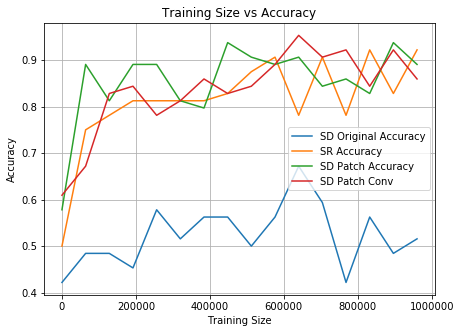

NameError: global name 'path' is not defined

In [21]:
# fig_no, training_size, accuracy, loss, start_size, end_size

generate_size_graph(1, training_size_sd_plot, accuracy_sd_plot, accuracy_sr_plot,accuracy_sd_patchonly_plot,accuracy_sd_conv_plot,  64, 960064)

### Plot Error

In [ ]:
def plot_example_errors(cls_pred, correct):
    # This function is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # correct is a boolean array whether the predicted class
    # is equal to the true class for each image in the test-set.

    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = data.test.images[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = data.test.cls[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])
    
def plot_confusion_matrix(cls_pred):
    # This is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the true classifications for the test-set.
    cls_true = data.test.cls
    
    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    # Print the confusion matrix as text.
    print(cm)

    # Plot the confusion matrix as an image.
    plt.matshow(cm)

    # Make various adjustments to the plot.
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### Print Accuracy

In [ ]:
# Split the test-set into smaller batches of this size.
test_batch_size = 256

def print_test_accuracy(show_example_errors=False,
                        show_confusion_matrix=False):

    # Number of images in the test-set.
    num_test = len(data.test.images)

    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape=num_test, dtype=np.int)

    # Now calculate the predicted classes for the batches.
    # We will just iterate through all the batches.
    # There might be a more clever and Pythonic way of doing this.

    # The starting index for the next batch is denoted i.
    i = 0

    while i < num_test:
        # The ending index for the next batch is denoted j.
        j = min(i + test_batch_size, num_test)

        # Get the images from the test-set between index i and j.
        images = data.test.images[i:j, :]

        # Get the associated labels.
        labels = data.test.labels[i:j, :]

        # Create a feed-dict with these images and labels.
        feed_dict = {x: images,
                     y_true: labels}

        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j

    # Convenience variable for the true class-numbers of the test-set.
    cls_true = data.test.cls

    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)

    # Calculate the number of correctly classified images.
    # When summing a boolean array, False means 0 and True means 1.
    correct_sum = correct.sum()

    # Classification accuracy is the number of correctly classified
    # images divided by the total number of images in the test-set.
    acc = float(correct_sum) / num_test

    # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))

    # Plot some examples of mis-classifications, if desired.
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    # Plot the confusion matrix, if desired.
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

In [ ]:
train_data[:64]

In [ ]:
x_batch, y_true_batch = data.test.next_batch(64)
x_batch

In [ ]:
type(data.train.labels)

In [ ]:
[0.84375, 0.8125, 0.78125, 0.859375, 0.796875, 0.84375, 0.796875, 0.71875, 0.6875, 0.8125, 0.890625, 0.8125, 0.84375, 0.796875, 0.75, 0.890625, 0.78125, 0.859375, 0.78125, 0.78125, 0.765625, 0.828125, 0.75, 0.796875, 0.796875, 0.734375, 0.84375, 0.828125, 0.84375, 0.6875, 0.796875, 0.84375, 0.796875, 0.84375, 0.828125, 0.859375, 0.828125, 0.84375, 0.78125, 0.90625, 0.84375, 0.875, 0.65625, 0.828125, 0.828125, 0.734375, 0.84375, 0.796875, 0.875, 0.828125, 0.71875, 0.875, 0.75, 0.875, 0.828125, 0.765625, 0.84375, 0.875, 0.734375, 0.75, 0.84375, 0.84375, 0.8125, 0.796875, 0.8125, 0.828125, 0.8125, 0.8125, 0.8125, 0.859375, 0.890625, 0.859375, 0.859375, 0.75, 0.75, 0.8125, 0.78125, 0.828125, 0.84375, 0.78125, 0.78125, 0.84375, 0.8125, 0.859375, 0.796875, 0.859375, 0.875, 0.828125, 0.75, 0.84375, 0.796875, 0.90625, 0.75, 0.859375, 0.828125, 0.828125, 0.859375, 0.90625, 0.859375, 0.734375, 0.859375, 0.90625, 0.84375, 0.859375, 0.71875, 0.765625, 0.796875, 0.890625, 0.75, 0.828125, 0.828125, 0.875, 0.796875, 0.765625, 0.890625, 0.8125, 0.828125, 0.78125, 0.890625, 0.734375, 0.796875, 0.90625, 0.84375, 0.75, 0.859375, 0.8125, 0.828125, 0.890625, 0.796875, 0.859375, 0.765625, 0.84375, 0.796875, 0.78125, 0.8125, 0.734375, 0.875, 0.8125, 0.78125, 0.8125, 0.71875, 0.78125, 0.859375, 0.78125, 0.890625, 0.90625, 0.8125, 0.78125, 0.828125, 0.8125, 0.78125, 0.78125, 0.796875, 0.734375, 0.859375, 0.765625, 0.8125, 0.828125, 0.828125, 0.84375, 0.84375, 0.859375, 0.78125, 0.765625, 0.8125, 0.8125, 0.765625, 0.875, 0.8125, 0.828125, 0.875, 0.875, 0.765625, 0.796875, 0.890625, 0.828125, 0.859375, 0.734375, 0.8125, 0.765625, 0.859375, 0.78125, 0.875, 0.78125, 0.890625, 0.765625, 0.8125, 0.875, 0.84375, 0.890625, 0.796875, 0.8125, 0.828125, 0.765625, 0.8125, 0.890625, 0.859375, 0.78125, 0.828125, 0.8125, 0.96875, 0.875, 0.78125, 0.78125, 0.875, 0.703125, 0.796875, 0.875, 0.78125, 0.828125, 0.84375, 0.796875, 0.84375, 0.796875, 0.84375, 0.921875, 0.828125, 0.828125, 0.859375, 0.796875, 0.78125, 0.78125, 0.8125, 0.78125, 0.828125, 0.890625, 0.875, 0.75, 0.796875, 0.90625, 0.859375, 0.859375, 0.875, 0.8125, 0.78125, 0.90625, 0.75, 0.828125, 0.875, 0.765625, 0.828125, 0.859375, 0.859375, 0.828125, 0.78125, 0.8125, 0.8125, 0.859375, 0.84375, 0.875, 0.84375, 0.859375, 0.875, 0.828125, 0.84375, 0.796875, 0.875, 0.84375, 0.796875, 0.78125, 0.859375, 0.859375, 0.8125, 0.859375, 0.796875, 0.703125, 0.828125, 0.875, 0.859375, 0.796875, 0.828125, 0.875, 0.84375, 0.890625, 0.859375, 0.796875, 0.8125, 0.875, 0.796875, 0.859375, 0.875, 0.828125, 0.703125, 0.78125, 0.703125, 0.84375, 0.796875, 0.875, 0.890625, 0.890625, 0.8125, 0.84375, 0.78125, 0.84375, 0.84375, 0.875, 0.8125, 0.859375, 0.796875, 0.828125, 0.84375, 0.859375, 0.859375, 0.8125, 0.828125, 0.796875, 0.8125, 0.8125, 0.84375, 0.84375, 0.8125, 0.828125, 0.828125, 0.8125, 0.890625, 0.78125, 0.796875, 0.796875, 0.828125, 0.84375, 0.90625, 0.859375, 0.84375, 0.875, 0.75, 0.84375, 0.890625, 0.765625, 0.875, 0.84375, 0.84375, 0.84375, 0.859375, 0.921875, 0.75, 0.859375, 0.828125, 0.75, 0.875, 0.765625, 0.859375, 0.875, 0.78125, 0.90625, 0.75, 0.71875, 0.75, 0.859375, 0.78125, 0.78125, 0.84375, 0.875, 0.859375, 0.765625, 0.84375, 0.78125, 0.890625, 0.78125, 0.703125, 0.796875, 0.78125, 0.78125, 0.875, 0.875, 0.859375, 0.8125, 0.859375, 0.8125, 0.859375, 0.765625, 0.765625, 0.78125, 0.8125, 0.84375, 0.859375, 0.8125, 0.859375, 0.78125, 0.78125, 0.75, 0.84375, 0.765625, 0.859375, 0.78125, 0.78125, 0.8125, 0.703125, 0.828125, 0.75, 0.90625, 0.8125, 0.828125, 0.84375, 0.859375, 0.75, 0.796875, 0.890625, 0.890625, 0.78125, 0.8125, 0.71875, 0.796875, 0.859375, 0.84375, 0.859375, 0.8125, 0.828125, 0.84375, 0.8125, 0.84375, 0.828125, 0.78125, 0.8125, 0.828125, 0.8125, 0.828125, 0.765625, 0.765625, 0.765625, 0.703125, 0.828125, 0.734375, 0.875, 0.875, 0.84375, 0.8125, 0.84375, 0.734375, 0.84375, 0.890625, 0.859375, 0.8125, 0.84375, 0.859375, 0.828125, 0.765625, 0.890625, 0.84375, 0.796875, 0.890625, 0.8125, 0.734375, 0.703125, 0.921875, 0.859375, 0.90625, 0.78125, 0.84375, 0.71875, 0.828125, 0.828125, 0.84375, 0.875, 0.828125, 0.8125, 0.78125, 0.828125, 0.890625, 0.921875, 0.828125, 0.828125, 0.84375, 0.84375, 0.828125, 0.828125, 0.84375, 0.859375, 0.859375, 0.84375, 0.765625, 0.78125, 0.8125, 0.828125, 0.796875, 0.84375, 0.84375, 0.75, 0.765625, 0.890625, 0.765625, 0.859375, 0.875, 0.875, 0.734375, 0.859375, 0.796875, 0.859375, 0.859375, 0.828125, 0.84375, 0.8125, 0.71875, 0.890625, 0.828125, 0.765625, 0.84375, 0.78125, 0.90625, 0.71875, 0.828125, 0.84375, 0.796875, 0.828125, 0.875, 0.875, 0.875, 0.828125, 0.78125, 0.859375, 0.84375, 0.796875, 0.75, 0.890625, 0.8125, 0.875, 0.8125, 0.8125]
[65, 129, 193, 257, 321, 385, 449, 513, 577, 641, 705, 769, 833, 897, 961, 1025, 1089, 1153, 1217, 1281, 1345, 1409, 1473, 1537, 1601, 1665, 1729, 1793, 1857, 1921, 1985, 2049, 2113, 2177, 2241, 2305, 2369, 2433, 2497, 2561, 2625, 2689, 2753, 2817, 2881, 2945, 3009, 3073, 3137, 3201, 3265, 3329, 3393, 3457, 3521, 3585, 3649, 3713, 3777, 3841, 3905, 3969, 4033, 4097, 4161, 4225, 4289, 4353, 4417, 4481, 4545, 4609, 4673, 4737, 4801, 4865, 4929, 4993, 5057, 5121, 5185, 5249, 5313, 5377, 5441, 5505, 5569, 5633, 5697, 5761, 5825, 5889, 5953, 6017, 6081, 6145, 6209, 6273, 6337, 6401, 6465, 6529, 6593, 6657, 6721, 6785, 6849, 6913, 6977, 7041, 7105, 7169, 7233, 7297, 7361, 7425, 7489, 7553, 7617, 7681, 7745, 7809, 7873, 7937, 8001, 8065, 8129, 8193, 8257, 8321, 8385, 8449, 8513, 8577, 8641, 8705, 8769, 8833, 8897, 8961, 9025, 9089, 9153, 9217, 9281, 9345, 9409, 9473, 9537, 9601, 9665, 9729, 9793, 9857, 9921, 9985, 10049, 10113, 10177, 10241, 10305, 10369, 10433, 10497, 10561, 10625, 10689, 10753, 10817, 10881, 10945, 11009, 11073, 11137, 11201, 11265, 11329, 11393, 11457, 11521, 11585, 11649, 11713, 11777, 11841, 11905, 11969, 12033, 12097, 12161, 12225, 12289, 12353, 12417, 12481, 12545, 12609, 12673, 12737, 12801, 12865, 12929, 12993, 13057, 13121, 13185, 13249, 13313, 13377, 13441, 13505, 13569, 13633, 13697, 13761, 13825, 13889, 13953, 14017, 14081, 14145, 14209, 14273, 14337, 14401, 14465, 14529, 14593, 14657, 14721, 14785, 14849, 14913, 14977, 15041, 15105, 15169, 15233, 15297, 15361, 15425, 15489, 15553, 15617, 15681, 15745, 15809, 15873, 15937, 16001, 16065, 16129, 16193, 16257, 16321, 16385, 16449, 16513, 16577, 16641, 16705, 16769, 16833, 16897, 16961, 17025, 17089, 17153, 17217, 17281, 17345, 17409, 17473, 17537, 17601, 17665, 17729, 17793, 17857, 17921, 17985, 18049, 18113, 18177, 18241, 18305, 18369, 18433, 18497, 18561, 18625, 18689, 18753, 18817, 18881, 18945, 19009, 19073, 19137, 19201, 19265, 19329, 19393, 19457, 19521, 19585, 19649, 19713, 19777, 19841, 19905, 19969, 20033, 20097, 20161, 20225, 20289, 20353, 20417, 20481, 20545, 20609, 20673, 20737, 20801, 20865, 20929, 20993, 21057, 21121, 21185, 21249, 21313, 21377, 21441, 21505, 21569, 21633, 21697, 21761, 21825, 21889, 21953, 22017, 22081, 22145, 22209, 22273, 22337, 22401, 22465, 22529, 22593, 22657, 22721, 22785, 22849, 22913, 22977, 23041, 23105, 23169, 23233, 23297, 23361, 23425, 23489, 23553, 23617, 23681, 23745, 23809, 23873, 23937, 24001, 24065, 24129, 24193, 24257, 24321, 24385, 24449, 24513, 24577, 24641, 24705, 24769, 24833, 24897, 24961, 25025, 25089, 25153, 25217, 25281, 25345, 25409, 25473, 25537, 25601, 25665, 25729, 25793, 25857, 25921, 25985, 26049, 26113, 26177, 26241, 26305, 26369, 26433, 26497, 26561, 26625, 26689, 26753, 26817, 26881, 26945, 27009, 27073, 27137, 27201, 27265, 27329, 27393, 27457, 27521, 27585, 27649, 27713, 27777, 27841, 27905, 27969, 28033, 28097, 28161, 28225, 28289, 28353, 28417, 28481, 28545, 28609, 28673, 28737, 28801, 28865, 28929, 28993, 29057, 29121, 29185, 29249, 29313, 29377, 29441, 29505, 29569, 29633, 29697, 29761, 29825, 29889, 29953, 30017, 30081, 30145, 30209, 30273, 30337, 30401, 30465, 30529, 30593, 30657, 30721, 30785, 30849, 30913, 30977, 31041, 31105, 31169, 31233, 31297, 31361, 31425, 31489, 31553, 31617, 31681, 31745, 31809, 31873, 31937, 32001, 32065, 32129, 32193, 32257, 32321, 32385, 32449, 32513, 32577, 32641, 32705, 32769, 32833, 32897, 32961, 33025, 33089]
[0.875, 0.953125, 0.796875, 0.890625, 0.875, 0.921875, 0.9375, 0.84375, 0.90625, 0.90625, 0.8125, 0.921875, 0.84375, 0.8125, 0.890625, 0.796875, 0.890625, 0.9375, 0.90625, 0.9375, 0.890625, 0.90625, 0.828125, 0.84375, 0.90625, 0.859375, 0.890625, 0.859375, 0.8125, 0.828125, 0.875, 0.796875, 0.796875, 0.796875, 0.90625, 0.890625, 0.921875, 0.875, 0.859375, 0.890625, 0.90625, 0.953125, 0.765625, 0.90625, 0.90625, 0.84375, 0.859375, 0.84375, 0.890625, 0.890625, 0.875, 0.859375, 0.953125, 0.90625, 0.84375, 0.796875, 0.84375, 0.9375, 0.90625, 0.84375, 0.78125, 0.90625, 0.8125, 0.8125, 0.859375, 0.875, 0.953125, 0.875, 0.859375, 0.875, 0.9375, 0.90625, 0.921875, 0.890625, 0.859375, 0.890625, 0.890625, 0.859375, 0.9375, 0.859375, 0.859375, 0.828125, 0.828125, 0.875, 0.796875, 0.890625, 0.8125, 0.828125, 0.828125, 0.921875, 0.78125, 0.828125, 0.90625, 0.875, 0.796875, 0.921875, 0.8125, 0.828125, 0.8125, 0.90625, 0.90625, 0.921875, 0.796875, 0.78125, 0.875, 0.859375, 0.90625, 0.828125, 0.84375, 0.828125, 0.828125, 0.828125, 0.890625, 0.84375, 0.953125, 0.828125, 0.890625, 0.859375, 0.9375, 0.921875, 0.859375, 0.859375, 0.921875, 0.890625, 0.90625, 0.828125, 0.90625, 0.859375, 0.921875, 0.90625, 0.90625, 0.921875, 0.828125, 0.859375, 0.890625, 0.859375, 0.890625, 0.9375, 0.765625, 0.859375, 0.8125, 0.859375, 0.84375, 0.90625, 0.90625, 0.828125, 0.859375, 0.90625, 0.84375, 0.875, 0.9375, 0.9375, 0.90625, 0.890625, 0.9375, 0.84375, 0.828125, 0.859375, 0.84375, 0.84375, 0.84375, 0.859375, 0.84375, 0.828125, 0.875, 0.921875, 0.875, 0.921875, 0.8125, 0.875, 0.875, 0.875, 0.84375, 0.875, 0.84375, 0.9375, 0.765625, 0.875, 0.890625, 0.828125, 0.875, 0.84375, 0.84375, 0.984375, 0.859375, 0.859375, 0.890625, 0.875, 0.828125, 0.9375, 0.875, 0.84375, 0.875, 0.875, 0.921875, 0.875, 0.921875, 0.875, 0.890625, 0.828125, 0.90625, 0.828125, 0.890625, 0.875, 0.796875, 0.765625, 0.9375, 0.859375, 0.921875, 0.875, 0.875, 0.875, 0.890625, 0.890625, 0.796875, 0.875, 0.875, 0.796875, 0.859375, 0.859375, 0.8125, 0.9375, 0.859375, 0.890625, 0.90625, 0.859375, 0.890625, 0.921875, 0.8125, 0.921875, 0.875, 0.859375, 0.875, 0.875, 0.828125, 0.828125, 0.875, 0.90625, 0.90625, 0.859375, 0.875, 0.953125, 0.875, 0.828125, 0.9375, 0.828125, 0.8125, 0.90625, 0.921875, 0.828125, 0.875, 0.890625, 0.921875, 0.890625, 0.796875, 0.84375, 0.875, 0.828125, 0.8125, 0.890625, 0.828125, 0.90625, 0.8125, 0.84375, 0.859375, 0.90625, 0.859375, 0.890625, 0.90625, 0.859375, 0.828125, 0.890625, 0.921875, 0.859375, 0.78125, 0.890625, 0.859375, 0.84375, 0.859375, 0.890625, 0.84375, 0.828125, 0.890625, 0.921875, 0.921875, 0.828125, 0.921875, 0.84375, 0.84375, 0.875, 0.90625, 0.875, 0.875, 0.84375, 0.90625, 0.921875, 0.921875, 0.90625, 0.84375, 0.890625, 0.8125, 0.734375, 0.9375, 0.84375, 0.875, 0.8125, 0.90625, 0.90625, 0.828125, 0.90625, 0.921875, 0.890625, 0.875, 0.875, 0.859375, 0.875, 0.765625, 0.828125, 0.890625, 0.875, 0.890625, 0.875, 0.890625, 0.875, 0.8125, 0.875, 0.84375, 0.875, 0.921875, 0.84375, 0.875, 0.84375, 0.84375, 0.90625, 0.90625, 0.921875, 0.859375, 0.859375, 0.828125, 0.953125, 0.84375, 0.875, 0.953125, 0.875, 0.84375, 0.84375, 0.875, 0.84375, 0.84375, 0.859375, 0.90625, 0.875, 0.921875, 0.90625, 0.765625, 0.84375, 0.859375, 0.859375, 0.84375, 0.890625, 0.828125, 0.8125, 0.84375, 0.90625, 0.890625, 0.8125, 0.890625, 0.828125, 0.90625, 0.875, 0.828125, 0.8125, 0.765625, 0.890625, 0.859375, 0.859375, 0.984375, 0.84375, 0.859375, 0.875, 0.921875, 0.890625, 0.96875, 0.828125, 0.84375, 0.84375, 0.90625, 0.890625, 0.875, 0.90625, 0.875, 0.9375, 0.859375, 0.84375, 0.8125, 0.828125, 0.890625, 0.84375, 0.875, 0.890625, 0.828125, 0.859375, 0.859375, 0.875, 0.890625, 0.859375, 0.875, 0.890625, 0.890625, 0.9375, 0.921875, 0.90625, 0.921875, 0.859375, 0.828125, 0.828125, 0.828125, 0.828125, 0.765625, 0.8125, 0.796875, 0.84375, 0.8125, 0.84375, 0.875, 0.828125, 0.8125, 0.84375, 0.90625, 0.875, 0.859375, 0.84375, 0.875, 0.890625, 0.921875, 0.796875, 0.859375, 0.859375, 0.90625, 0.859375, 0.828125, 0.84375, 0.828125, 0.90625, 0.84375, 0.875, 0.953125, 0.828125, 0.875, 0.921875, 0.890625, 0.8125, 0.90625, 0.8125, 0.875, 0.8125, 0.84375, 0.90625, 0.90625, 0.859375, 0.84375, 0.875, 0.859375, 0.828125, 0.875, 0.8125, 0.890625, 0.875, 0.8125, 0.875, 0.859375, 0.875, 0.875, 0.828125, 0.921875, 0.828125, 0.828125, 0.953125, 0.828125, 0.859375, 0.875, 0.890625, 0.90625, 0.796875, 0.859375, 0.890625, 0.859375, 0.859375, 0.84375, 0.90625, 0.8125, 0.875, 0.875, 0.859375, 0.828125, 0.890625, 0.890625, 0.875, 0.84375, 0.84375, 0.921875, 0.828125, 0.859375, 0.890625, 0.875, 0.890625, 0.859375, 0.859375, 0.84375, 0.84375, 0.875, 0.890625, 0.875, 0.859375, 0.84375, 0.875, 0.8125]
[65, 129, 193, 257, 321, 385, 449, 513, 577, 641, 705, 769, 833, 897, 961, 1025, 1089, 1153, 1217, 1281, 1345, 1409, 1473, 1537, 1601, 1665, 1729, 1793, 1857, 1921, 1985, 2049, 2113, 2177, 2241, 2305, 2369, 2433, 2497, 2561, 2625, 2689, 2753, 2817, 2881, 2945, 3009, 3073, 3137, 3201, 3265, 3329, 3393, 3457, 3521, 3585, 3649, 3713, 3777, 3841, 3905, 3969, 4033, 4097, 4161, 4225, 4289, 4353, 4417, 4481, 4545, 4609, 4673, 4737, 4801, 4865, 4929, 4993, 5057, 5121, 5185, 5249, 5313, 5377, 5441, 5505, 5569, 5633, 5697, 5761, 5825, 5889, 5953, 6017, 6081, 6145, 6209, 6273, 6337, 6401, 6465, 6529, 6593, 6657, 6721, 6785, 6849, 6913, 6977, 7041, 7105, 7169, 7233, 7297, 7361, 7425, 7489, 7553, 7617, 7681, 7745, 7809, 7873, 7937, 8001, 8065, 8129, 8193, 8257, 8321, 8385, 8449, 8513, 8577, 8641, 8705, 8769, 8833, 8897, 8961, 9025, 9089, 9153, 9217, 9281, 9345, 9409, 9473, 9537, 9601, 9665, 9729, 9793, 9857, 9921, 9985, 10049, 10113, 10177, 10241, 10305, 10369, 10433, 10497, 10561, 10625, 10689, 10753, 10817, 10881, 10945, 11009, 11073, 11137, 11201, 11265, 11329, 11393, 11457, 11521, 11585, 11649, 11713, 11777, 11841, 11905, 11969, 12033, 12097, 12161, 12225, 12289, 12353, 12417, 12481, 12545, 12609, 12673, 12737, 12801, 12865, 12929, 12993, 13057, 13121, 13185, 13249, 13313, 13377, 13441, 13505, 13569, 13633, 13697, 13761, 13825, 13889, 13953, 14017, 14081, 14145, 14209, 14273, 14337, 14401, 14465, 14529, 14593, 14657, 14721, 14785, 14849, 14913, 14977, 15041, 15105, 15169, 15233, 15297, 15361, 15425, 15489, 15553, 15617, 15681, 15745, 15809, 15873, 15937, 16001, 16065, 16129, 16193, 16257, 16321, 16385, 16449, 16513, 16577, 16641, 16705, 16769, 16833, 16897, 16961, 17025, 17089, 17153, 17217, 17281, 17345, 17409, 17473, 17537, 17601, 17665, 17729, 17793, 17857, 17921, 17985, 18049, 18113, 18177, 18241, 18305, 18369, 18433, 18497, 18561, 18625, 18689, 18753, 18817, 18881, 18945, 19009, 19073, 19137, 19201, 19265, 19329, 19393, 19457, 19521, 19585, 19649, 19713, 19777, 19841, 19905, 19969, 20033, 20097, 20161, 20225, 20289, 20353, 20417, 20481, 20545, 20609, 20673, 20737, 20801, 20865, 20929, 20993, 21057, 21121, 21185, 21249, 21313, 21377, 21441, 21505, 21569, 21633, 21697, 21761, 21825, 21889, 21953, 22017, 22081, 22145, 22209, 22273, 22337, 22401, 22465, 22529, 22593, 22657, 22721, 22785, 22849, 22913, 22977, 23041, 23105, 23169, 23233, 23297, 23361, 23425, 23489, 23553, 23617, 23681, 23745, 23809, 23873, 23937, 24001, 24065, 24129, 24193, 24257, 24321, 24385, 24449, 24513, 24577, 24641, 24705, 24769, 24833, 24897, 24961, 25025, 25089, 25153, 25217, 25281, 25345, 25409, 25473, 25537, 25601, 25665, 25729, 25793, 25857, 25921, 25985, 26049, 26113, 26177, 26241, 26305, 26369, 26433, 26497, 26561, 26625, 26689, 26753, 26817, 26881, 26945, 27009, 27073, 27137, 27201, 27265, 27329, 27393, 27457, 27521, 27585, 27649, 27713, 27777, 27841, 27905, 27969, 28033, 28097, 28161, 28225, 28289, 28353, 28417, 28481, 28545, 28609, 28673, 28737, 28801, 28865, 28929, 28993, 29057, 29121, 29185, 29249, 29313, 29377, 29441, 29505, 29569, 29633, 29697, 29761, 29825, 29889, 29953, 30017, 30081, 30145, 30209, 30273, 30337, 30401, 30465, 30529, 30593, 30657, 30721, 30785, 30849, 30913, 30977, 31041, 31105, 31169, 31233, 31297, 31361, 31425, 31489, 31553, 31617, 31681, 31745, 31809, 31873, 31937, 32001, 32065, 32129, 32193, 32257, 32321, 32385, 32449, 32513, 32577, 32641, 32705, 32769, 32833, 32897, 32961, 33025, 33089]

In [ ]:
[0.682583252895753, 0.7848998552123552, 0.8154862451737451, 0.823871862934363, 0.8351532335907336, 0.838531611969112, 0.8439611486486487, 0.8454391891891891, 0.8443532818532818, 0.8474601833976834, 0.8517434845559846, 0.8527992277992278, 0.8534930019305019, 0.8545789092664092, 0.8536438223938224, 0.8558458011583011, 0.8557251447876448, 0.8581081081081081, 0.8593448359073359, 0.8613055019305019, 0.8607625482625483, 0.8619087837837838, 0.8626930501930502, 0.86652388996139, 0.8641710907335908, 0.8649855212355212, 0.8659809362934363, 0.868846525096525, 0.8675494691119691, 0.8706865347490348]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
[0.682583252895753, 0.7848998552123552, 0.8154862451737451, 0.823871862934363, 0.8351532335907336, 0.838531611969112, 0.8439611486486487, 0.8454391891891891, 0.8443532818532818, 0.8474601833976834, 0.8517434845559846, 0.8527992277992278, 0.8534930019305019, 0.8545789092664092, 0.8536438223938224, 0.8558458011583011, 0.8557251447876448, 0.8581081081081081, 0.8593448359073359, 0.8613055019305019, 0.8607625482625483, 0.8619087837837838, 0.8626930501930502, 0.86652388996139, 0.8641710907335908, 0.8649855212355212, 0.8659809362934363, 0.868846525096525, 0.8675494691119691, 0.8706865347490348]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]

In [92]:
training_size_sd_plot = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
accuracy_patch = [0.682583252895753, 0.7848998552123552, 0.8154862451737451, 0.823871862934363, 0.8351532335907336, 0.838531611969112, 0.8439611486486487, 0.8454391891891891, 0.8443532818532818, 0.8474601833976834, 0.8517434845559846, 0.8527992277992278, 0.8534930019305019, 0.8545789092664092, 0.8536438223938224, 0.8558458011583011, 0.8557251447876448, 0.8581081081081081, 0.8593448359073359, 0.8613055019305019, 0.8607625482625483, 0.8619087837837838, 0.8626930501930502, 0.86652388996139, 0.8641710907335908, 0.8649855212355212, 0.8659809362934363, 0.868846525096525, 0.8675494691119691, 0.8706865347490348]
accuracy_sd = [0.5181587837837838, 0.5230755308880309, 0.5339346042471043, 0.5334218146718147, 0.5387910231660231, 0.5470258204633205, 0.5545668436293436, 0.567386583011583, 0.5835847007722008, 0.6008083976833977, 0.619449806949807, 0.6399915540540541, 0.6607142857142857, 0.6763694498069498, 0.6886763996138996, 0.699867277992278, 0.7165178571428571, 0.7225808397683398, 0.7372104247104247, 0.7440878378378378, 0.753921332046332, 0.7609797297297297, 0.7618544884169884, 0.7700289575289575, 0.7795004826254827, 0.783210666023166, 0.7914152992277992, 0.7912946428571429, 0.800132722007722, 0.8066180019305019]

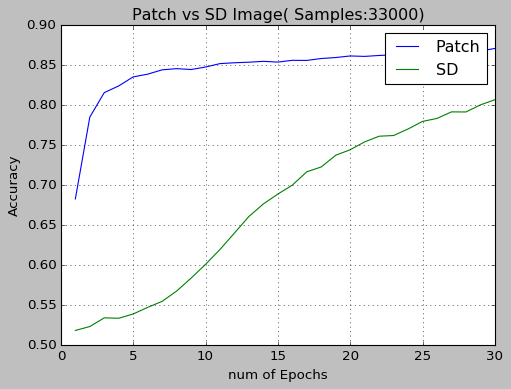

In [96]:
generate_graph(1, training_size_sd_plot, accuracy_patch, accuracy_sd, "Accuracy", "Patch", "SD Image", 33000)